<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Belgium/Solvay/Solvay_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "SOLB.BR"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  50.98  51.94  50.60  51.29      34.22  225239
2009-01-05  52.12  53.09  51.94  52.80      35.23  296135
2009-01-06  53.28  54.60  51.93  54.28      36.22  450629
2009-01-07  54.51  55.09  54.05  54.74      36.53  339611
2009-01-08  54.20  55.09  53.71  54.37      36.28  246961
...           ...    ...    ...    ...        ...     ...
2018-12-21  86.60  87.84  86.04  87.84      84.19  376637
2018-12-24  86.68  87.70  86.68  86.68      83.08   59134
2018-12-27  88.50  89.20  85.44  86.18      82.60  229353
2018-12-28  87.00  87.90  86.62  87.24      83.61  127804
2018-12-31  88.14  88.14  87.02  87.32      83.69   52503

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     93.364765    94.264742    92.363294    93.322195    78.254002  2.714804e+05
std      20.571862    20.590779    20.589242    20.597084    22.959019  1.621162e+05
min      39.530000    39.850000    38.810000    39.480000    26.970000  7.063000e+03
25%      73.885000    74.592500    73.055000    73.897500    55.420000  1.785362e+05
50%      97.990000    98.970000    96.950000    98.005000    81.680000  2.357230e+05
75%     110.620000   111.427500   109.612500   110.670000    97.097500  3.145498e+05
max     132.380000   132.610000   130.870000   132.470000   122.000000  2.193711e+06

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  39.84  40.10  39.57  39.69      27.12  386665   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  40.147247  42.934428 -41.020000  39.367810  40.384098  40.362938      40.170      39.915  43.266208  40.06750  39.922191  40.0855  40.053611  40.06750  40.130000  42.971055               41.012950                 40.06750               39.122050               41.485674                 40.06750               38.649326               41.958399                 40.06750               38.176601               42.431124                 40.06750               37.703876  40.384098  39.933159  42.402987               41.329547                40.384098               39.438648               41.802272                40.384098               38.965923               42.274997                40.384098               38.493199               42.747722                40.384098   
2009-03-16  39.92  40.23  39.47  40.04      27.36  324504   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  40.138620  42.821978 -40.580000  39.457712  40.307632  40.357272      40.170      39.915  42.909711  40.01250  40.018294  40.1300  40.047500  40.01250  39.865000  42.568054               40.905291                 40.01250               39.119709               41.351686                 40.01250               38.673314               41.798081                 40.01250               38.226919               42.244476                 40.01250               37.780524  40.307632  39.970536  42.034759               41.200422                40.307632               39.414841               41.646817                40.307632               38.968446               42.093213                40.307632               38.522051               42.539608                40.307632   
2009-03-17  40.41  42.39  40.07  41.56      28.39

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     94.250563    95.157302    93.249800    94.213771    79.155351  2.703826e+05    15.774142     1.998404   186.245810      30.462889      0.032721        0.027933        0.009976          0.007981     6.625698     2.540702    27.029928     1.998404      2.012769    27.029928    94.181390    94.102384     3.213135    94.213802    94.148047    94.184604    94.145780    94.101355    93.956568    94.148186    94.214088    94.148337    94.170121    94.148186    94.189819    94.016821               97.118363                94.148186               91.178009               98.603451                94.148186               89.692920              100.088540                94.148186               88.207832              101.573628                94.148186               86.722743    94.148047    94.197013    94.036347               97.118224                94.148047               91.177870               98.603312                94.148047               89.692781              100.088400   
std      19.774543    19.778908    19.791238    19.787572    22.268145  1.623122e+05     8.732031     1.408556   103.650851       0.785865      0.177942        0.164814        0.099401          0.088996     3.396541     1.106387    14.824654     1.408556      1.412461    14.824654    19.884139    19.902649    96.058737    19.821593    19.779848    19.789514    19.808388    19.794002    20.098304    19.816262    19.800526    19.831711    19.793767    19.816262    19.788554    19.871025               19.872935                19.816262               19.893630               19.951285                19.816262               19.982198               20.062513                19.816262               20.103492               20.206074                19.816262               20.256922    19.779848    19.778803    19.865336               19.833357                19.779848               19.860621               19.910236                19.779848               19.950960               20.020073   
min      39.840000    40.100000    39.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2009-03-13  0.000000  0.000000  0.001094  0.000000   0.000000  386665   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000096  0.007789  0.353617  0.000000  0.000853  0.000064    0.000000    0.000000  0.047508  0.000611  0.000000  0.000000  0.000067  0.000611  0.002880  0.014951                0.001158                 0.000611                0.012822                0.001390                 0.000611                0.030097                0.001607                 0.000611                0.047175                0.001809                 0.000611                0.082196  0.000853  0.000000  0.011947                0.001396                 0.000853                0.007902                0.001645                 0.000853                0.025423                0.001857                 0.000853                0.042464                0.002054                 0.000853   
2009-03-16  0.000864  0.001405  0.000000  0.003772   0.002530  324504   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000000  0.006486  0.355316  0.000976  0.000000  0.000000    0.000000    0.000000  0.043707  0.000000  0.001048  0.000492  0.000000  0.000000  0.000000  0.010299                0.000000                 0.000000                0.012796                0.000000                 0.000000                0.030365                0.000000                 0.000000                0.047734                0.000000                 0.000000                0.083018  0.000000  0.000409  0.007721                0.000000                 0.000000                0.007631                0.000000                 0.000000                0.025452                0.000000                 0.000000                0.042786                0.000000                 0.000000   
2009-03-17  0.006159  0.024754  0.006565  0.020155   0.0

139949

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         1 hour 46 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_xxca9k
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190825_134924  0.536872  0.966126              0.429498  0.580328  0.336781
1  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.532517  0.695628              0.481341  0.501239  0.251240
2  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.517673  0.753081              0.500000  0.511227  0.261353
3  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.500000  0.701672              0.500000  0.504227  0.254244
4  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.500000  0.700687              0.500000  0.503742  0.253756
5  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.494406  0.738019              0.473649  0.519045  0.269408
6  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.491100  0.987465              0.500000  0.579647  0.335991
7  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.485569  0.752721              0.500000  0.526644  0.277354
8  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.471583  2.113443              0.500000  0.651434  0.424367
9  DeepLearning_grid_1_AutoML_20190825_134924_mod...  0.469612  0.697430              0.500000  0.502142  0.252146

variable  relative_importance  scaled_importance  percentage
0       HT_DCPERIOD             1.000000           1.000000    0.001765
1       AROONOSC_14             0.879003           0.879003    0.001551
2         CDL2CROWS             0.870364           0.870364    0.001536
3               EXP             0.858556           0.858556    0.001515
4        PLUS_DM_30             0.841952           0.841952    0.001486
...             ...                  ...                ...         ...
1034  CDLHANGINGMAN             0.257945           0.257945    0.000455
1035          DX_20             0.257103           0.257103    0.000454
1036         T3_8_5             0.251163           0.251163    0.000443
1037      MAVP_14_7             0.237981           0.237981    0.000420
1038         SUM_30             0.231106           0.231106    0.000408

[1039 rows x 4 columns]

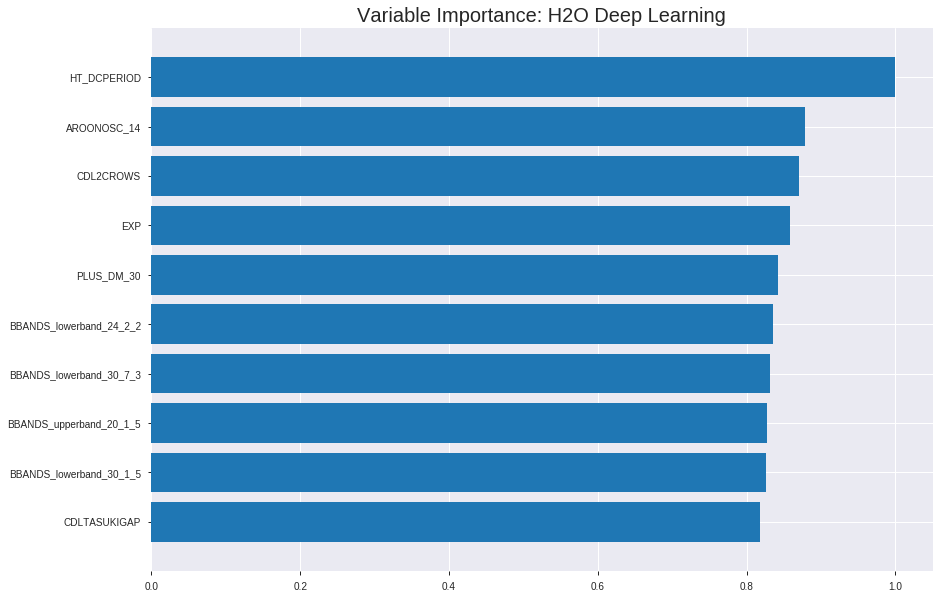

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190825_134924


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2594591390251597
RMSE: 0.5093713174346979
LogLoss: 0.744975964790634
Mean Per-Class Error: 0.43085585585585584
AUC: 0.5965936312034578
pr_auc: 0.6333512640128123
Gini: 0.19318726240691553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.025562403513914488: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      23   842   0.9734   (842.0/865.0)
1      9    879   0.0101   (9.0/888.0)
Total  32   1721  0.4855   (851.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0255624    0.673821  389
max f2                       0.0149408    0.83742   396
max f0point5                 0.355713     0.58479   221
max accuracy                 0.452584     0.568739  142
max precision                0.999624     1         0
max recall                   0.0149408    1         396
max specificity              0.999624     1         0
max absolute_mcc             0.702311     0.179872  56
max min_per_class_accuracy   0.442311     0.563063  151
max mean_per_class_accuracy  0.452584     0.569144  142

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 41.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.961422           1.9741    1.9741             1                0.990976   1                           0.990976            0.0202703       0.0202703                  97.4099    97.4099
    2        0.0205362                   0.900134           1.86443   1.91926            0.944444         0.9309     0.972222                    0.960938            0.0191441       0.0394144                  86.4427    91.9263
    3        0.0302339                   0.851274           1.74185   1.86236            0.882353         0.874951   0.943396                    0.933358            0.0168919       0.0563063                  74.1852    86.2358
    4        0.040502                    0.751057           1.64508   1.80727            0.833333         0.800326   0.915493                    0.899631            0.0168919       0.0731982                  64.5083    80.7274
    5        0.0501997                   0.700942           1.62573   1.7722             0.823529         0.724096   0.897727                    0.865721            0.0157658       0.088964                   62.5729    77.2203
    6        0.390759                    0.517              1.08129   1.17005            0.547739         0.526046   0.592701                    0.569683            0.368243        0.457207                   8.12905    17.005
    7        0.399886                    0.509132           0.740287  1.16024            0.375            0.512172   0.587732                    0.56837             0.00675676      0.463964                   -25.9713   16.0241
    8        0.500285                    0.439954           0.998266  1.12774            0.505682         0.470873   0.571266                    0.548804            0.100225        0.564189                   -0.173398  12.7735
    9        0.600114                    0.404507           0.925006  1.09401            0.468571         0.421859   0.554183                    0.527687            0.0923423       0.656532                   -7.49936   9.40112
    10       0.699943                    0.346521           1.06037   1.08921            0.537143         0.381055   0.551752                    0.506774            0.105856        0.762387                   6.03732    8.92136
    11       0.799772                    0.262719           0.721956  1.04337            0.365714         0.306      0.528531                    0.481713            0.0720721       0.834459                   -27.8044   4.33719
    12       0.899601                    0.11053            0.834762  1.02022            0.422857         0.193301   0.516804                    0.449708            0.0833333       0.917793                   -16.5238   2.02224
    13       1                           0.00609135         0.818802  1                  0.414773         0.0572974  0.50656                     0.41031             0.0822072       1                          -18.1198   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3616684322408854
RMSE: 0.6013887530049805
LogLoss: 1.1863223885719196
Mean Per-Class Error: 0.43555313421356234
AUC: 0.5601765799256505
pr_auc: 0.5549913395244267
Gini: 0.12035315985130102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.033555139164832666: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   205  0.8836   (205.0/232.0)
1      10   259  0.0372   (10.0/269.0)
Total  37   464  0.4291   (215.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0335551    0.706685  375
max f2                       0.0221423    0.856143  395
max f0point5                 0.0964686    0.611341  299
max accuracy                 0.0967504    0.578842  298
max precision                0.414342     0.611511  106
max recall                   0.0221423    1         395
max specificity              0.999951     0.982759  0
max absolute_mcc             0.0335551    0.151012  375
max min_per_class_accuracy   0.221315     0.525862  208
max mean_per_class_accuracy  0.118682     0.564447  283

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 29.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.999861           0.620818  0.620818           0.333333         0.999951   0.333333                    0.999951            0.00743494      0.00743494                 -37.9182  -37.9182
    2        0.0219561                   0.996639           0.744981  0.677256           0.4              0.998256   0.363636                    0.99918             0.00743494      0.0148699                  -25.5019  -32.2744
    3        0.0319361                   0.989022           0.744981  0.69842            0.4              0.991849   0.375                       0.996889            0.00743494      0.0223048                  -25.5019  -30.158
    4        0.0419162                   0.970401           1.11747   0.798194           0.6              0.981751   0.428571                    0.993285            0.0111524       0.0334572                  11.7472   -20.1806
    5        0.0518962                   0.961157           0.744981  0.787961           0.4              0.965008   0.423077                    0.987847            0.00743494      0.0408922                  -25.5019  -21.2039
    6        0.101796                    0.685238           1.19197   0.986005           0.64             0.839124   0.529412                    0.914944            0.0594796       0.100372                   19.197    -1.39952
    7        0.165669                    0.517              1.10583   1.0322             0.59375          0.540879   0.554217                    0.770726            0.070632        0.171004                   10.5832   3.22032
    8        0.201597                    0.442993           0.827757  0.995767           0.444444         0.467207   0.534653                    0.716633            0.0297398       0.200743                   -17.2243  -0.423277
    9        0.301397                    0.407599           1.30372   1.09774            0.7              0.422927   0.589404                    0.619379            0.130112        0.330855                   30.3717   9.77375
    10       0.401198                    0.325181           1.00572   1.07485            0.54             0.37622    0.577114                    0.558892            0.100372        0.431227                   0.572491  7.48488
    11       0.500998                    0.221339           0.931227  1.04624            0.5              0.274314   0.561753                    0.502203            0.0929368       0.524164                   -6.87732  4.62388
    12       0.600798                    0.14937            1.22922   1.07663            0.66             0.181863   0.578073                    0.448991            0.122677        0.64684                    22.9219   7.66343
    13       0.700599                    0.0990368          1.08022   1.07715            0.58             0.126251   0.578348                    0.403016            0.107807        0.754647                   8.0223    7.71455
    14       0.800399                    0.0554398          0.931227  1.05895            0.5              0.0746815  0.568579                    0.362077            0.0929368       0.847584                   -6.87732  5.89511
    15       0.9002                      0.0390846          0.856729  1.03653            0.46             0.046803   0.556541                    0.327124            0.0855019       0.933086                   -14.3271  3.65318
    16       1                           0.0126778          0.670483  1                  0.36             0.0290208  0.536926            


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:49:24  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 13:49:24  0.353 sec   8898 obs/sec      1         1             1753       0.562628         0.958647            -0.266421      0.550529        0.562447           1.64508          0.491728                         0.637767           1.59256               -0.635909        0.552654          0.54977              0.931227           0.429142
    2019-08-25 13:49:26  1.825 sec   11165 obs/sec     10        10            17530      0.509371         0.744976            -0.0380152     0.596594        0.633351           1.9741           0.485454                         0.601389           1.18632               -0.454607        0.560177          0.554991             0.620818           0.429142

Variable Importances: 


variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  ----------------------
HT_DCPERIOD    1.0                    1.0                  0.0017650082468418607
AROONOSC_14    0.8790026903152466     0.8790026903152466   0.0015514469974025923
CDL2CROWS      0.8703638911247253     0.8703638911247253   0.0015361994455885116
EXP            0.8585556745529175     0.8585556745529175   0.0015153578459587758
PLUS_DM_30     0.8419521450996399     0.8419521450996399   0.0014860524795470593
---            ---                    ---                  ---
CDLHANGINGMAN  0.25794506072998047    0.25794506072998047  0.0004552751594205401
DX_20          0.25710299611091614    0.25710299611091614  0.00045378890842351783
T3_8_5         0.251162588596344      0.251162588596344    0.0004433040401706966
MAVP_14_7      0.23798052966594696    0.23798052966594696  0.0004200375974481905
SUM_30         0.23110553622245789    0.23110553622245789  0.0004079031773234485


See the whole table with table.as_data_frame()


('accuracy', 0.5617529880478087)

('F1', 0.6686567164179104)

('auc', 0.5368722186904006)

('logloss', 0.9661259131630682)

('mean_per_class_error', 0.4262237762237763)

('rmse', 0.5803283402146818)

('mse', 0.3367809824563275)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


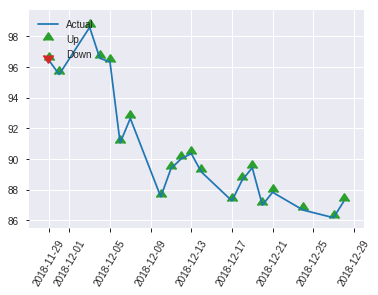


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3367809824563275
RMSE: 0.5803283402146818
LogLoss: 0.9661259131630682
Mean Per-Class Error: 0.4262237762237763
AUC: 0.5368722186904006
pr_auc: 0.50762992427169
Gini: 0.07374443738080116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08924117627177466: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      28   102  0.7846   (102.0/130.0)
1      9    112  0.0744   (9.0/121.0)
Total  37   214  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0892412    0.668657  213
max f2                       0.0569018    0.825375  248
max f0point5                 0.0915167    0.574713  208
max accuracy                 0.0915167    0.561753  208
max precision                0.70511      0.75      3
max recall                   0.0569018    1         248
max specificity              0.994227     0.992308  0
max absolute_mcc             0.0892412    0.198742  213
max min_per_class_accuracy   0.165779     0.512397  123
max mean_per_class_accuracy  0.0915167    0.573776  208

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 21.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.722253           1.38292   1.38292            0.666667         0.900287   0.666667                    0.900287            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.58427            1.38292   1.38292            0.666667         0.636124   0.666667                    0.768205            0.0165289       0.0330579                  38.292     38.292
    3        0.0318725                   0.508035           0         1.03719            0                0.538892   0.5                         0.710877            0               0.0330579                  -100       3.71901
    4        0.0438247                   0.452076           2.07438   1.32006            1                0.477347   0.636364                    0.647187            0.0247934       0.0578512                  107.438    32.006
    5        0.0517928                   0.447878           1.03719   1.27654            0.5              0.450381   0.615385                    0.616909            0.00826446      0.0661157                  3.71901    27.6542
    6        0.103586                    0.406878           0.797839  1.03719            0.384615         0.432142   0.5                         0.524525            0.0413223       0.107438                   -20.2161   3.71901
    7        0.151394                    0.358265           1.03719   1.03719            0.5              0.385891   0.5                         0.480746            0.0495868       0.157025                   3.71901    3.71901
    8        0.203187                    0.326962           1.43611   1.13888            0.692308         0.348159   0.54902                     0.44695             0.0743802       0.231405                   43.6109    13.8875
    9        0.302789                    0.265701           0.663802  0.982601           0.32             0.29452    0.473684                    0.396808            0.0661157       0.297521                   -33.6198   -1.73989
    10       0.40239                     0.213525           0.995702  0.985844           0.48             0.240966   0.475248                    0.358233            0.0991736       0.396694                   -0.429752  -1.4156
    11       0.501992                    0.16409            1.16165   1.02073            0.56             0.183036   0.492063                    0.323472            0.115702        0.512397                   16.1653    2.07267
    12       0.601594                    0.130293           0.912727  1.00285            0.44             0.145973   0.483444                    0.294085            0.0909091       0.603306                   -8.72727   0.284604
    13       0.701195                    0.109708           1.49355   1.07255            0.72             0.119715   0.517045                    0.269316            0.14876         0.752066                   49.3554    7.25488
    14       0.800797                    0.0950146          0.995702  1.06299            0.48             0.101737   0.512438                    0.248473            0.0991736       0.85124                    -0.429752  6.29908
    15       0.900398                    0.0811097          0.995702  1.05555            0.48             0.0890559  0.50885                     0.230838            0.0991736       0.950413                   -0.429752  5.55474
    16       1                           0.0539378          0.497851  1                  0.24             0.0697569  0.482072   

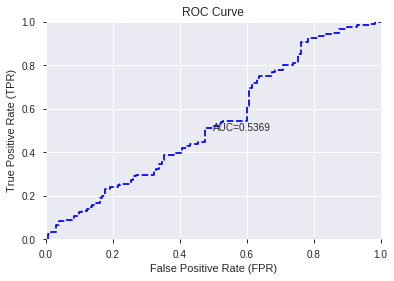

This function is available for GLM models only


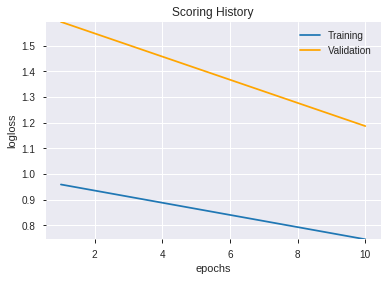

--2019-08-25 14:20:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190825_134924',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190825_134924',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_b594',


In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_142019_model_2  0.568722  0.938765              0.500000  0.542880  0.294719
1  DeepLearning_grid_1_AutoML_20190825_142019_model_1  0.561729  1.011108              0.481055  0.573108  0.328453
2  DeepLearning_grid_1_AutoML_20190825_142019_model_3  0.548188  0.754506              0.481914  0.522791  0.273311
3               DeepLearning_1_AutoML_20190825_142019  0.530324  0.703520              0.488748  0.504325  0.254343
4  DeepLearning_grid_1_AutoML_20190825_142019_model_7  0.520788  0.785874              0.500000  0.541343  0.293052
5  DeepLearning_grid_1_AutoML_20190825_142019_model_5  0.501144  0.694871              0.500000  0.500916  0.250917
6  DeepLearning_grid_1_AutoML_20190825_142019_model_8  0.500000  0.698418              0.500000  0.502623  0.252629
7  DeepLearning_grid_1_AutoML_20190825_142019_model_4  0.498220  0.743480              0.488748  0.519321  0.269694
8  DeepLearning_grid_1_AutoML_20190825_142019_model_6  0.490591  0.700976              0.500000  0.503830  0.253844
9  DeepLearning_grid_1_AutoML_20190825_142019_model_9  0.484425  0.700400              0.500000  0.503601  0.253614

variable  relative_importance  scaled_importance  percentage
0                      MFI_8             1.000000           1.000000    0.045890
1                AROONOSC_14             0.934978           0.934978    0.042906
2             STOCHRSI_fastk             0.894978           0.894978    0.041071
3                      ADX_8             0.846589           0.846589    0.038850
4                      DX_24             0.830799           0.830799    0.038125
5                        day             0.794536           0.794536    0.036461
6                HT_DCPERIOD             0.786194           0.786194    0.036078
7                  CDL2CROWS             0.719315           0.719315    0.033009
8         LINEARREG_SLOPE_24             0.711637           0.711637    0.032657
9                 PLUS_DM_30             0.637100           0.637100    0.029237
10                    BETA_8             0.621445           0.621445    0.028518
11                    Volume             0.618745           0.618745    0.028394
12                ROCR100_12             0.548735           0.548735    0.025181
13                       EXP             0.482719           0.482719    0.022152
14   BBANDS_upperband_30_1_5             0.455967           0.455967    0.020924
15                    ATR_30             0.440024           0.440024    0.020193
16   BBANDS_upperband_24_7_5             0.400979           0.400979    0.018401
17   BBANDS_upperband_20_1_5             0.399061           0.399061    0.018313
18                    ATR_12             0.376536           0.376536    0.017279
19    BBANDS_upperband_8_1_4             0.374301           0.374301    0.017177
20   BBANDS_upperband_30_0_4             0.368432           0.368432    0.016907
21                   NATR_24             0.353645           0.353645    0.016229
22   BBANDS_upperband_12_5_3             0.349986           0.349986    0.016061
23   BBANDS_lowerband_14_0_3             0.342347           0.342347    0.015710
24   BBANDS_lowerband_12_0_3             0.332194           0.332194    0.015244
25   BBANDS_lowerband_24_3_4             0.323830           0.323830    0.014861
26   BBANDS_lowerband_30_1_5             0.322786           0.322786    0.014813
27    BBANDS_lowerband_8_3_2             0.321148           0.321148    0.014738
28   BBANDS_lowerband_30_7_3             0.312322           0.312322    0.014332
29   BBANDS_lowerband_30_6_3             0.309300           0.309300    0.014194
30   BBANDS_lowerband_24_5_4             0.308501           0.308501    0.014157
31   BBANDS_upperband_12_0_2             0.303355           0.303355    0.013921
32  BBANDS_middleband_30_6_2             0.301731           0.301731    0.013846
33    BBANDS_upperband_8_6_2             0.296562           0.296562    0.013609
34   BBANDS_lowerband_30_5_2             0.288261           0.288261    0.013228
35                    MA_8_8             0.286135           0.286135    0.013131
36    BBANDS_upperband_8_4_2             0.285540           0.285540    0.013103
37                 CDLTAKURI             0.282495           0.282495    0.012964
38   BBANDS_middleband_8_4_3             0.281402           0.281402    0.012914
39                   MA_14_6             0.277513           0.277513    0.012735
40  BBANDS_middleband_12_5_3             0.274625           0.274625    0.012603
41                     SMA_8             0.273400           0.273400    0.012546
42  BBANDS_middleband_30_1_3             0.273361           0.273361    0.012545
43                     WMA_8             0.270586           0.270586    0.012417
44   BBANDS_lowerband_30_2_3             0.269454           0.269454    0.012365
45                  AVGPRICE             0.268203           0.268203    0.012308
46              CDLTASUKIGAP             0.265397           0.265397    0.012179
47                   MA_24_0             0.264300           0.264300    0.012129
48   BBANDS_lowerband_24_2_2             0.257401  

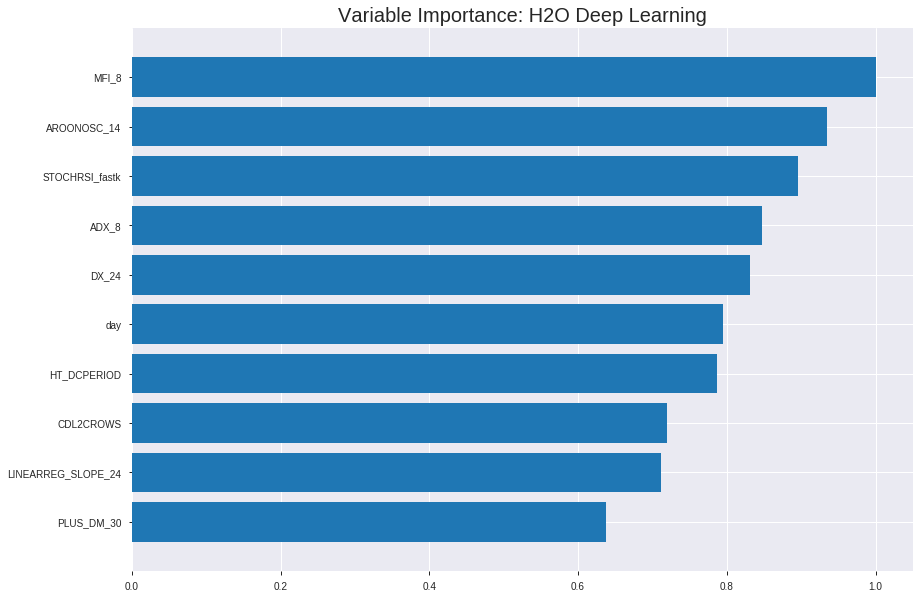

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_142019_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20832673730392082
RMSE: 0.4564282389422469
LogLoss: 0.6014394763825505
Mean Per-Class Error: 0.33139743790032816
AUC: 0.7350765505389784
pr_auc: 0.7300639625340792
Gini: 0.4701531010779567
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27018664726632763: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      282  583   0.674    (583.0/865.0)
1      68   820   0.0766   (68.0/888.0)
Total  350  1403  0.3714   (651.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.270187     0.715845  302
max f2                       0.124365     0.846556  358
max f0point5                 0.547554     0.674603  176
max accuracy                 0.469085     0.669139  214
max precision                0.99918      1         0
max recall                   0.0214822    1         392
max specificity              0.99918      1         0
max absolute_mcc             0.45604      0.339538  221
max min_per_class_accuracy   0.493464     0.663584  201
max mean_per_class_accuracy  0.469085     0.668603  214

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 49.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.987634           1.9741    1.9741             1                0.996368   1                           0.996368            0.0202703       0.0202703                  97.4099   97.4099
    2        0.0205362                   0.965835           1.9741    1.9741             1                0.975512   1                           0.98594             0.0202703       0.0405405                  97.4099   97.4099
    3        0.0302339                   0.946308           1.74185   1.8996             0.882353         0.954862   0.962264                    0.975971            0.0168919       0.0574324                  74.1852   89.9605
    4        0.040502                    0.926692           1.75475   1.86288            0.888889         0.933054   0.943662                    0.965091            0.018018        0.0754505                  75.4755   86.2882
    5        0.0501997                   0.902956           1.74185   1.8395             0.882353         0.915749   0.931818                    0.955559            0.0168919       0.0923423                  74.1852   83.9501
    6        0.100399                    0.827095           1.68247   1.76099            0.852273         0.861101   0.892045                    0.90833             0.0844595       0.176802                   68.2471   76.0986
    7        0.150029                    0.75617            1.33876   1.62131            0.678161         0.787185   0.821293                    0.868255            0.0664414       0.243243                   33.8757   62.1313
    8        0.200228                    0.704967           1.34598   1.55228            0.681818         0.729319   0.786325                    0.833422            0.0675676       0.310811                   34.5977   55.2283
    9        0.300057                    0.618472           1.30855   1.47119            0.662857         0.662678   0.745247                    0.776616            0.130631        0.441441                   30.8546   47.1192
    10       0.399886                    0.553358           1.1619    1.39398            0.588571         0.583774   0.706134                    0.728474            0.115991        0.557432                   16.1898   39.3979
    11       0.500285                    0.493277           1.05435   1.32582            0.534091         0.522282   0.671608                    0.687095            0.105856        0.663288                   5.43484   32.582
    12       0.600114                    0.427797           0.981409  1.26853            0.497143         0.462574   0.642586                    0.649746            0.097973        0.761261                   -1.85907  26.8528
    13       0.699943                    0.357483           0.823481  1.20505            0.417143         0.395503   0.610432                    0.613485            0.0822072       0.843468                   -17.6519  20.5053
    14       0.799772                    0.269216           0.78964   1.1532             0.4              0.317204   0.584165                    0.576502            0.0788288       0.922297                   -21.036   15.3201
    15       0.899601                    0.150316           0.530187  1.08406            0.268571         0.214656   0.549144                    0.536348            0.0529279       0.975225                   -46.9813  8.40646
    16       1                           1.66993e-20        0.246762  1                  0.125            0.0781747  0.50656                     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3022403667609174
RMSE: 0.549763919115212
LogLoss: 0.8757569307738001
Mean Per-Class Error: 0.43059383412383023
AUC: 0.55653121394693
pr_auc: 0.5632776731328397
Gini: 0.1130624278938599
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.032690166675408645: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    224  0.9655   (224.0/232.0)
1      0    269  0        (0.0/269.0)
Total  8    493  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0326902    0.706037  392
max f2                       0.0326902    0.857234  392
max f0point5                 0.367565     0.605318  223
max accuracy                 0.367565     0.57485   223
max precision                0.999791     1         0
max recall                   0.0326902    1         392
max specificity              0.999791     1         0
max absolute_mcc             0.367565     0.140187  223
max min_per_class_accuracy   0.409999     0.565056  197
max mean_per_class_accuracy  0.367565     0.569406  223

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 40.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.992737           1.55204   1.55204            0.833333         0.997564   0.833333                    0.997564            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.978299           0.372491  1.01588            0.2              0.984008   0.545455                    0.991402            0.00371747      0.0223048                  -62.7509  1.58837
    3        0.0319361                   0.951429           0.372491  0.814823           0.2              0.962513   0.4375                      0.982374            0.00371747      0.0260223                  -62.7509  -18.5177
    4        0.0419162                   0.915846           0.744981  0.798194           0.4              0.93597    0.428571                    0.971326            0.00743494      0.0334572                  -25.5019  -20.1806
    5        0.0518962                   0.879256           1.11747   0.859594           0.6              0.900495   0.461538                    0.957704            0.0111524       0.0446097                  11.7472   -14.0406
    6        0.101796                    0.686226           1.34097   1.09556            0.72             0.751499   0.588235                    0.856623            0.0669145       0.111524                   34.0967   9.55609
    7        0.151697                    0.622302           0.81948   1.00474            0.44             0.65566    0.539474                    0.790517            0.0408922       0.152416                   -18.052   0.474467
    8        0.201597                    0.571285           1.04297   1.01421            0.56             0.596024   0.544554                    0.742375            0.0520446       0.204461                   4.2974    1.42074
    9        0.301397                    0.512847           1.15472   1.06074            0.62             0.536126   0.569536                    0.674081            0.115242        0.319703                   15.4721   6.07351
    10       0.401198                    0.463749           1.22922   1.10265            0.66             0.490542   0.59204                     0.628424            0.122677        0.442379                   22.9219   10.2647
    11       0.500998                    0.410008           1.19197   1.12044            0.64             0.435242   0.601594                    0.589942            0.118959        0.561338                   19.197    12.044
    12       0.600798                    0.353308           0.893978  1.08282            0.48             0.381607   0.581395                    0.555335            0.0892193       0.650558                   -10.6022  8.28218
    13       0.700599                    0.254924           0.856729  1.05061            0.46             0.297665   0.564103                    0.51863             0.0855019       0.736059                   -14.3271  5.06148
    14       0.800399                    0.181633           0.931227  1.03573            0.5              0.215654   0.55611                     0.480852            0.0929368       0.828996                   -6.87732  3.57285
    15       0.9002                      0.104283           0.931227  1.02414            0.5              0.139874   0.549889                    0.44305             0.0929368       0.921933                   -6.87732  2.4143
    16       1                           5.62912e-07        0.78223   1                  0.42             0.0600664  0.536926                 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:21:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:21:09  48.986 sec        4974 obs/sec      7         1             12271      0.594288         1.16506             -0.412957      0.518017        0.523768           1.09672          0.49344                          0.661761           1.98971               -0.761316        0.544297          0.575761             1.55204            0.459082
    2019-08-25 14:21:15  54.782 sec        7510 obs/sec      35        5             61355      0.543193         0.894605            -0.180439      0.557122        0.567575           1.53541          0.487735                         0.620985           1.39838               -0.550947        0.539474          0.574557             1.24164            0.453094
    2019-08-25 14:21:20  1 min  0.534 sec  9764 obs/sec      77        11            134981     0.524628         0.78516             -0.101128      0.58216         0.582215           1.53541          0.477467                         0.603472           1.1644                -0.464701        0.541421          0.571692             1.24164            0.453094
    2019-08-25 14:21:26  1 min  5.703 sec  11039 obs/sec     119       17            208607     0.510865         0.742824            -0.0441099     0.610563        0.615153           1.53541          0.463206                         0.590982           1.06005               -0.404702        0.541677          0.567994             1.55204            0.437126
    2019-08-25 14:21:31  1 min 11.143 sec  12148 obs/sec     168       24            294504     0.497295         0.706813            0.0106209      0.644888        0.648899           1.9741           0.428979                         0.580796           1.01961               -0.356696        0.551468          0.577905             1.55204            0.449102
    2019-08-25 14:21:36  1 min 16.397 sec  12940 obs/sec     217       31            380401     0.473644         0.640882            0.102492       0.689202        0.696777           1.9741           0.410724                         0.554863           0.8787                -0.238247        0.537167          0.560754             1.55204            0.457086
    2019-08-25 14:21:41  1 min 21.525 sec  13542 obs/sec     266       38            466298     0.47077          0.64009             0.113348       0.70918         0.708041           1.9741           0.384484                         0.567952           0.949516              -0.297352        0.529876          0.555195             1.55204            0.441118
    2019-08-25 14:21:46  1 min 26.535 sec  14033 obs/sec     315       45            552195     0.460556         0.615084            0.151408       0.726548        0.722108           1.9741           0.380491                         0.555019           0.905207              -0.238941        0.542262          0.56544              1.24164            0.44511
    2019-08-25 14:21:52 

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
MFI_8                    1.0                    1.0                  0.045890084108190024
AROONOSC_14              0.9349775910377502     0.9349775910377502   0.04290620029199525
STOCHRSI_fastk           0.8949781656265259     0.8949781656265259   0.041070623295594896
ADX_8                    0.8465890884399414     0.8465890884399414   0.03885004447358483
DX_24                    0.8307992219924927     0.8307992219924927   0.03812544617425433
---                      ---                    ---                  ---
AVGPRICE                 0.2682025730609894     0.2682025730609894   0.012307838635801783
CDLTASUKIGAP             0.2653968930244446     0.2653968930244446   0.012179085742944072
MA_24_0                  0.2643001973628998     0.2643001973628998   0.012128758286794694
BBANDS_lowerband_24_2_2  0.2574010491371155     0.2574010491371155   0.011812155794438582
MA_30_2                  0.2523469626903534     0.2523469626903534   0.011580223342306607


See the whole table with table.as_data_frame()


('accuracy', 0.5856573705179283)

('F1', 0.6505376344086021)

('auc', 0.5687221869040051)

('logloss', 0.9387653049277119)

('mean_per_class_error', 0.41830896376350923)

('rmse', 0.5428801680162214)

('mse', 0.2947188768253208)

deeplearning prediction progress: |███████████████████████████████████████| 100%


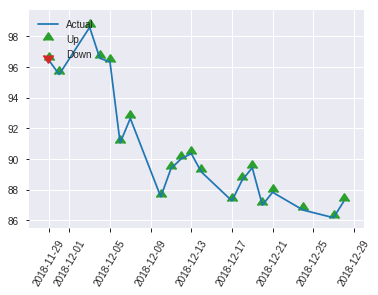


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2947188768253208
RMSE: 0.5428801680162214
LogLoss: 0.9387653049277119
Mean Per-Class Error: 0.41830896376350923
AUC: 0.5687221869040051
pr_auc: 0.5183639696474553
Gini: 0.13744437380801022
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0004433666060124868: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    130  1        (130.0/130.0)
1      0    121  0        (0.0/121.0)
Total  0    251  0.5179   (130.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000443367  0.650538  250
max f2                       0.000443367  0.823129  250
max f0point5                 0.398401     0.565891  130
max accuracy                 0.499184     0.585657  96
max precision                0.499184     0.587629  96
max recall                   0.000443367  1         250
max specificity              0.999842     0.992308  0
max absolute_mcc             0.499184     0.167657  96
max min_per_class_accuracy   0.419811     0.570248  123
max mean_per_class_accuracy  0.499184     0.581691  96

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 45.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.994695           0         0                  0                0.998347   0                           0.998347            0               0                          -100       -100
    2        0.0239044                   0.980026           2.07438   1.03719            1                0.988092   0.5                         0.993219            0.0247934       0.0247934                  107.438    3.71901
    3        0.0318725                   0.963627           1.03719   1.03719            0.5              0.972396   0.5                         0.988013            0.00826446      0.0330579                  3.71901    3.71901
    4        0.0438247                   0.937287           0.69146   0.9429             0.333333         0.943324   0.454545                    0.975825            0.00826446      0.0413223                  -30.854    -5.70999
    5        0.0517928                   0.932567           1.03719   0.957406           0.5              0.934125   0.461538                    0.96941             0.00826446      0.0495868                  3.71901    -4.25938
    6        0.103586                    0.8837             1.11697   1.03719            0.538462         0.909621   0.5                         0.939515            0.0578512       0.107438                   11.6974    3.71901
    7        0.151394                    0.818888           1.03719   1.03719            0.5              0.851354   0.5                         0.911675            0.0495868       0.157025                   3.71901    3.71901
    8        0.203187                    0.756248           1.43611   1.13888            0.692308         0.779117   0.54902                     0.877886            0.0743802       0.231405                   43.6109    13.8875
    9        0.302789                    0.588189           1.16165   1.14637            0.56             0.678745   0.552632                    0.812379            0.115702        0.347107                   16.1653    14.6368
    10       0.40239                     0.488706           1.24463   1.17069            0.6              0.537243   0.564356                    0.744276            0.123967        0.471074                   24.4628    17.069
    11       0.501992                    0.41938            1.07868   1.15243            0.52             0.447234   0.555556                    0.685339            0.107438        0.578512                   7.86777    15.2433
    12       0.601594                    0.336724           0.995702  1.12648            0.48             0.376744   0.543046                    0.634247            0.0991736       0.677686                   -0.429752  12.6485
    13       0.701195                    0.277886           0.746777  1.07255            0.36             0.304586   0.517045                    0.58742             0.0743802       0.752066                   -25.3223   7.25488
    14       0.800797                    0.220318           0.912727  1.05267            0.44             0.246758   0.507463                    0.545049            0.0909091       0.842975                   -8.72727   5.26705
    15       0.900398                    0.126024           0.746777  1.01883            0.36             0.173831   0.49115                     0.503985            0.0743802       0.917355                   -25.3223   1.88327
    16       1                           0.000443367        0.829752  1                  0.4              0.0553384  0.482072    

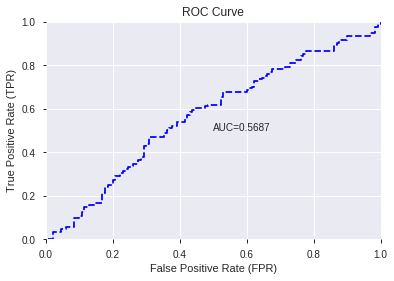

This function is available for GLM models only


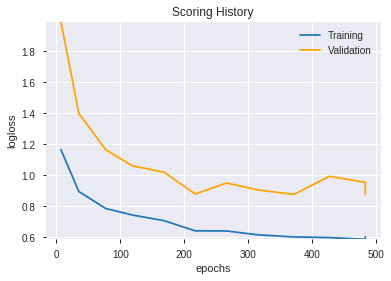

--2019-08-25 14:30:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.41.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.41.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_142019_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_142019_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['MFI_8',
 'AROONOSC_14',
 'STOCHRSI_fastk',
 'ADX_8',
 'DX_24',
 'day',
 'HT_DCPERIOD',
 'CDL2CROWS',
 'LINEARREG_SLOPE_24',
 'PLUS_DM_30',
 'BETA_8',
 'Volume',
 'ROCR100_12',
 'EXP',
 'BBANDS_upperband_30_1_5',
 'ATR_30',
 'BBANDS_upperband_24_7_5',
 'BBANDS_upperband_20_1_5',
 'ATR_12',
 'BBANDS_upperband_8_1_4',
 'BBANDS_upperband_30_0_4',
 'NATR_24',
 'BBANDS_upperband_12_5_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_lowerband_24_3_4',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_lowerband_30_7_3',
 'BBANDS_lowerband_30_6_3',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_upperband_12_0_2',
 'BBANDS_middleband_30_6_2',
 'BBANDS_upperband_8_6_2',
 'BBANDS_lowerband_30_5_2',
 'MA_8_8',
 'BBANDS_upperband_8_4_2',
 'CDLTAKURI',
 'BBANDS_middleband_8_4_3',
 'MA_14_6',
 'BBANDS_middleband_12_5_3',
 'SMA_8',
 'BBANDS_middleband_30_1_3',
 'WMA_8',
 'BBANDS_lowerband_30_2_3',
 'AVGPRICE',
 'CDLTASUKIGAP',
 'MA_24_0',
 'BBANDS_lowerband_24_2_2',
 'MA_30_2'

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_143048_model_1  0.515385  0.692946                   0.5  0.499897  0.249897

variable  relative_importance  scaled_importance  percentage
0                AROONOSC_14             0.048653           1.000000    0.087401
1                 PLUS_DM_30             0.047871           0.983930    0.085996
2         LINEARREG_SLOPE_24             0.046022           0.945935    0.082676
3                        EXP             0.042742           0.878514    0.076783
4                  CDL2CROWS             0.035043           0.720274    0.062953
5                     ATR_12             0.034918           0.717704    0.062728
6                        day             0.029863           0.613798    0.053647
7                      ADX_8             0.029845           0.613423    0.053614
8                  CDLTAKURI             0.023938           0.492026    0.043004
9    BBANDS_upperband_24_7_5             0.023367           0.480287    0.041978
10              CDLTASUKIGAP             0.021830           0.448690    0.039216
11                   NATR_24             0.017688           0.363566    0.031776
12                     DX_24             0.016197           0.332920    0.029098
13               HT_DCPERIOD             0.014825           0.304714    0.026632
14            STOCHRSI_fastk             0.012651           0.260032    0.022727
15   BBANDS_upperband_20_1_5             0.012477           0.256456    0.022415
16   BBANDS_lowerband_24_3_4             0.010995           0.225999    0.019753
17   BBANDS_lowerband_24_5_4             0.010443           0.214649    0.018761
18                    Volume             0.008313           0.170857    0.014933
19   BBANDS_upperband_30_0_4             0.007894           0.162250    0.014181
20                   MA_24_0             0.006378           0.131102    0.011458
21   BBANDS_upperband_30_1_5             0.005291           0.108744    0.009504
22                ROCR100_12             0.005135           0.105534    0.009224
23   BBANDS_lowerband_30_5_2             0.005003           0.102827    0.008987
24   BBANDS_lowerband_24_2_2             0.004767           0.097987    0.008564
25                   MA_30_2             0.004200           0.086321    0.007544
26   BBANDS_lowerband_30_1_5             0.003867           0.079478    0.006946
27   BBANDS_lowerband_14_0_3             0.002513           0.051655    0.004515
28   BBANDS_upperband_12_5_3             0.002264           0.046537    0.004067
29  BBANDS_middleband_30_6_2             0.002255           0.046351    0.004051
30                    BETA_8             0.002195           0.045117    0.003943
31   BBANDS_lowerband_30_7_3             0.002148           0.044140    0.003858
32                    ATR_30             0.001804           0.037089    0.003242
33   BBANDS_upperband_12_0_2             0.001759           0.036161    0.003161
34    BBANDS_upperband_8_6_2             0.001402           0.028827    0.002519
35  BBANDS_middleband_12_5_3             0.001374           0.028242    0.002468
36                  AVGPRICE             0.001359           0.027928    0.002441
37   BBANDS_lowerband_30_2_3             0.001226           0.025197    0.002202
38                     MFI_8             0.000972           0.019984    0.001747
39  BBANDS_middleband_30_1_3             0.000872           0.017926    0.001567
40    BBANDS_lowerband_8_3_2             0.000867           0.017816    0.001557
41   BBANDS_lowerband_30_6_3             0.000781           0.016060    0.001404
42                   MA_14_6             0.000514           0.010559    0.000923
43                    MA_8_8             0.000495           0.010176    0.000889
44    BBANDS_upperband_8_4_2             0.000424           0.008710    0.000761
45                     SMA_8             0.000304           0.006250    0.000546
46   BBANDS_middleband_8_4_3             0.000274           0.005641    0.000493
47   BBANDS_lowerband_12_0_3             0.000244           0.005015    0.000438
48                     WMA_8             0.000238  

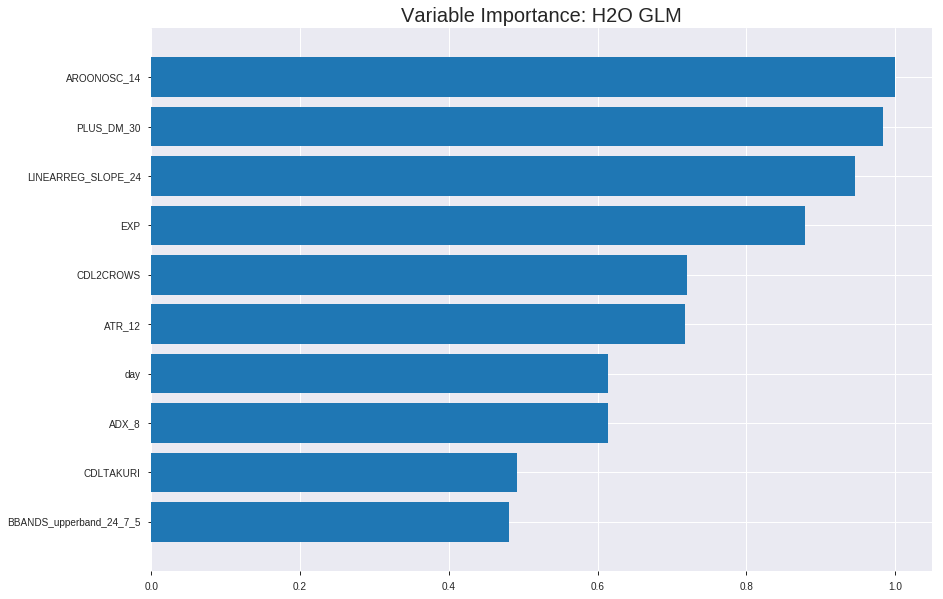

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_143048_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24785960612633232
RMSE: 0.4978550051233113
LogLoss: 0.6887777070465967
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.8722379876026
Residual deviance: 2414.854640905368
AIC: 2516.854640905368
AUC: 0.5476885122116336
pr_auc: 0.5503100274550843
Gini: 0.09537702442326723
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45919424733518244: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      53   812   0.9387   (812.0/865.0)
1      21   867   0.0236   (21.0/888.0)
Total  74   1679  0.4752   (833.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459194     0.675497  353
max f2                       0.416821     0.83821   391
max f0point5                 0.470141     0.574737  326
max accuracy                 0.497338     0.539646  236
max precision                0.792673     1         0
max recall                   0.416821     1         391
max specificity              0.792673     1         0
max absolute_mcc             0.470141     0.10789   326
max min_per_class_accuracy   0.505479     0.532658  202
max mean_per_class_accuracy  0.497338     0.538182  236

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.571183           1.42574   1.42574            0.722222         0.593484  0.722222                    0.593484            0.0146396       0.0146396                  42.5738   42.5738
    2        0.0205362                   0.56443            1.53541   1.48057            0.777778         0.567386  0.75                        0.580435            0.0157658       0.0304054                  53.541    48.0574
    3        0.0302339                   0.560806           1.16123   1.37814            0.588235         0.562577  0.698113                    0.574707            0.0112613       0.0416667                  16.1235   37.8145
    4        0.040502                    0.557887           1.42574   1.39021            0.722222         0.559491  0.704225                    0.570849            0.0146396       0.0563063                  42.5738   39.0211
    5        0.0501997                   0.555805           1.04511   1.32354            0.529412         0.556955  0.670455                    0.568165            0.0101351       0.0664414                  4.51113   32.3544
    6        0.100399                    0.54616            0.942184  1.13286            0.477273         0.550872  0.573864                    0.559519            0.0472973       0.113739                   -5.78163  13.2864
    7        0.150029                    0.539138           1.04378   1.10339            0.528736         0.542533  0.558935                    0.5539              0.0518018       0.165541                   4.37765   10.3394
    8        0.200228                    0.532709           1.00948   1.07985            0.511364         0.536153  0.547009                    0.54945             0.0506757       0.216216                   0.948249  7.98491
    9        0.300057                    0.521286           1.07165   1.07712            0.542857         0.527096  0.545627                    0.542013            0.106982        0.323198                   7.16538   7.71225
    10       0.399886                    0.512931           1.06037   1.07294            0.537143         0.516935  0.543509                    0.535752            0.105856        0.429054                   6.03732   7.29412
    11       0.500285                    0.505224           1.03192   1.06471            0.522727         0.509016  0.539339                    0.530387            0.103604        0.532658                   3.19154   6.4708
    12       0.600114                    0.497913           1.01525   1.05648            0.514286         0.501546  0.535171                    0.525589            0.101351        0.634009                   1.5251    5.64808
    13       0.699943                    0.491372           0.947568  1.04095            0.48             0.494535  0.527302                    0.52116             0.0945946       0.728604                   -5.24324  4.09471
    14       0.799772                    0.481977           0.902445  1.02366            0.457143         0.487014  0.518545                    0.516898            0.0900901       0.818694                   -9.75547  2.36591
    15       0.899601                    0.470191           1.1055    1.03274            0.56             0.476517  0.523145                    0.512417            0.11036         0.929054                   10.5495   3.27405
    16       1                           0.151928           0.706638  1                  0.357955         0.454084  0.50656                     0.50656           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24893284209327418
RMSE: 0.4989317008301579
LogLoss: 0.6909895116615471
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.6487637448975
Residual deviance: 692.3714906848703
AIC: 794.3714906848703
AUC: 0.5346510062812461
pr_auc: 0.5693527909211591
Gini: 0.06930201256249213
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4601062972854683: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   222  0.9569   (222.0/232.0)
1      3    266  0.0112   (3.0/269.0)
Total  13   488  0.4491   (225.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460106     0.702774  386
max f2                       0.439525     0.855054  395
max f0point5                 0.472217     0.606854  357
max accuracy                 0.473306     0.566866  353
max precision                0.54822      1         0
max recall                   0.439525     1         395
max specificity              0.54822      1         0
max absolute_mcc             0.472217     0.129871  357
max min_per_class_accuracy   0.495556     0.521552  202
max mean_per_class_accuracy  0.473306     0.537367  353

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 49.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.541614           1.55204   1.55204            0.833333         0.544025  0.833333                    0.544025            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.536229           0.744981  1.1852             0.4              0.537475  0.636364                    0.541048            0.00743494      0.0260223                  -25.5019  18.5198
    3        0.0319361                   0.532108           1.48996   1.28044            0.8              0.533348  0.6875                      0.538641            0.0148699       0.0408922                  48.9963   28.0437
    4        0.0419162                   0.530047           0.744981  1.15295            0.4              0.530848  0.619048                    0.536786            0.00743494      0.0483271                  -25.5019  15.2947
    5        0.0518962                   0.52838            1.11747   1.14613            0.6              0.529195  0.615385                    0.535326            0.0111524       0.0594796                  11.7472   14.6125
    6        0.101796                    0.523526           1.04297   1.09556            0.56             0.525734  0.588235                    0.530624            0.0520446       0.111524                   4.2974    9.55609
    7        0.151697                    0.515975           1.04297   1.07826            0.56             0.519657  0.578947                    0.527016            0.0520446       0.163569                   4.2974    7.82626
    8        0.201597                    0.512197           1.04297   1.06953            0.56             0.513662  0.574257                    0.523711            0.0520446       0.215613                   4.2974    6.95278
    9        0.301397                    0.505099           1.08022   1.07307            0.58             0.508213  0.576159                    0.518579            0.107807        0.32342                    8.0223    7.30693
    10       0.401198                    0.500921           1.00572   1.05632            0.54             0.502856  0.567164                    0.514668            0.100372        0.423792                   0.572491  5.63169
    11       0.500998                    0.495741           0.968476  1.03882            0.52             0.497783  0.557769                    0.511305            0.0966543       0.520446                   -3.15242  3.88187
    12       0.600798                    0.490778           0.81948   1.00238            0.44             0.493139  0.538206                    0.508287            0.0817844       0.60223                    -18.052   0.238363
    13       0.700599                    0.486417           1.19197   1.02939            0.64             0.488699  0.552707                    0.505497            0.118959        0.72119                    19.197    2.93903
    14       0.800399                    0.480528           0.893978  1.01251            0.48             0.483538  0.543641                    0.502759            0.0892193       0.810409                   -10.6022  1.25059
    15       0.9002                      0.473521           1.22922   1.03653            0.66             0.477118  0.556541                    0.499916            0.122677        0.933086                   22.9219   3.65318
    16       1                           0.353866           0.670483  1                  0.36             0.459865  0.536926                    0.495919        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 14:30:48  0.000 sec   2            2.5       51            1.38359           1.38408
    2019-08-25 14:30:48  0.021 sec   4            1.5       51            1.38288           1.38372
    2019-08-25 14:30:48  0.041 sec   6            0.95      51            1.38202           1.38327
    2019-08-25 14:30:48  0.062 sec   8            0.59      51            1.38102           1.38278
    2019-08-25 14:30:48  0.085 sec   10           0.37      51            1.37993           1.38236
    2019-08-25 14:30:48  0.101 sec   12           0.23      51            1.37877           1.38207
    2019-08-25 14:30:48  0.112 sec   14           0.14      51            1.37756           1.38198
    2019-08-25 14:30:48  0.126 sec   16           0.088     51            1.37631           1.38213
    2019-08-25 14:30:48  0.138 sec   18           0.054     51            1.37504           1.38254
    2019-08-25 14:30:49  0.149 sec   20           0.034     51            1.37379           1.38321
    2019-08-25 14:30:49  0.161 sec   22           0.021     51            1.37264           1.38413
    2019-08-25 14:30:49  0.181 sec   24           0.013     51            1.37161           1.38522

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6505376344086021)

('auc', 0.5153846153846153)

('logloss', 0.6929463387624144)

('mean_per_class_error', 0.46662428480610296)

('rmse', 0.49989691826341875)

('mse', 0.24989692888926315)

glm prediction progress: |████████████████████████████████████████████████| 100%


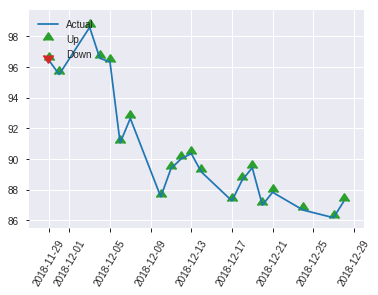


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24989692888926315
RMSE: 0.49989691826341875
LogLoss: 0.6929463387624144
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.2392766240658
Residual deviance: 347.85906205873204
AIC: 449.85906205873204
AUC: 0.5153846153846153
pr_auc: 0.5062469096509339
Gini: 0.03076923076923066
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40890565064365436: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    130  1        (130.0/130.0)
1      0    121  0        (0.0/121.0)
Total  0    251  0.5179   (130.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408906     0.650538  250
max f2                       0.408906     0.823129  250
max f0point5                 0.408906     0.537778  250
max accuracy                 0.538179     0.541833  13
max precision                0.538179     0.714286  13
max recall                   0.408906     1         250
max specificity              0.561897     0.992308  0
max absolute_mcc             0.538179     0.11295   13
max min_per_class_accuracy   0.49695      0.492308  125
max mean_per_class_accuracy  0.511633     0.533376  65

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 49.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.54654            1.38292   1.38292            0.666667         0.552481  0.666667                    0.552481            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.542079           0.69146   1.03719            0.333333         0.543718  0.5                         0.548099            0.00826446      0.0247934                  -30.854    3.71901
    3        0.0318725                   0.540551           2.07438   1.29649            1                0.541511  0.625                       0.546452            0.0165289       0.0413223                  107.438    29.6488
    4        0.0438247                   0.538564           1.38292   1.32006            0.666667         0.539185  0.636364                    0.54447             0.0165289       0.0578512                  38.292     32.006
    5        0.0517928                   0.538221           2.07438   1.43611            1                0.538345  0.692308                    0.543528            0.0165289       0.0743802                  107.438    43.6109
    6        0.103586                    0.531482           0.638271  1.03719            0.307692         0.535006  0.5                         0.539267            0.0330579       0.107438                   -36.1729   3.71901
    7        0.151394                    0.525039           1.38292   1.14637            0.666667         0.527451  0.552632                    0.535535            0.0661157       0.173554                   38.292     14.6368
    8        0.203187                    0.517042           1.11697   1.13888            0.538462         0.521073  0.54902                     0.531849            0.0578512       0.231405                   11.6974    13.8875
    9        0.302789                    0.508813           0.829752  1.03719            0.4              0.512323  0.5                         0.525426            0.0826446       0.31405                    -17.0248   3.71901
    10       0.40239                     0.501984           1.07868   1.04746            0.52             0.504635  0.50495                     0.52028             0.107438        0.421488                   7.86777    4.74593
    11       0.501992                    0.49695            0.746777  0.9878             0.36             0.499091  0.47619                     0.516076            0.0743802       0.495868                   -25.3223   -1.21999
    12       0.601594                    0.492894           0.995702  0.989108           0.48             0.494726  0.476821                    0.512541            0.0991736       0.595041                   -0.429752  -1.08916
    13       0.701195                    0.48708            1.16165   1.01362            0.56             0.489824  0.488636                    0.509314            0.115702        0.710744                   16.1653    1.36176
    14       0.800797                    0.481729           0.995702  1.01139            0.48             0.484039  0.487562                    0.50617             0.0991736       0.809917                   -0.429752  1.13893
    15       0.900398                    0.474334           0.829752  0.991297           0.4              0.477495  0.477876                    0.502998            0.0826446       0.892562                   -17.0248   -0.870328
    16       1                           0.408906           1.07868   1                  0.52             0.460226  0.482072                  

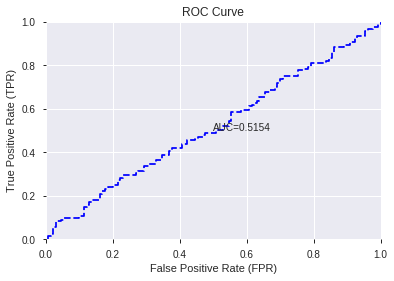

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


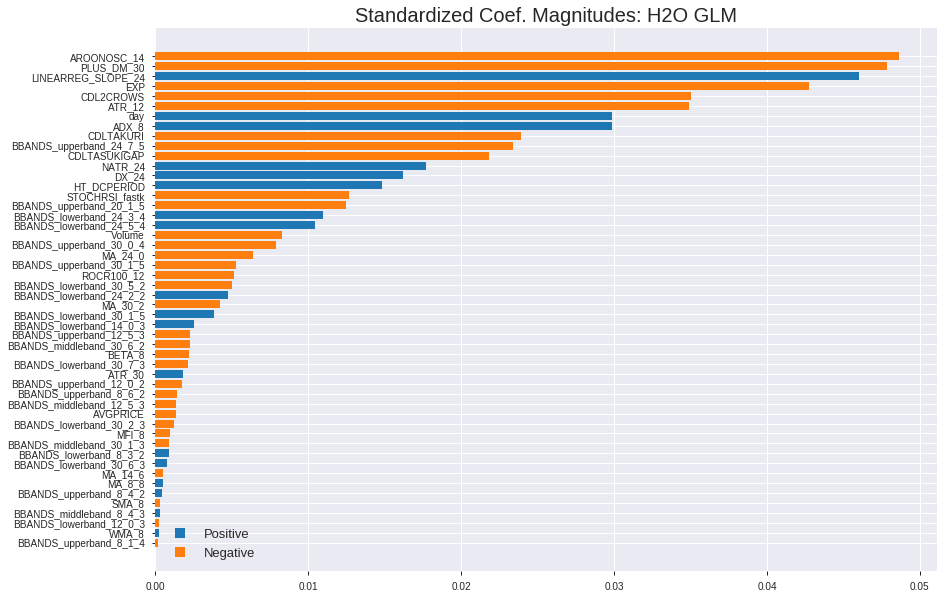

'log_likelihood'
--2019-08-25 14:30:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_143048_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_143048_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['AROONOSC_14',
 'PLUS_DM_30',
 'LINEARREG_SLOPE_24',
 'EXP',
 'CDL2CROWS',
 'ATR_12',
 'day',
 'ADX_8',
 'CDLTAKURI',
 'BBANDS_upperband_24_7_5',
 'CDLTASUKIGAP',
 'NATR_24',
 'DX_24',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'BBANDS_upperband_20_1_5',
 'BBANDS_lowerband_24_3_4',
 'BBANDS_lowerband_24_5_4',
 'Volume',
 'BBANDS_upperband_30_0_4',
 'MA_24_0',
 'BBANDS_upperband_30_1_5',
 'ROCR100_12',
 'BBANDS_lowerband_30_5_2',
 'BBANDS_lowerband_24_2_2',
 'MA_30_2',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_30_6_2',
 'BETA_8',
 'BBANDS_lowerband_30_7_3',
 'ATR_30',
 'BBANDS_upperband_12_0_2',
 'BBANDS_upperband_8_6_2',
 'BBANDS_middleband_12_5_3',
 'AVGPRICE',
 'BBANDS_lowerband_30_2_3',
 'MFI_8',
 'BBANDS_middleband_30_1_3',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_lowerband_30_6_3',
 'MA_14_6',
 'MA_8_8',
 'BBANDS_upperband_8_4_2',
 'SMA_8',
 'BBANDS_middleband_8_4_3',
 'BBANDS_lowerband_12_0_3',
 'WMA_8',
 'BBANDS_upperband_8_1_4'

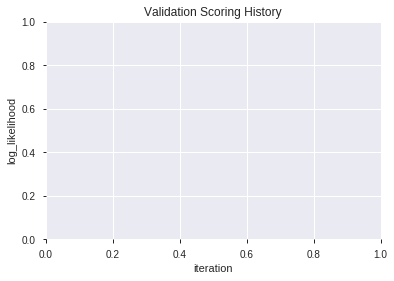

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_143059_model_1  0.528385  0.693056              0.492308  0.499983  0.249983
1  XGBoost_grid_1_AutoML_20190825_143059_model_2  0.525175  0.693179              0.452575  0.500011  0.250011
2  XGBoost_grid_1_AutoML_20190825_143059_model_4  0.523013  0.693164              0.478067  0.499975  0.249975
3               XGBoost_3_AutoML_20190825_143059  0.517864  0.694312              0.473935  0.500595  0.250595
4               XGBoost_1_AutoML_20190825_143059  0.517737  0.699395              0.492308  0.503081  0.253090
5  XGBoost_grid_1_AutoML_20190825_143059_model_6  0.512142  0.699000              0.500000  0.502752  0.252760
6               XGBoost_2_AutoML_20190825_143059  0.495359  0.704225              0.481055  0.505363  0.255392
7  XGBoost_grid_1_AutoML_20190825_143059_model_7  0.489574  0.714485              0.500000  0.509893  0.259991
8  XGBoost_grid_1_AutoML_20190825_143059_model_3  0.469612  0.710721              0.496154  0.508552  0.258625
9  XGBoost_grid_1_AutoML_20190825_143059_model_5  0.469358  0.740504              0.492594  0.521367  0.271824

variable  relative_importance  scaled_importance  percentage
0                     Volume           305.842926           1.000000    0.082570
1                HT_DCPERIOD           214.608047           0.701694    0.057939
2                 PLUS_DM_30           212.964127           0.696319    0.057495
3             STOCHRSI_fastk           210.168518           0.687178    0.056740
4                      ADX_8           182.025879           0.595161    0.049142
5                     ATR_30           175.675140           0.574397    0.047428
6         LINEARREG_SLOPE_24           169.780762           0.555124    0.045837
7    BBANDS_upperband_30_1_5           164.448303           0.537689    0.044397
8                      MFI_8           153.216400           0.500964    0.041365
9                     ATR_12           152.041855           0.497124    0.041048
10                    BETA_8           124.614693           0.407447    0.033643
11                       day           120.050842           0.392525    0.032411
12               AROONOSC_14           103.595123           0.338720    0.027968
13                     DX_24            99.801376           0.326316    0.026944
14                ROCR100_12            99.437622           0.325126    0.026846
15   BBANDS_upperband_24_7_5            98.913223           0.323412    0.026704
16    BBANDS_upperband_8_1_4            94.120743           0.307742    0.025410
17   BBANDS_lowerband_24_5_4            86.615906           0.283204    0.023384
18   BBANDS_upperband_20_1_5            69.583595           0.227514    0.018786
19   BBANDS_lowerband_24_3_4            65.719910           0.214881    0.017743
20   BBANDS_upperband_12_5_3            59.951370           0.196020    0.016185
21   BBANDS_upperband_12_0_2            51.703762           0.169053    0.013959
22    BBANDS_upperband_8_6_2            49.033691           0.160323    0.013238
23                   NATR_24            47.275043           0.154573    0.012763
24    BBANDS_upperband_8_4_2            45.466877           0.148661    0.012275
25   BBANDS_lowerband_30_2_3            40.384914           0.132045    0.010903
26    BBANDS_lowerband_8_3_2            39.684734           0.129755    0.010714
27  BBANDS_middleband_30_1_3            33.096821           0.108215    0.008935
28                       EXP            29.801094           0.097439    0.008046
29   BBANDS_lowerband_30_1_5            29.525730           0.096539    0.007971
30                  AVGPRICE            29.460102           0.096324    0.007953
31   BBANDS_lowerband_30_5_2            29.142654           0.095286    0.007868
32  BBANDS_middleband_30_6_2            28.718668           0.093900    0.007753
33   BBANDS_middleband_8_4_3            26.868984           0.087852    0.007254
34                   MA_30_2            26.815704           0.087678    0.007240
35                     SMA_8            25.572056           0.083612    0.006904
36                   MA_24_0            25.152214           0.082239    0.006790
37                     WMA_8            25.104982           0.082085    0.006778
38   BBANDS_lowerband_30_7_3            24.431744           0.079883    0.006596
39   BBANDS_lowerband_12_0_3            24.151932           0.078968    0.006520
40   BBANDS_upperband_30_0_4            23.783928           0.077765    0.006421
41   BBANDS_lowerband_24_2_2            19.663008           0.064291    0.005309
42                    MA_8_8            19.562218           0.063962    0.005281
43   BBANDS_lowerband_14_0_3            19.347656           0.063260    0.005223
44  BBANDS_middleband_12_5_3            14.886370           0.048673    0.004019
45                   MA_14_6            12.232478           0.039996    0.003302

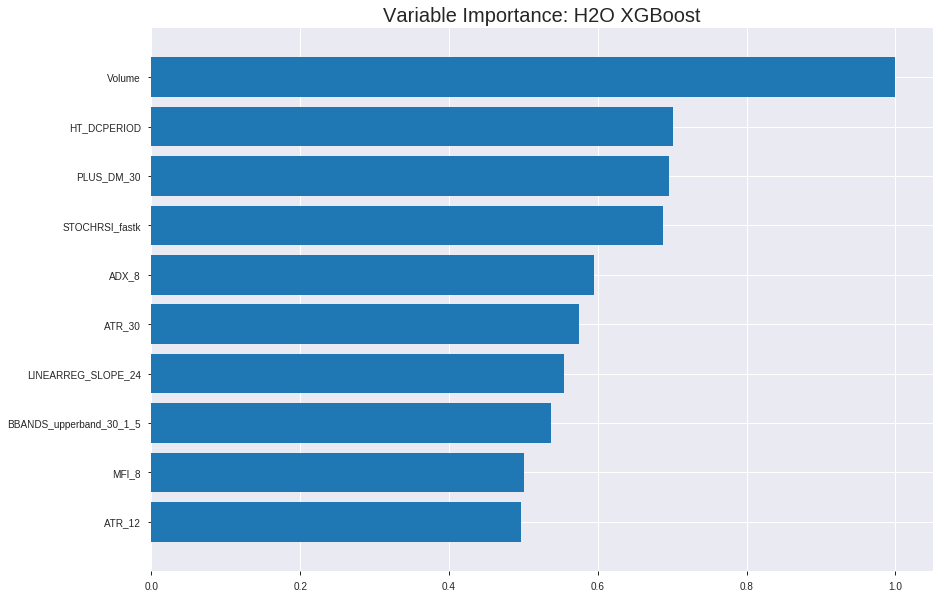

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_143059_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19962363485132298
RMSE: 0.4467926083221644
LogLoss: 0.5902353623869835
Mean Per-Class Error: 0.1706107118679373
AUC: 0.8995267666510441
pr_auc: 0.8976478072126397
Gini: 0.7990535333020883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49013690153757733: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      652  213  0.2462   (213.0/865.0)
1      108  780  0.1216   (108.0/888.0)
Total  760  993  0.1831   (321.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490137     0.829346  222
max f2                       0.46768      0.884461  251
max f0point5                 0.523541     0.853783  180
max accuracy                 0.513973     0.828865  191
max precision                0.790282     1         0
max recall                   0.359987     1         356
max specificity              0.790282     1         0
max absolute_mcc             0.513973     0.660403  191
max min_per_class_accuracy   0.505346     0.824324  202
max mean_per_class_accuracy  0.513973     0.829389  191

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.703936           1.9741    1.9741             1                0.734405  1                           0.734405            0.0202703       0.0202703                  97.4099   97.4099
    2        0.0205362                   0.687664           1.86443   1.91926            0.944444         0.696116  0.972222                    0.715261            0.0191441       0.0394144                  86.4427   91.9263
    3        0.0302339                   0.670908           1.9741    1.93685            1                0.67802   0.981132                    0.703316            0.0191441       0.0585586                  97.4099   93.6852
    4        0.040502                    0.661952           1.75475   1.89069            0.888889         0.665771  0.957746                    0.693797            0.018018        0.0765766                  75.4755   89.0686
    5        0.0501997                   0.651902           1.9741    1.9068             1                0.65679   0.965909                    0.686648            0.0191441       0.0957207                  97.4099   90.68
    6        0.100399                    0.618371           1.9068    1.9068             0.965909         0.633262  0.965909                    0.659955            0.0957207       0.191441                   90.68     90.68
    7        0.150029                    0.596926           1.92872   1.91405            0.977011         0.607629  0.969582                    0.642646            0.0957207       0.287162                   92.8718   91.405
    8        0.200228                    0.579322           1.79464   1.88411            0.909091         0.588223  0.954416                    0.629001            0.0900901       0.377252                   79.4636   88.4112
    9        0.300057                    0.553015           1.6808    1.81647            0.851429         0.565707  0.920152                    0.607943            0.167793        0.545045                   68.0804   81.6471
    10       0.399886                    0.530562           1.60184   1.76289            0.811429         0.542034  0.89301                     0.59149             0.15991         0.704955                   60.184    76.289
    11       0.500285                    0.505677           1.16651   1.64321            0.590909         0.517592  0.832383                    0.57666             0.117117        0.822072                   16.6513   64.3207
    12       0.600114                    0.482655           0.78964   1.50122            0.4              0.49409   0.760456                    0.562924            0.0788288       0.900901                   -21.036   50.1216
    13       0.699943                    0.462471           0.462503  1.35307            0.234286         0.472672  0.685412                    0.550052            0.0461712       0.947072                   -53.7497  35.307
    14       0.799772                    0.436227           0.282014  1.21938            0.142857         0.449251  0.617689                    0.53747             0.0281532       0.975225                   -71.7986  21.9379
    15       0.899601                    0.387242           0.146647  1.10034            0.0742857        0.413767  0.557387                    0.523743            0.0146396       0.989865                   -85.3353  10.0338
    16       1                           0.244176           0.100948  1                  0.0511364        0.347417  0.50656                     0.50604             0.01



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2509628254457737
RMSE: 0.5009619001937908
LogLoss: 0.6951157838523836
Mean Per-Class Error: 0.45498173311113965
AUC: 0.5304287911806178
pr_auc: 0.5509741363804536
Gini: 0.06085758236123562
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3567715585231781: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   219  0.944    (219.0/232.0)
1      5    264  0.0186   (5.0/269.0)
Total  18   483  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356772     0.702128  382
max f2                       0.291495     0.852885  399
max f0point5                 0.396355     0.609995  344
max accuracy                 0.402881     0.572854  342
max precision                0.655697     1         0
max recall                   0.291495     1         399
max specificity              0.655697     1         0
max absolute_mcc             0.396355     0.139397  344
max min_per_class_accuracy   0.493278     0.509294  190
max mean_per_class_accuracy  0.402881     0.545018  342

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 48.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.621247           1.24164   1.24164            0.666667         0.630456  0.666667                    0.630456            0.0148699       0.0148699                  24.1636   24.1636
    2        0.0219561                   0.605255           0.372491  0.84657            0.2              0.609158  0.454545                    0.620775            0.00371747      0.0185874                  -62.7509  -15.343
    3        0.0319361                   0.600193           0.744981  0.814823           0.4              0.601545  0.4375                      0.614765            0.00743494      0.0260223                  -25.5019  -18.5177
    4        0.0419162                   0.593302           1.48996   0.975571           0.8              0.596259  0.52381                     0.610359            0.0148699       0.0408922                  48.9963   -2.44291
    5        0.0518962                   0.584258           1.48996   1.07449            0.8              0.587837  0.576923                    0.606028            0.0148699       0.0557621                  48.9963   7.44924
    6        0.101796                    0.561908           0.81948   0.949486           0.44             0.570618  0.509804                    0.58867             0.0408922       0.0966543                  -18.052   -5.05139
    7        0.151697                    0.549879           1.26647   1.05376            0.68             0.556054  0.565789                    0.577941            0.063197        0.159851                   26.6468   5.37566
    8        0.201597                    0.540985           1.11747   1.06953            0.6              0.544881  0.574257                    0.569758            0.0557621       0.215613                   11.7472   6.95278
    9        0.301397                    0.524373           0.856729  0.999064           0.46             0.532683  0.536424                    0.557481            0.0855019       0.301115                   -14.3271  -0.0935523
    10       0.401198                    0.509531           1.22922   1.05632            0.66             0.517279  0.567164                    0.547481            0.122677        0.423792                   22.9219   5.63169
    11       0.500998                    0.492456           0.856729  1.01656            0.46             0.500275  0.545817                    0.538077            0.0855019       0.509294                   -14.3271  1.65583
    12       0.600798                    0.479322           1.19197   1.0457             0.64             0.485339  0.561462                    0.529317            0.118959        0.628253                   19.197    4.56965
    13       0.700599                    0.462012           0.968476  1.0347             0.52             0.469262  0.555556                    0.520762            0.0966543       0.724907                   -3.15242  3.46964
    14       0.800399                    0.434491           1.00572   1.03108            0.54             0.448281  0.553616                    0.511724            0.100372        0.825279                   0.572491  3.1084
    15       0.9002                      0.391865           1.08022   1.03653            0.58             0.414964  0.556541                    0.500997            0.107807        0.933086                   8.0223    3.65318
    16       1                           0.291495           0.670483  1                  0.36             0.36202   0.536926                    0.487127    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:31:02  0.021 sec   0                  0.5              0.693147            0.5             0                  1                0.49344                          0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-25 14:31:02  0.076 sec   5                  0.491493         0.676237            0.737024        0.732756           1.86443          0.359384                         0.500005           0.693157              0.529235          0.55416              0.931227           0.45509
    2019-08-25 14:31:02  0.111 sec   10                 0.485049         0.663569            0.787277        0.780945           1.86443          0.309184                         0.499686           0.692513              0.530204          0.549099             1.24164            0.451098
    2019-08-25 14:31:02  0.149 sec   15                 0.479521         0.65275             0.804898        0.79918            1.9741           0.282373                         0.499906           0.692967              0.530277          0.552732             0.620818           0.451098
    2019-08-25 14:31:02  0.186 sec   20                 0.47541          0.644738            0.817101        0.812457           1.86443          0.251569                         0.500073           0.693286              0.52277           0.549577             1.24164            0.447106
    2019-08-25 14:31:02  0.222 sec   25                 0.470941         0.63606             0.835121        0.831205           1.86443          0.241301                         0.500486           0.694103              0.515791          0.541754             1.55204            0.44511
    2019-08-25 14:31:02  0.277 sec   30                 0.465095         0.624841            0.858851        0.856612           1.9741           0.208214                         0.500685           0.694533              0.52043           0.548926             1.24164            0.451098
    2019-08-25 14:31:02  0.319 sec   35                 0.460055         0.615238            0.871225        0.869182           1.86443          0.208214                         0.501558           0.696317              0.516488          0.54017              1.06426            0.45509
    2019-08-25 14:31:02  0.358 sec   40                 0.455806         0.607199            0.882018        0.881021           1.9741           0.200799                         0.501904           0.697055              0.518115          0.539023             0.620818           0.45509
    2019-08-25 14:31:03  0.402 sec   45                 0.452216         0.600371            0.887095        0.883823           1.86443          0.188249                         0.501132           0.695478              0.523467          0.547367             0.931227           0.457086
    2019-08-25 14:31:03  0.447 sec   50                 0.446793         0.590235            0.899527        0.897648           1.9741           0.183115                         0.500962           0.695116              0.530429          0.550974             1.24164            0.447106

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
Volume                    305.8429260253906      1.0                  0.08257000958236985
HT_DCPERIOD               214.60804748535156     0.7016936774517228   0.05793885367107709
PLUS_DM_30                212.96412658691406     0.6963186278476622   0.057495035773764094
STOCHRSI_fastk            210.16851806640625     0.6871779602610733   0.05674029076355019
ADX_8                     182.02587890625        0.5951613178430633   0.0491424757173576
---                       ---                    ---                  ---
BBANDS_lowerband_24_2_2   19.663007736206055     0.06429119676475258  0.005308524732927645
MA_8_8                    19.562217712402344     0.06396164844034456  0.005281313924623422
BBANDS_lowerband_14_0_3   19.34765625            0.0632601070799126   0.005223387647770126
BBANDS_middleband_12_5_3  14.886369705200195     0.04867325165455797  0.0040189508555219505
MA_14_6                   12.232478141784668     0.03999594923038745  0.0033024659112090697


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.654054054054054)

('auc', 0.5283852511125239)

('logloss', 0.6930563543304952)

('mean_per_class_error', 0.4375715193897012)

('rmse', 0.4999829713542771)

('mse', 0.24998297164425187)

xgboost prediction progress: |████████████████████████████████████████████| 100%


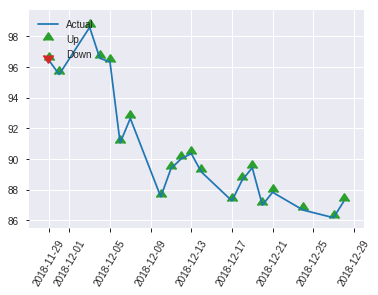


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24998297164425187
RMSE: 0.4999829713542771
LogLoss: 0.6930563543304952
Mean Per-Class Error: 0.4375715193897012
AUC: 0.5283852511125239
pr_auc: 0.5243518442069374
Gini: 0.05677050222504776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3120194971561432: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    128  0.9846   (128.0/130.0)
1      0    121  0        (0.0/121.0)
Total  2    249  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.312019     0.654054  247
max f2                       0.312019     0.825375  247
max f0point5                 0.430628     0.549451  218
max accuracy                 0.549609     0.573705  45
max precision                0.662677     1         0
max recall                   0.312019     1         247
max specificity              0.662677     1         0
max absolute_mcc             0.549609     0.161258  45
max min_per_class_accuracy   0.510272     0.512397  123
max mean_per_class_accuracy  0.549609     0.562428  45

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.630163           2.07438   2.07438            1                0.652833  1                           0.652833            0.0247934       0.0247934                  107.438    107.438
    2        0.0239044                   0.623768           0         1.03719            0                0.625041  0.5                         0.638937            0               0.0247934                  -100       3.71901
    3        0.0318725                   0.596672           1.03719   1.03719            0.5              0.608072  0.5                         0.631221            0.00826446      0.0330579                  3.71901    3.71901
    4        0.0438247                   0.593314           0.69146   0.9429             0.333333         0.59445   0.454545                    0.621192            0.00826446      0.0413223                  -30.854    -5.70999
    5        0.0517928                   0.587493           1.03719   0.957406           0.5              0.588331  0.461538                    0.616137            0.00826446      0.0495868                  3.71901    -4.25938
    6        0.103586                    0.570018           1.59568   1.27654            0.769231         0.575989  0.615385                    0.596063            0.0826446       0.132231                   59.5677    27.6542
    7        0.151394                    0.55266            1.38292   1.31013            0.666667         0.55864   0.631579                    0.584245            0.0661157       0.198347                   38.292     31.0135
    8        0.203187                    0.548356           1.11697   1.2609             0.538462         0.55016   0.607843                    0.575557            0.0578512       0.256198                   11.6974    26.0898
    9        0.302789                    0.535942           0.829752  1.11907            0.4              0.540483  0.539474                    0.564019            0.0826446       0.338843                   -17.0248   11.9074
    10       0.40239                     0.5187             0.829752  1.04746            0.4              0.526872  0.50495                     0.554825            0.0826446       0.421488                   -17.0248   4.74593
    11       0.501992                    0.509725           0.912727  1.02073            0.44             0.514534  0.492063                    0.54683             0.0909091       0.512397                   -8.72727   2.07267
    12       0.601594                    0.497329           0.829752  0.989108           0.4              0.502782  0.476821                    0.539538            0.0826446       0.595041                   -17.0248   -1.08916
    13       0.701195                    0.48277            0.995702  0.990045           0.48             0.489665  0.477273                    0.532453            0.0991736       0.694215                   -0.429752  -0.995492
    14       0.800797                    0.461337           1.07868   1.00107            0.52             0.472083  0.482587                    0.524945            0.107438        0.801653                   7.86777    0.106903
    15       0.900398                    0.420843           1.07868   1.00965            0.52             0.441719  0.486726                    0.515738            0.107438        0.909091                   7.86777    0.965406
    16       1                           0.289983           0.912727  1                  0.44             0.376392  0.482072             

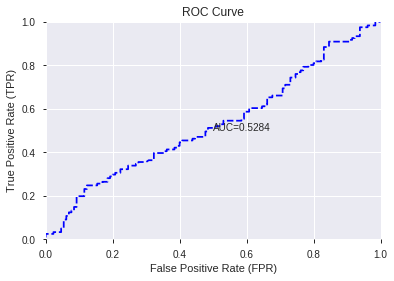

This function is available for GLM models only


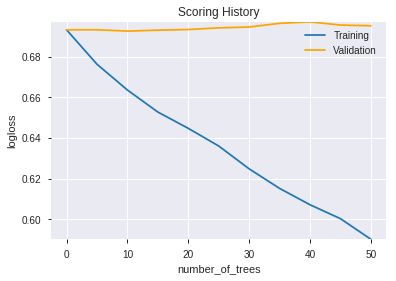

--2019-08-25 14:31:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_143059_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_143059_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'HT_DCPERIOD',
 'PLUS_DM_30',
 'STOCHRSI_fastk',
 'ADX_8',
 'ATR_30',
 'LINEARREG_SLOPE_24',
 'BBANDS_upperband_30_1_5',
 'MFI_8',
 'ATR_12',
 'BETA_8',
 'day',
 'AROONOSC_14',
 'DX_24',
 'ROCR100_12',
 'BBANDS_upperband_24_7_5',
 'BBANDS_upperband_8_1_4',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_upperband_20_1_5',
 'BBANDS_lowerband_24_3_4',
 'BBANDS_upperband_12_5_3',
 'BBANDS_upperband_12_0_2',
 'BBANDS_upperband_8_6_2',
 'NATR_24',
 'BBANDS_upperband_8_4_2',
 'BBANDS_lowerband_30_2_3',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_middleband_30_1_3',
 'EXP',
 'BBANDS_lowerband_30_1_5',
 'AVGPRICE',
 'BBANDS_lowerband_30_5_2',
 'BBANDS_middleband_30_6_2',
 'BBANDS_middleband_8_4_3',
 'MA_30_2',
 'SMA_8',
 'MA_24_0',
 'WMA_8',
 'BBANDS_lowerband_30_7_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_30_0_4',
 'BBANDS_lowerband_24_2_2',
 'MA_8_8',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_middleband_12_5_3',
 'MA_14_6']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_143119_model_1  0.515575  0.691958              0.496154  0.499664  0.249665

variable  relative_importance  scaled_importance    percentage
0                          OBV         2.634592e-02           1.000000  1.515497e-02
1              CDLADVANCEBLOCK         2.465597e-02           0.935855  1.418286e-02
2                    CDLHAMMER         2.328651e-02           0.883876  1.339511e-02
3                  CDLPIERCING         2.218498e-02           0.842065  1.276148e-02
4                       TRANGE         2.161235e-02           0.820330  1.243208e-02
...                        ...                  ...                ...           ...
1034   BBANDS_lowerband_14_5_3         3.605013e-06           0.000137  2.073713e-06
1035  BBANDS_middleband_12_2_3         2.388137e-06           0.000091  1.373729e-06
1036   BBANDS_upperband_14_4_4         2.251411e-06           0.000085  1.295080e-06
1037  BBANDS_middleband_12_2_4         8.047982e-07           0.000031  4.629444e-07
1038  BBANDS_middleband_12_3_4         3.736366e-07           0.000014  2.149271e-07

[1039 rows x 4 columns]

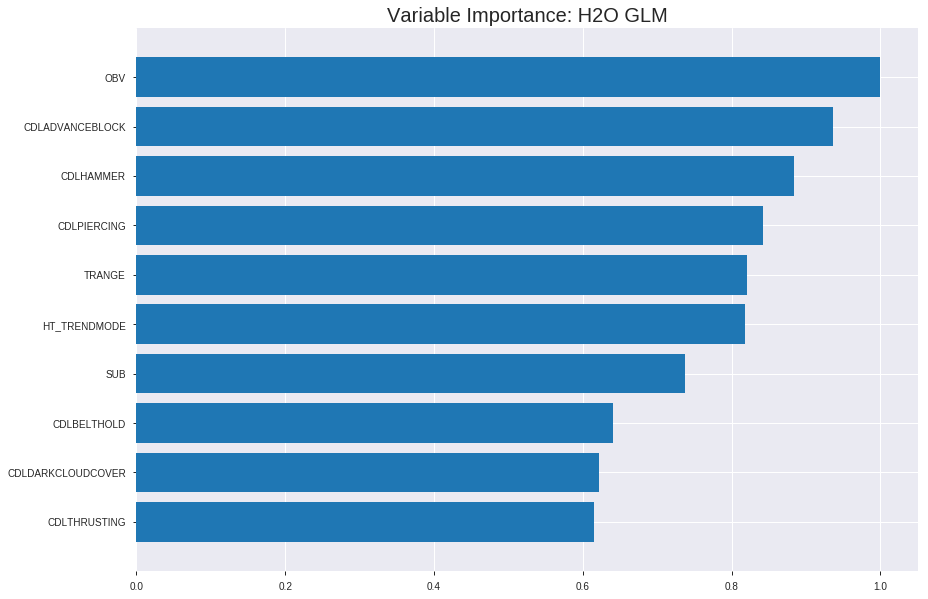

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_143119_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24325043337316413
RMSE: 0.4932042511710175
LogLoss: 0.6795194262979803
Null degrees of freedom: 1752
Residual degrees of freedom: 713
Null deviance: 2429.8722379876026
Residual deviance: 2382.395108600719
AIC: 4462.395108600719
AUC: 0.6118314846638546
pr_auc: 0.60895376232353
Gini: 0.22366296932770924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4339734954866058: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      57   808   0.9341   (808.0/865.0)
1      14   874   0.0158   (14.0/888.0)
Total  71   1682  0.4689   (822.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433973     0.680156  353
max f2                       0.352551     0.837578  395
max f0point5                 0.503486     0.596999  207
max accuracy                 0.504112     0.589846  205
max precision                0.642587     1         0
max recall                   0.352551     1         395
max specificity              0.642587     1         0
max absolute_mcc             0.503486     0.179277  207
max min_per_class_accuracy   0.508382     0.586127  194
max mean_per_class_accuracy  0.504112     0.589289  205

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.600822           1.75475   1.75475            0.888889         0.6136    0.888889                    0.6136              0.018018        0.018018                   75.4755   75.4755
    2        0.0205362                   0.58736            1.53541   1.64508            0.777778         0.594003  0.833333                    0.603802            0.0157658       0.0337838                  53.541    64.5083
    3        0.0302339                   0.577294           1.16123   1.48989            0.588235         0.581917  0.754717                    0.596782            0.0112613       0.045045                   16.1235   48.9886
    4        0.040502                    0.573194           1.64508   1.52923            0.833333         0.574964  0.774648                    0.591251            0.0168919       0.0619369                  64.5083   52.9232
    5        0.0501997                   0.569644           0.812864  1.39084            0.411765         0.571268  0.704545                    0.58739             0.00788288      0.0698198                  -18.7136  39.0843
    6        0.100399                    0.557416           1.30111   1.34598            0.659091         0.563325  0.681818                    0.575358            0.0653153       0.135135                   30.1111   34.5977
    7        0.150029                    0.54746            1.17992   1.29105            0.597701         0.551787  0.653992                    0.567561            0.0585586       0.193694                   17.9921   29.1046
    8        0.200228                    0.541051           1.09921   1.24295            0.556818         0.544074  0.62963                     0.561672            0.0551802       0.248874                   9.92143   24.2951
    9        0.300057                    0.527598           1.11678   1.20097            0.565714         0.533927  0.608365                    0.552441            0.111486        0.36036                    11.6776   20.0973
    10       0.399886                    0.51724            1.09421   1.17432            0.554286         0.522032  0.594864                    0.54485             0.109234        0.469595                   9.42149   17.4321
    11       0.500285                    0.508258           1.14408   1.16825            0.579545         0.512728  0.59179                     0.538403            0.114865        0.584459                   14.408    16.8252
    12       0.600114                    0.498559           0.936287  1.12967            0.474286         0.503419  0.572243                    0.532584            0.0934685       0.677928                   -6.3713   12.9665
    13       0.699943                    0.487736           0.925006  1.10048            0.468571         0.493449  0.557457                    0.527002            0.0923423       0.77027                    -7.49936  10.0476
    14       0.799772                    0.474987           0.868604  1.07153            0.44             0.48113   0.542796                    0.521276            0.0867117       0.856982                   -13.1396  7.15331
    15       0.899601                    0.45552            0.823481  1.04401            0.417143         0.466647  0.528852                    0.515214            0.0822072       0.939189                   -17.6519  4.40068
    16       1                           0.202001           0.605689  1                  0.306818         0.429018  0.50656                     0.50656          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24755436816005988
RMSE: 0.4975483576096497
LogLoss: 0.688200278453807
Null degrees of freedom: 500
Residual degrees of freedom: -539
Null deviance: 693.6487637448975
Residual deviance: 689.5766790107147
AIC: 2769.5766790107145
AUC: 0.5547766312011281
pr_auc: 0.5979077503384402
Gini: 0.10955326240225616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3482705354161763: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    269  0        (0.0/269.0)
Total  1    500  0.4611   (231.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348271     0.69961   398
max f2                       0.348271     0.853426  398
max f0point5                 0.46264      0.603231  330
max accuracy                 0.480478     0.56487   271
max precision                0.711913     1         0
max recall                   0.348271     1         398
max specificity              0.711913     1         0
max absolute_mcc             0.559705     0.128886  31
max min_per_class_accuracy   0.498972     0.546468  201
max mean_per_class_accuracy  0.486649     0.551948  247

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 50.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.584448           1.55204   1.55204            0.833333         0.617708  0.833333                    0.617708            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.573201           1.48996   1.52383            0.8              0.577983  0.818182                    0.599651            0.0148699       0.0334572                  48.9963   52.3826
    3        0.0319361                   0.569175           1.86245   1.62965            1                0.571073  0.875                       0.59072             0.0185874       0.0520446                  86.2454   62.9647
    4        0.0419162                   0.56568            1.11747   1.5077             0.6              0.56739   0.809524                    0.585165            0.0111524       0.063197                   11.7472   50.77
    5        0.0518962                   0.562879           1.48996   1.50429            0.8              0.564167  0.807692                    0.581127            0.0148699       0.0780669                  48.9963   50.4289
    6        0.101796                    0.547673           0.968476  1.24164            0.52             0.556766  0.666667                    0.569186            0.0483271       0.126394                   -3.15242  24.1636
    7        0.151697                    0.541094           0.968476  1.15178            0.52             0.544551  0.618421                    0.561082            0.0483271       0.174721                   -3.15242  15.178
    8        0.201597                    0.53325            0.893978  1.08797            0.48             0.537392  0.584158                    0.555218            0.0446097       0.219331                   -10.6022  8.79679
    9        0.301397                    0.520173           0.968476  1.0484             0.52             0.526921  0.562914                    0.545848            0.0966543       0.315985                   -3.15242  4.8401
    10       0.401198                    0.508651           1.00572   1.03779            0.54             0.514129  0.557214                    0.537958            0.100372        0.416357                   0.572491  3.77851
    11       0.500998                    0.499687           1.26647   1.08334            0.68             0.504121  0.581673                    0.531218            0.126394        0.542751                   26.6468   8.33395
    12       0.600798                    0.489576           1.00572   1.07045            0.54             0.494399  0.574751                    0.525101            0.100372        0.643123                   0.572491  7.04467
    13       0.700599                    0.478542           0.968476  1.05592            0.52             0.48389   0.566952                    0.519231            0.0966543       0.739777                   -3.15242  5.59209
    14       0.800399                    0.46924            0.81948   1.02644            0.44             0.473901  0.551122                    0.513579            0.0817844       0.821561                   -18.052   2.64395
    15       0.9002                      0.45655            0.856729  1.00762            0.46             0.463048  0.54102                     0.507977            0.0855019       0.907063                   -14.3271  0.762453
    16       1                           0.341059           0.931227  1                  0.5              0.4304    0.536926                    0.500234            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 14:31:23  0.000 sec   2            3.7       1040          1.37592           1.38059
    2019-08-25 14:31:25  2.045 sec   4            2.7       1040          1.37354           1.37962
    2019-08-25 14:31:27  4.072 sec   6            2         1040          1.37069           1.37865
    2019-08-25 14:31:29  6.138 sec   8            1.4       1040          1.36732           1.3777
    2019-08-25 14:31:31  8.162 sec   10           1         1040          1.36343           1.37688
    2019-08-25 14:31:33  10.206 sec  12           0.76      1040          1.35904           1.3764
    2019-08-25 14:31:35  12.262 sec  14           0.55      1040          1.35423           1.37645
    2019-08-25 14:31:37  14.350 sec  16           0.4       1040          1.3491            1.37726
    2019-08-25 14:31:39  16.416 sec  18           0.29      1040          1.34377           1.37913
    2019-08-25 14:31:41  18.475 sec  20           0.21      1040          1.33837           1.38228
    2019-08-25 14:31:43  20.548 sec  22           0.15      1040          1.33298           1.38683

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6522911051212937)

('auc', 0.5155753337571519)

('logloss', 0.6919578343718502)

('mean_per_class_error', 0.45238397965670685)

('rmse', 0.4996644857853936)

('mse', 0.24966459835518176)

glm prediction progress: |████████████████████████████████████████████████| 100%


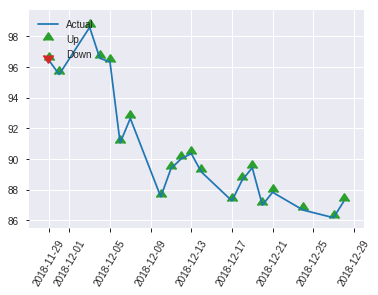


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24966459835518176
RMSE: 0.4996644857853936
LogLoss: 0.6919578343718502
Null degrees of freedom: 250
Residual degrees of freedom: -789
Null deviance: 348.2392766240658
Residual deviance: 347.3628328546688
AIC: 2427.362832854669
AUC: 0.5155753337571519
pr_auc: 0.5047996122876939
Gini: 0.031150667514303843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.423757183932229: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    129  0.9923   (129.0/130.0)
1      0    121  0        (0.0/121.0)
Total  1    250  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423757     0.652291  249
max f2                       0.423757     0.824251  249
max f0point5                 0.445126     0.541028  246
max accuracy                 0.536221     0.557769  53
max precision                0.926857     1         0
max recall                   0.423757     1         249
max specificity              0.926857     1         0
max absolute_mcc             0.536221     0.115802  53
max min_per_class_accuracy   0.508054     0.515385  125
max mean_per_class_accuracy  0.536221     0.547616  53

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 51.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.58412            1.38292   1.38292            0.666667         0.70101   0.666667                    0.70101             0.0165289       0.0165289                  38.292    38.292
    2        0.0239044                   0.577817           0.69146   1.03719            0.333333         0.580264  0.5                         0.640637            0.00826446      0.0247934                  -30.854   3.71901
    3        0.0318725                   0.573952           1.03719   1.03719            0.5              0.576253  0.5                         0.624541            0.00826446      0.0330579                  3.71901   3.71901
    4        0.0438247                   0.57153            1.38292   1.13148            0.666667         0.572504  0.545455                    0.610349            0.0165289       0.0495868                  38.292    13.148
    5        0.0517928                   0.57048            1.03719   1.11697            0.5              0.571251  0.538462                    0.604334            0.00826446      0.0578512                  3.71901   11.6974
    6        0.103586                    0.555411           1.11697   1.11697            0.538462         0.560961  0.538462                    0.582647            0.0578512       0.115702                   11.6974   11.6974
    7        0.151394                    0.547797           1.38292   1.20096            0.666667         0.551564  0.578947                    0.572831            0.0661157       0.181818                   38.292    20.0957
    8        0.203187                    0.540046           1.11697   1.17955            0.538462         0.544205  0.568627                    0.565534            0.0578512       0.239669                   11.6974   17.955
    9        0.302789                    0.528997           0.829752  1.06448            0.4              0.533399  0.513158                    0.554964            0.0826446       0.322314                   -17.0248  6.44846
    10       0.40239                     0.516323           0.912727  1.02692            0.44             0.52263   0.49505                     0.54696             0.0909091       0.413223                   -8.72727  2.69209
    11       0.501992                    0.508054           1.07868   1.03719            0.52             0.511931  0.5                         0.54001             0.107438        0.520661                   7.86777   3.71901
    12       0.601594                    0.501567           0.912727  1.01658            0.44             0.504713  0.490066                    0.534166            0.0909091       0.61157                    -8.72727  1.65837
    13       0.701195                    0.491506           0.829752  0.990045           0.4              0.496425  0.477273                    0.528805            0.0826446       0.694215                   -17.0248  -0.995492
    14       0.800797                    0.482649           1.16165   1.01139            0.56             0.486214  0.487562                    0.523508            0.115702        0.809917                   16.1653   1.13893
    15       0.900398                    0.467115           0.746777  0.982118           0.36             0.476351  0.473451                    0.518291            0.0743802       0.884298                   -25.3223  -1.7882
    16       1                           0.367054           1.16165   1                  0.56             0.451957  0.482072                    0.511684          

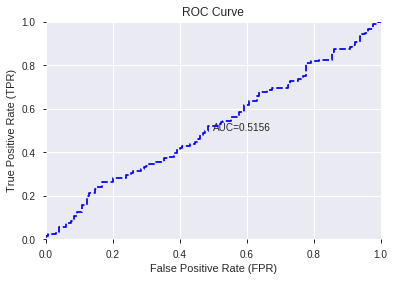

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


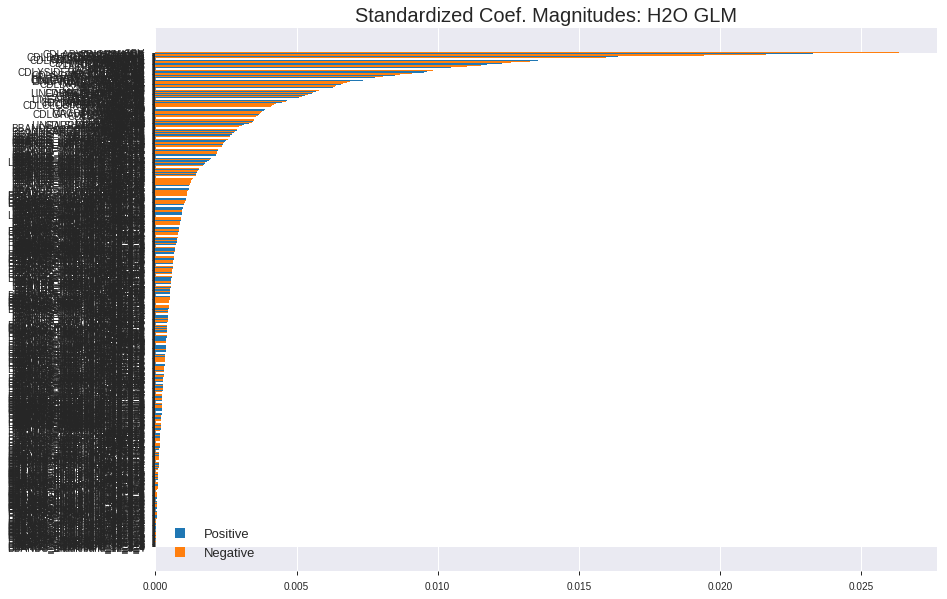

'log_likelihood'
--2019-08-25 14:32:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_143119_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_143119_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

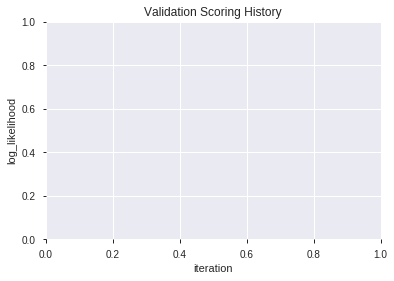

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_143208_model_1  0.535092  0.698286              0.496154  0.502427  0.252433
1  XGBoost_grid_1_AutoML_20190825_143208_model_4  0.523140  0.695379              0.500000  0.501022  0.251023
2  XGBoost_grid_1_AutoML_20190825_143208_model_5  0.521996  0.713785              0.474221  0.509290  0.259376
3  XGBoost_grid_1_AutoML_20190825_143208_model_6  0.514367  0.709189              0.500000  0.507644  0.257702
4               XGBoost_1_AutoML_20190825_143208  0.503433  0.712760              0.500000  0.509062  0.259144
5               XGBoost_3_AutoML_20190825_143208  0.494660  0.707512              0.500000  0.506852  0.256899
6               XGBoost_2_AutoML_20190825_143208  0.479021  0.715368              0.496154  0.510642  0.260755
7  XGBoost_grid_1_AutoML_20190825_143208_model_7  0.477432  0.730414              0.500000  0.517434  0.267738
8  XGBoost_grid_1_AutoML_20190825_143208_model_2  0.469549  0.707953              0.496154  0.507182  0.257234
9  XGBoost_grid_1_AutoML_20190825_143208_model_3  0.465289  0.718940              0.500000  0.512220  0.262369

variable  relative_importance  scaled_importance  percentage
0    BBANDS_upperband_12_6_5           112.144218           1.000000    0.025307
1                  dayofyear           100.141541           0.892971    0.022598
2                  CORREL_20            95.135277           0.848330    0.021468
3                        SUB            90.432587           0.806395    0.020407
4                        BOP            89.697464           0.799840    0.020241
..                       ...                  ...                ...         ...
211   BBANDS_upperband_8_6_5             4.888176           0.043588    0.001103
212                   MFI_30             4.857887           0.043318    0.001096
213              MINUS_DM_20             4.124277           0.036777    0.000931
214  BBANDS_upperband_14_0_5             3.654745           0.032590    0.000825
215   BBANDS_upperband_8_3_3             3.196421           0.028503    0.000721

[216 rows x 4 columns]

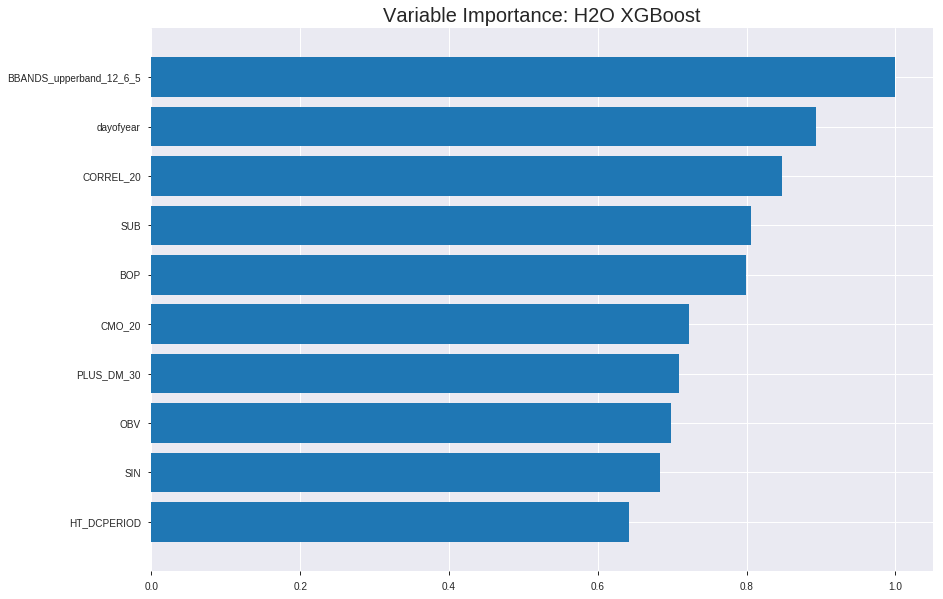

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_143208_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18998557749844877
RMSE: 0.4358733502962171
LogLoss: 0.570002135959613
Mean Per-Class Error: 0.14233778576264133
AUC: 0.9313440608238296
pr_auc: 0.9304554354454947
Gini: 0.8626881216476592
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4918547123670578: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      671  194   0.2243   (194.0/865.0)
1      69   819   0.0777   (69.0/888.0)
Total  740  1013  0.15     (263.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491855     0.861652  214
max f2                       0.4655       0.909763  243
max f0point5                 0.521666     0.872919  178
max accuracy                 0.515693     0.857387  185
max precision                0.790453     1         0
max recall                   0.349177     1         344
max specificity              0.790453     1         0
max absolute_mcc             0.515693     0.715641  185
max min_per_class_accuracy   0.510594     0.850225  191
max mean_per_class_accuracy  0.515693     0.857662  185

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.71454            1.9741     1.9741             1                0.747319  1                           0.747319            0.0202703       0.0202703                  97.4099   97.4099
    2        0.0205362                   0.695773           1.9741     1.9741             1                0.703262  1                           0.725291            0.0202703       0.0405405                  97.4099   97.4099
    3        0.0302339                   0.686504           1.9741     1.9741             1                0.688879  1                           0.713612            0.0191441       0.0596847                  97.4099   97.4099
    4        0.040502                    0.672095           1.9741     1.9741             1                0.679113  1                           0.704866            0.0202703       0.079955                   97.4099   97.4099
    5        0.0501997                   0.66367            1.9741     1.9741             1                0.667713  1                           0.697688            0.0191441       0.0990991                  97.4099   97.4099
    6        0.100399                    0.634466           1.95167    1.96288            0.988636         0.646797  0.994318                    0.672242            0.097973        0.197072                   95.1666   96.2883
    7        0.150029                    0.607486           1.86065    1.92906            0.942529         0.621495  0.977186                    0.655455            0.0923423       0.289414                   86.0645   92.9063
    8        0.200228                    0.588442           1.9068     1.92348            0.965909         0.598364  0.974359                    0.641142            0.0957207       0.385135                   90.68     92.3481
    9        0.300057                    0.557403           1.77105    1.87277            0.897143         0.571898  0.948669                    0.618104            0.176802        0.561937                   77.1049   87.2767
    10       0.399886                    0.534258           1.61312    1.80795            0.817143         0.546279  0.915835                    0.600174            0.161036        0.722973                   61.3121   80.7948
    11       0.500285                    0.511188           1.25624    1.69723            0.636364         0.522503  0.859749                    0.584586            0.126126        0.849099                   25.6245   69.723
    12       0.600114                    0.48655            0.857323   1.55751            0.434286         0.498775  0.788973                    0.570312            0.0855856       0.934685                   -14.2677  55.7512
    13       0.699943                    0.456351           0.39482    1.39168            0.2              0.472167  0.704971                    0.556314            0.0394144       0.974099                   -60.518   39.1684
    14       0.799772                    0.424405           0.19177    1.24191            0.0971429        0.441127  0.629101                    0.541936            0.0191441       0.993243                   -80.823   24.1908
    15       0.899601                    0.373881           0.0564028  1.11035            0.0285714        0.40161   0.56246                     0.526364            0.00563063      0.998874                   -94.3597  11.0353
    16       1                           0.178232           0.0112165  1                  0.00568182       0.324347  0.50656                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24512633905623032
RMSE: 0.4951023521012906
LogLoss: 0.6833136570523473
Mean Per-Class Error: 0.43415107037559286
AUC: 0.568292526599154
pr_auc: 0.5912797963945705
Gini: 0.13658505319830794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30908167362213135: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    229  0.9871   (229.0/232.0)
1      0    269  0        (0.0/269.0)
Total  3    498  0.4571   (229.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309082     0.701434  396
max f2                       0.309082     0.854511  396
max f0point5                 0.487844     0.607369  283
max accuracy                 0.507364     0.57485   245
max precision                0.702319     1         0
max recall                   0.309082     1         396
max specificity              0.702319     1         0
max absolute_mcc             0.507364     0.135773  245
max min_per_class_accuracy   0.529608     0.547414  194
max mean_per_class_accuracy  0.507364     0.565849  245

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 52.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.668301           1.55204   1.55204            0.833333         0.684442  0.833333                    0.684442            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.657529           1.48996   1.52383            0.8              0.6621    0.818182                    0.674286            0.0148699       0.0334572                  48.9963   52.3826
    3        0.0319361                   0.640221           1.11747   1.39684            0.6              0.64201   0.75                        0.6642              0.0111524       0.0446097                  11.7472   39.684
    4        0.0419162                   0.637888           0.744981  1.24164            0.4              0.638393  0.666667                    0.658055            0.00743494      0.0520446                  -25.5019  24.1636
    5        0.0518962                   0.634115           0.744981  1.14613            0.4              0.634622  0.615385                    0.653549            0.00743494      0.0594796                  -25.5019  14.6125
    6        0.101796                    0.609021           0.968476  1.05904            0.52             0.62159   0.568627                    0.637883            0.0483271       0.107807                   -3.15242  5.90422
    7        0.151697                    0.595749           1.41546   1.17629            0.76             0.601639  0.631579                    0.62596             0.070632        0.178439                   41.5465   17.6286
    8        0.201597                    0.584991           1.11747   1.16173            0.6              0.589175  0.623762                    0.616855            0.0557621       0.234201                   11.7472   16.1728
    9        0.301397                    0.565259           1.08022   1.13474            0.58             0.574725  0.609272                    0.602905            0.107807        0.342007                   8.0223    13.474
    10       0.401198                    0.552034           0.968476  1.09338            0.52             0.558086  0.587065                    0.591756            0.0966543       0.438662                   -3.15242  9.33807
    11       0.500998                    0.52976            1.04297   1.08334            0.56             0.54039   0.581673                    0.581524            0.104089        0.542751                   4.2974    8.33395
    12       0.600798                    0.511573           1.11747   1.08901            0.6              0.521594  0.584718                    0.571569            0.111524        0.654275                   11.7472   8.90094
    13       0.700599                    0.497591           0.893978  1.06123            0.48             0.504554  0.569801                    0.562022            0.0892193       0.743494                   -10.6022  6.12271
    14       0.800399                    0.467837           0.893978  1.04037            0.48             0.482505  0.558603                    0.552107            0.0892193       0.832714                   -10.6022  4.0373
    15       0.9002                      0.431378           0.931227  1.02827            0.5              0.449115  0.552106                    0.540689            0.0929368       0.925651                   -6.87732  2.82726
    16       1                           0.302744           0.744981  1                  0.4              0.390539  0.536926                    0.525704            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:32:22  0.011 sec   0                  0.5              0.693147            0.5             0                  1                0.49344                          0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-25 14:32:23  0.614 sec   5                  0.491245         0.675744            0.725385        0.730016           1.7663           0.363948                         0.497384           0.68792               0.544954          0.560088             0.931227           0.441118
    2019-08-25 14:32:23  0.799 sec   10                 0.483665         0.660832            0.789278        0.785979           1.9741           0.309184                         0.496265           0.68568               0.564255          0.569933             0.931227           0.439122
    2019-08-25 14:32:23  0.968 sec   15                 0.478226         0.650166            0.802922        0.795252           1.8702           0.311466                         0.496602           0.686332              0.543568          0.568221             1.06426            0.431138
    2019-08-25 14:32:24  1.136 sec   20                 0.473324         0.640607            0.821025        0.815229           1.9741           0.288078                         0.496557           0.686225              0.547334          0.571483             1.24164            0.437126
    2019-08-25 14:32:24  1.317 sec   25                 0.467419         0.629219            0.844393        0.840887           1.9741           0.239019                         0.496151           0.685384              0.547718          0.582078             1.55204            0.439122
    2019-08-25 14:32:24  1.502 sec   30                 0.461114         0.617141            0.866714        0.866164           1.9741           0.218483                         0.495447           0.683968              0.557453          0.589709             1.86245            0.441118
    2019-08-25 14:32:24  1.691 sec   35                 0.455353         0.606179            0.883386        0.88549            1.9741           0.20308                          0.496125           0.685343              0.551123          0.579742             1.55204            0.443114
    2019-08-25 14:32:24  1.889 sec   40                 0.447998         0.592397            0.905244        0.905104           1.9741           0.183115                         0.496459           0.686041              0.552878          0.576874             1.55204            0.453094
    2019-08-25 14:32:25  2.080 sec   45                 0.442065         0.581404            0.918716        0.918531           1.9741           0.163149                         0.496032           0.685137              0.558142          0.587302             1.55204            0.451098
    2019-08-25 14:32:25  2.275 sec   50                 0.435873         0.570002            0.931344        0.930455           1.9741           0.150029                         0.495102           0.683314              0.568293          0.59128              1.55204            0.457086

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BBANDS_upperband_12_6_5  112.14421844482422     1.0                   0.025306692724062017
dayofyear                100.14154052734375     0.8929710502785672    0.022598143980882637
CORREL_20                95.1352767944336       0.8483297499749473    0.02146842031129635
SUB                      90.43258666992188      0.8063954426185187    0.020407201680430836
BOP                      89.69746398925781      0.7998402880964356    0.020241312399181737
---                      ---                    ---                   ---
BBANDS_upperband_8_6_5   4.888175964355469      0.043588301137079906  0.0011030757432399642
MFI_30                   4.857887268066406      0.043318214130285485  0.001096240734350256
MINUS_DM_20              4.124277114868164      0.03677654695054421   0.0009306927731294624
BBANDS_upperband_14_0_5  3.654745101928711      0.032589688105293384  0.0008247372228536786
BBANDS_upperband_8_3_3   3.196420669555664      0.02850276825575566   0.0007213107980335576


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6522911051212937)

('auc', 0.535092180546726)

('logloss', 0.6982860846886665)

('mean_per_class_error', 0.4514939605848697)

('rmse', 0.5024274490039256)

('mse', 0.25243334151259217)

xgboost prediction progress: |████████████████████████████████████████████| 100%


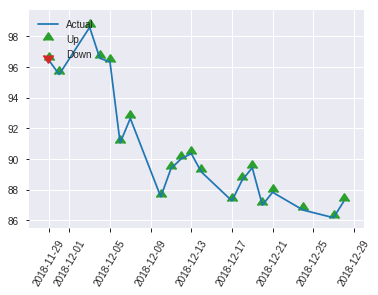


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25243334151259217
RMSE: 0.5024274490039256
LogLoss: 0.6982860846886665
Mean Per-Class Error: 0.4514939605848697
AUC: 0.535092180546726
pr_auc: 0.5081910669568707
Gini: 0.07018436109345205
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31412163376808167: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    129  0.9923   (129.0/130.0)
1      0    121  0        (0.0/121.0)
Total  1    250  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314122     0.652291  249
max f2                       0.314122     0.824251  249
max f0point5                 0.460776     0.548317  199
max accuracy                 0.549087     0.553785  76
max precision                0.668227     0.666667  2
max recall                   0.314122     1         249
max specificity              0.675747     0.992308  0
max absolute_mcc             0.549087     0.101672  76
max min_per_class_accuracy   0.524923     0.512397  115
max mean_per_class_accuracy  0.524923     0.548506  115

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.66691            1.38292   1.38292            0.666667         0.673207  0.666667                    0.673207            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.659396           0         0.69146            0                0.662795  0.333333                    0.668001            0               0.0165289                  -100       -30.854
    3        0.0318725                   0.643198           1.03719   0.777893           0.5              0.648899  0.375                       0.663226            0.00826446      0.0247934                  3.71901    -22.2107
    4        0.0438247                   0.629984           1.38292   0.9429             0.666667         0.637613  0.454545                    0.65624             0.0165289       0.0413223                  38.292     -5.70999
    5        0.0517928                   0.619989           0         0.797839           0                0.6252    0.384615                    0.651465            0               0.0413223                  -100       -20.2161
    6        0.103586                    0.594912           1.43611   1.11697            0.692308         0.603593  0.538462                    0.627529            0.0743802       0.115702                   43.6109    11.6974
    7        0.151394                    0.578266           1.03719   1.09178            0.5              0.588344  0.526316                    0.615155            0.0495868       0.165289                   3.71901    9.1779
    8        0.203187                    0.569701           1.43611   1.17955            0.692308         0.573343  0.568627                    0.604497            0.0743802       0.239669                   43.6109    17.955
    9        0.302789                    0.54917            1.07868   1.14637            0.52             0.557991  0.552632                    0.589199            0.107438        0.347107                   7.86777    14.6368
    10       0.40239                     0.534017           0.912727  1.08854            0.44             0.540877  0.524752                    0.577238            0.0909091       0.438017                   -8.72727   8.85361
    11       0.501992                    0.515996           0.746777  1.02073            0.36             0.525223  0.492063                    0.566918            0.0743802       0.512397                   -25.3223   2.07267
    12       0.601594                    0.501825           1.07868   1.03032            0.52             0.509045  0.496689                    0.557336            0.107438        0.619835                   7.86777    3.03213
    13       0.701195                    0.482515           0.912727  1.01362            0.44             0.491043  0.488636                    0.547919            0.0909091       0.710744                   -8.72727   1.36176
    14       0.800797                    0.460603           1.24463   1.04235            0.6              0.468687  0.502488                    0.538065            0.123967        0.834711                   24.4628    4.23502
    15       0.900398                    0.416395           0.663802  1.00048            0.32             0.438719  0.482301                    0.527075            0.0661157       0.900826                   -33.6198   0.0475389
    16       1                           0.273284           0.995702  1                  0.48             0.368667  0.482072                  

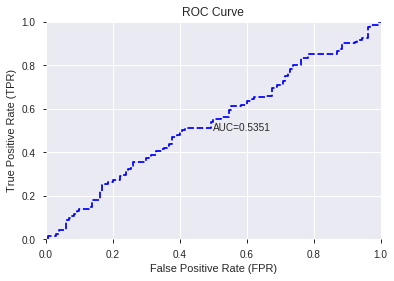

This function is available for GLM models only


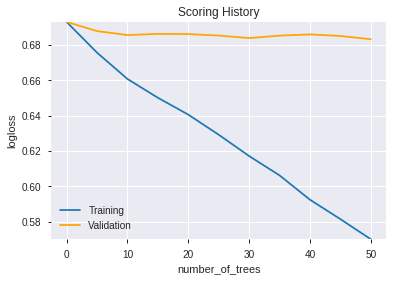

--2019-08-25 14:32:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_143208_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_143208_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190825_143300  0.553338  0.704131              0.488462  0.505034  0.255060
1  DeepLearning_grid_1_AutoML_20190825_143300_model_1  0.545836  1.453853              0.481627  0.615302  0.378597
2  DeepLearning_grid_1_AutoML_20190825_143300_model_3  0.538080  0.772357              0.500000  0.526834  0.277554
3  DeepLearning_grid_1_AutoML_20190825_143300_model_2  0.527781  1.017827              0.471233  0.577561  0.333577
4  DeepLearning_grid_1_AutoML_20190825_143300_model_4  0.522187  0.741275              0.492308  0.517219  0.267516
5  DeepLearning_grid_1_AutoML_20190825_143300_model_6  0.514050  0.693139              0.500000  0.499996  0.249996
6  DeepLearning_grid_1_AutoML_20190825_143300_model_5  0.512206  0.692133              0.477495  0.499498  0.249498
7  DeepLearning_grid_1_AutoML_20190825_143300_model_8  0.500000  0.701178              0.500000  0.503984  0.253999
8  DeepLearning_grid_1_AutoML_20190825_143300_model_7  0.494469  0.754398              0.500000  0.523930  0.274503
9  DeepLearning_grid_1_AutoML_20190825_143300_model_9  0.469294  0.695280              0.492308  0.501065  0.251066

variable  relative_importance  scaled_importance  percentage
0                 PLUS_DM_30             1.000000           1.000000    0.026740
1                    MA_24_0             0.996942           0.996942    0.026658
2    BBANDS_upperband_12_5_3             0.949769           0.949769    0.025396
3                 ROCR100_12             0.931133           0.931133    0.024898
4                     ATR_30             0.925627           0.925627    0.024751
5    BBANDS_lowerband_30_5_2             0.901169           0.901169    0.024097
6    BBANDS_middleband_8_4_3             0.900348           0.900348    0.024075
7                        day             0.892789           0.892789    0.023873
8    BBANDS_lowerband_12_0_3             0.889201           0.889201    0.023777
9     BBANDS_upperband_8_4_2             0.879994           0.879994    0.023531
10   BBANDS_upperband_20_1_5             0.875861           0.875861    0.023420
11   BBANDS_upperband_30_0_4             0.873183           0.873183    0.023349
12                       EXP             0.856701           0.856701    0.022908
13  BBANDS_middleband_30_1_3             0.842999           0.842999    0.022541
14                 CDLTAKURI             0.828732           0.828732    0.022160
15               HT_DCPERIOD             0.812327           0.812327    0.021721
16              CDLTASUKIGAP             0.796093           0.796093    0.021287
17   BBANDS_lowerband_24_2_2             0.795864           0.795864    0.021281
18   BBANDS_upperband_30_1_5             0.780486           0.780486    0.020870
19    BBANDS_upperband_8_1_4             0.768225           0.768225    0.020542
20   BBANDS_lowerband_30_2_3             0.761127           0.761127    0.020352
21        LINEARREG_SLOPE_24             0.759229           0.759229    0.020301
22    BBANDS_lowerband_8_3_2             0.759088           0.759088    0.020298
23               AROONOSC_14             0.752768           0.752768    0.020129
24                   MA_30_2             0.742989           0.742989    0.019867
25   BBANDS_lowerband_14_0_3             0.732523           0.732523    0.019587
26                     WMA_8             0.728871           0.728871    0.019490
27   BBANDS_lowerband_24_5_4             0.726135           0.726135    0.019417
28                     SMA_8             0.725209           0.725209    0.019392
29                    BETA_8             0.722951           0.722951    0.019331
30                    Volume             0.719424           0.719424    0.019237
31                   MA_14_6             0.718388           0.718388    0.019209
32   BBANDS_lowerband_30_6_3             0.711746           0.711746    0.019032
33                    MA_8_8             0.709850           0.709850    0.018981
34            STOCHRSI_fastk             0.705247           0.705247    0.018858
35                   NATR_24             0.683682           0.683682    0.018281
36   BBANDS_lowerband_24_3_4             0.683592           0.683592    0.018279
37   BBANDS_upperband_24_7_5             0.661798           0.661798    0.017696
38                     ADX_8             0.643195           0.643195    0.017199
39                     MFI_8             0.635981           0.635981    0.017006
40                  AVGPRICE             0.635894           0.635894    0.017004
41                 CDL2CROWS             0.613177           0.613177    0.016396
42  BBANDS_middleband_12_5_3             0.601396           0.601396    0.016081
43   BBANDS_upperband_12_0_2             0.585411           0.585411    0.015654
44   BBANDS_lowerband_30_7_3             0.585153           0.585153    0.015647
45                     DX_24             0.577499           0.577499    0.015442
46    BBANDS_upperband_8_6_2             0.554824           0.554824    0.014836
47                    ATR_12             0.539452           0.539452    0.014425
48  BBANDS_middleband_30_6_2             0.537249  

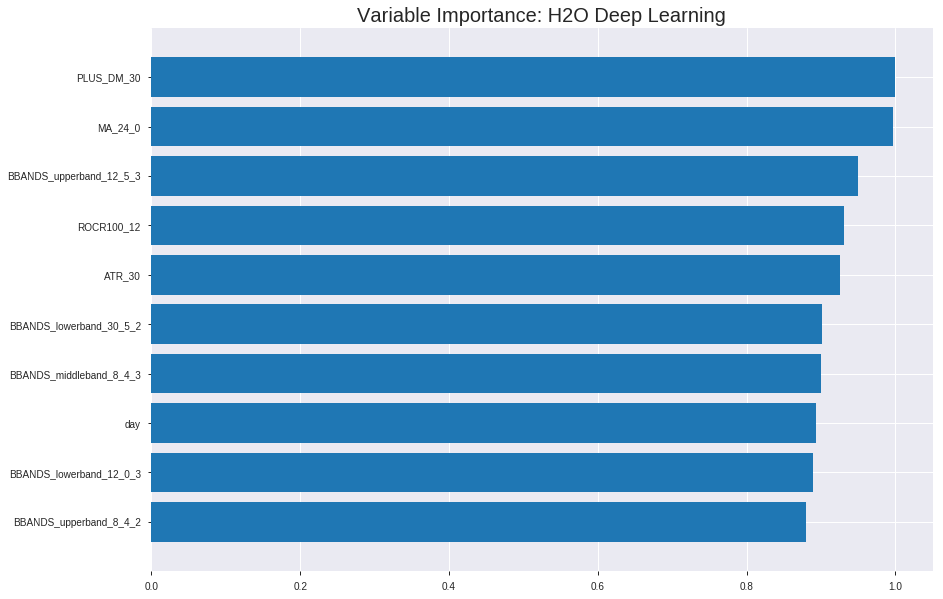

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190825_143300


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25376123538421635
RMSE: 0.5037471939219278
LogLoss: 0.7019709827740286
Mean Per-Class Error: 0.43651057126490656
AUC: 0.5843136489090246
pr_auc: 0.5876170336065758
Gini: 0.1686272978180492
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16239295252239888: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      13   852   0.985    (852.0/865.0)
1      0    888   0        (0.0/888.0)
Total  13   1740  0.486    (852.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.162393     0.675799  387
max f2                       0.162393     0.839002  387
max f0point5                 0.320518     0.579937  295
max accuracy                 0.429171     0.562464  199
max precision                0.852858     1         0
max recall                   0.162393     1         387
max specificity              0.852858     1         0
max absolute_mcc             0.429171     0.128513  199
max min_per_class_accuracy   0.405675     0.551802  219
max mean_per_class_accuracy  0.429171     0.563489  199

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 42.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.773837           1.53541   1.53541            0.777778         0.802265  0.777778                    0.802265            0.0157658       0.0157658                  53.541     53.541
    2        0.0205362                   0.73852            1.20639   1.3709             0.611111         0.753226  0.694444                    0.777746            0.0123874       0.0281532                  20.6394    37.0902
    3        0.0302339                   0.717449           1.74185   1.48989            0.882353         0.726473  0.754717                    0.7613              0.0168919       0.045045                   74.1852    48.9886
    4        0.040502                    0.703082           1.31607   1.44582            0.666667         0.709824  0.732394                    0.74825             0.0135135       0.0585586                  31.6066    44.5819
    5        0.0501997                   0.688385           1.39348   1.43571            0.705882         0.694847  0.727273                    0.737933            0.0135135       0.0720721                  39.3482    43.5708
    6        0.100399                    0.624429           1.16651   1.30111            0.590909         0.653112  0.659091                    0.695523            0.0585586       0.130631                   16.6513    30.1111
    7        0.150029                    0.579561           1.15723   1.25352            0.586207         0.603372  0.634981                    0.665039            0.0574324       0.188063                   15.7231    25.3515
    8        0.200228                    0.546058           1.05435   1.20358            0.534091         0.563034  0.609687                    0.639465            0.0529279       0.240991                   5.43484    20.3582
    9        0.300057                    0.483973           1.02653   1.14468            0.52             0.511871  0.579848                    0.597015            0.102477        0.343468                   2.65315    14.4677
    10       0.399886                    0.435414           1.1619    1.14898            0.588571         0.458701  0.582026                    0.562486            0.115991        0.459459                   16.1898    14.8976
    11       0.500285                    0.405216           0.919751  1.10297            0.465909         0.420174  0.558723                    0.533926            0.0923423       0.551802                   -8.02493   10.2974
    12       0.600114                    0.375719           1.00397   1.08651            0.508571         0.390508  0.55038                     0.510069            0.100225        0.652027                   0.39704    8.65051
    13       0.699943                    0.347109           0.99269   1.07312            0.502857         0.362093  0.543602                    0.488964            0.0990991       0.751126                   -0.731017  7.31248
    14       0.799772                    0.314311           0.947568  1.05745            0.48             0.331004  0.535663                    0.469247            0.0945946       0.845721                   -5.24324   5.74525
    15       0.899601                    0.263779           0.846042  1.03399            0.428571         0.291745  0.523779                    0.449549            0.0844595       0.93018                    -15.3958   3.39923
    16       1                           0.000515896        0.695421  1                  0.352273         0.219188  0.50656                     0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2736099704073377
RMSE: 0.5230774038393722
LogLoss: 0.744170110150259
Mean Per-Class Error: 0.4675522368927061
AUC: 0.52527720805025
pr_auc: 0.5696368879125113
Gini: 0.050554416100500044
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18241846131320744: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    228  0.9828   (228.0/232.0)
1      1    268  0.0037   (1.0/269.0)
Total  5    496  0.4571   (229.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.182418     0.700654  394
max f2                       0.175274     0.853968  397
max f0point5                 0.242068     0.597254  377
max accuracy                 0.265656     0.548902  360
max precision                0.730475     1         0
max recall                   0.175274     1         397
max specificity              0.730475     1         0
max absolute_mcc             0.630983     0.111828  8
max min_per_class_accuracy   0.380889     0.530172  201
max mean_per_class_accuracy  0.378538     0.532448  204

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 39.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.670572           1.86245   1.86245            1                0.69448   1                           0.69448             0.0223048       0.0223048                  86.2454   86.2454
    2        0.0219561                   0.630983           1.48996   1.69314            0.8              0.64805   0.909091                    0.673375            0.0148699       0.0371747                  48.9963   69.314
    3        0.0319361                   0.608237           0         1.16403            0                0.616746  0.625                       0.655678            0               0.0371747                  -100      16.4033
    4        0.0419162                   0.589795           1.48996   1.24164            0.8              0.594049  0.666667                    0.641005            0.0148699       0.0520446                  48.9963   24.1636
    5        0.0518962                   0.578555           1.11747   1.21776            0.6              0.581515  0.653846                    0.629564            0.0111524       0.063197                   11.7472   21.7758
    6        0.101796                    0.517764           0.893978  1.05904            0.48             0.546561  0.568627                    0.588876            0.0446097       0.107807                   -10.6022  5.90422
    7        0.151697                    0.488032           0.968476  1.02925            0.52             0.498752  0.552632                    0.55923             0.0483271       0.156134                   -3.15242  2.92506
    8        0.201597                    0.466262           1.19197   1.06953            0.64             0.47909   0.574257                    0.539393            0.0594796       0.215613                   19.197    6.95278
    9        0.301397                    0.429289           1.04297   1.06074            0.56             0.445405  0.569536                    0.508272            0.104089        0.319703                   4.2974    6.07351
    10       0.401198                    0.404628           1.00572   1.04705            0.54             0.416978  0.562189                    0.485562            0.100372        0.420074                   0.572491  4.7051
    11       0.500998                    0.381395           1.08022   1.05366            0.58             0.39281   0.565737                    0.467085            0.107807        0.527881                   8.0223    5.3659
    12       0.600798                    0.362804           0.931227  1.03332            0.5              0.371584  0.554817                    0.451221            0.0929368       0.620818                   -6.87732  3.33214
    13       0.700599                    0.342053           0.856729  1.00817            0.46             0.350564  0.541311                    0.436883            0.0855019       0.70632                    -14.3271  0.816573
    14       0.800399                    0.315242           1.00572   1.00786            0.54             0.330603  0.541147                    0.423631            0.100372        0.806691                   0.572491  0.786139
    15       0.9002                      0.272319           1.04297   1.01175            0.56             0.294102  0.543237                    0.409271            0.104089        0.910781                   4.2974    1.17541
    16       1                           0.0106715          0.893978  1                  0.48             0.231364  0.536926                    0.391515          


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:33:00  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:33:00  0.053 sec   83476 obs/sec     1         1             1753       0.541184         0.809015            -0.17172       0.535524        0.537372           1.09672          0.487165                         0.575876           0.90529               -0.333806        0.529019          0.570776             1.55204            0.43513
    2019-08-25 14:33:00  0.256 sec   85931 obs/sec     10        10            17530      0.503747         0.701971            -0.0152197     0.584314        0.587617           1.53541          0.486024                         0.523077           0.74417               -0.100442        0.525277          0.569637             1.86245            0.457086

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
PLUS_DM_30                1.0                    1.0                  0.026739532412707722
MA_24_0                   0.9969419240951538     0.9969419240951538   0.02665776089292957
BBANDS_upperband_12_5_3   0.9497689604759216     0.9497689604759216   0.025396377903229628
ROCR100_12                0.9311331510543823     0.9311331510543823   0.024898065073165332
ATR_30                    0.9256271123886108     0.9256271123886108   0.024750836173796312
---                       ---                    ---                  ---
DX_24                     0.5774987936019897     0.5774987936019897   0.015442047709820012
BBANDS_upperband_8_6_2    0.5548238754272461     0.5548238754272461   0.014835731000330959
ATR_12                    0.539452075958252      0.539452075958252    0.014424696270188147
BBANDS_middleband_30_6_2  0.5372490882873535     0.5372490882873535   0.014365789409957362
BBANDS_lowerband_30_1_5   0.3865208625793457     0.3865208625793457   0.010335387133128163


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6558265582655827)

('auc', 0.5533375715193897)

('logloss', 0.7041312022151904)

('mean_per_class_error', 0.4353782581055309)

('rmse', 0.5050343035102121)

('mse', 0.255059647722045)

deeplearning prediction progress: |███████████████████████████████████████| 100%


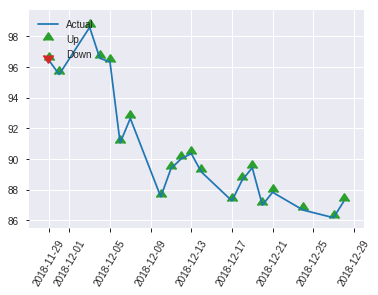


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.255059647722045
RMSE: 0.5050343035102121
LogLoss: 0.7041312022151904
Mean Per-Class Error: 0.4353782581055309
AUC: 0.5533375715193897
pr_auc: 0.5136590495401797
Gini: 0.10667514303877934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2619934215725296: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    127  0.9769   (127.0/130.0)
1      0    121  0        (0.0/121.0)
Total  3    248  0.506    (127.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.261993     0.655827  247
max f2                       0.261993     0.826503  247
max f0point5                 0.387254     0.556348  144
max accuracy                 0.387254     0.561753  144
max precision                0.610651     0.625     7
max recall                   0.261993     1         247
max specificity              0.738895     0.992308  0
max absolute_mcc             0.387254     0.130748  144
max min_per_class_accuracy   0.403361     0.545455  124
max mean_per_class_accuracy  0.387254     0.564622  144

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 41.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.693482           0.69146   0.69146            0.333333         0.720277  0.333333                    0.720277            0.00826446      0.00826446                 -30.854    -30.854
    2        0.0239044                   0.618574           1.38292   1.03719            0.666667         0.654893  0.5                         0.687585            0.0165289       0.0247934                  38.292     3.71901
    3        0.0318725                   0.610153           2.07438   1.29649            1                0.612927  0.625                       0.668921            0.0165289       0.0413223                  107.438    29.6488
    4        0.0438247                   0.608329           0.69146   1.13148            0.333333         0.608966  0.545455                    0.652569            0.00826446      0.0495868                  -30.854    13.148
    5        0.0517928                   0.588106           1.03719   1.11697            0.5              0.597098  0.538462                    0.644035            0.00826446      0.0578512                  3.71901    11.6974
    6        0.103586                    0.523536           0.957406  1.03719            0.461538         0.551698  0.5                         0.597867            0.0495868       0.107438                   -4.25938   3.71901
    7        0.151394                    0.49906            1.21006   1.09178            0.583333         0.512026  0.526316                    0.570759            0.0578512       0.165289                   21.0055    9.1779
    8        0.203187                    0.477339           1.27654   1.13888            0.615385         0.487099  0.54902                     0.549434            0.0661157       0.231405                   27.6542    13.8875
    9        0.302789                    0.447442           0.995702  1.09178            0.48             0.462156  0.526316                    0.520724            0.0991736       0.330579                   -0.429752  9.1779
    10       0.40239                     0.421076           1.07868   1.08854            0.52             0.432985  0.524752                    0.499007            0.107438        0.438017                   7.86777    8.85361
    11       0.501992                    0.401878           1.07868   1.08658            0.52             0.410899  0.52381                     0.481525            0.107438        0.545455                   7.86777    8.65801
    12       0.601594                    0.384521           1.07868   1.08527            0.52             0.392822  0.523179                    0.466839            0.107438        0.652893                   7.86777    8.52717
    13       0.701195                    0.367081           0.746777  1.03719            0.36             0.375809  0.5                         0.453909            0.0743802       0.727273                   -25.3223   3.71901
    14       0.800797                    0.339763           1.07868   1.04235            0.52             0.354627  0.502488                    0.44156             0.107438        0.834711                   7.86777    4.23502
    15       0.900398                    0.303224           0.746777  1.00965            0.36             0.322061  0.486726                    0.428341            0.0743802       0.909091                   -25.3223   0.965406
    16       1                           0.225394           0.912727  1                  0.44             0.280351  0.482072                    0.

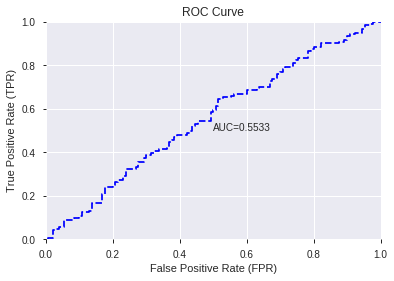

This function is available for GLM models only


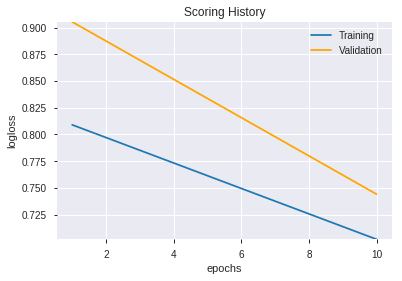

--2019-08-25 14:44:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190825_143300',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190825_143300',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_b594'

['PLUS_DM_30',
 'MA_24_0',
 'BBANDS_upperband_12_5_3',
 'ROCR100_12',
 'ATR_30',
 'BBANDS_lowerband_30_5_2',
 'BBANDS_middleband_8_4_3',
 'day',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_8_4_2',
 'BBANDS_upperband_20_1_5',
 'BBANDS_upperband_30_0_4',
 'EXP',
 'BBANDS_middleband_30_1_3',
 'CDLTAKURI',
 'HT_DCPERIOD',
 'CDLTASUKIGAP',
 'BBANDS_lowerband_24_2_2',
 'BBANDS_upperband_30_1_5',
 'BBANDS_upperband_8_1_4',
 'BBANDS_lowerband_30_2_3',
 'LINEARREG_SLOPE_24',
 'BBANDS_lowerband_8_3_2',
 'AROONOSC_14',
 'MA_30_2',
 'BBANDS_lowerband_14_0_3',
 'WMA_8',
 'BBANDS_lowerband_24_5_4',
 'SMA_8',
 'BETA_8',
 'Volume',
 'MA_14_6',
 'BBANDS_lowerband_30_6_3',
 'MA_8_8',
 'STOCHRSI_fastk',
 'NATR_24',
 'BBANDS_lowerband_24_3_4',
 'BBANDS_upperband_24_7_5',
 'ADX_8',
 'MFI_8',
 'AVGPRICE',
 'CDL2CROWS',
 'BBANDS_middleband_12_5_3',
 'BBANDS_upperband_12_0_2',
 'BBANDS_lowerband_30_7_3',
 'DX_24',
 'BBANDS_upperband_8_6_2',
 'ATR_12',
 'BBANDS_middleband_30_6_2',
 'BBANDS_lowerband_30_1_5'

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_144414_model_1  0.515385  0.692946                   0.5  0.499897  0.249897

variable  relative_importance  scaled_importance  percentage
0                AROONOSC_14             0.048653           1.000000    0.087401
1                 PLUS_DM_30             0.047871           0.983930    0.085996
2         LINEARREG_SLOPE_24             0.046022           0.945935    0.082676
3                        EXP             0.042742           0.878514    0.076783
4                  CDL2CROWS             0.035043           0.720274    0.062953
5                     ATR_12             0.034918           0.717704    0.062728
6                        day             0.029863           0.613798    0.053647
7                      ADX_8             0.029845           0.613423    0.053614
8                  CDLTAKURI             0.023938           0.492026    0.043004
9    BBANDS_upperband_24_7_5             0.023367           0.480287    0.041978
10              CDLTASUKIGAP             0.021830           0.448690    0.039216
11                   NATR_24             0.017688           0.363566    0.031776
12                     DX_24             0.016197           0.332920    0.029098
13               HT_DCPERIOD             0.014825           0.304714    0.026632
14            STOCHRSI_fastk             0.012651           0.260032    0.022727
15   BBANDS_upperband_20_1_5             0.012477           0.256456    0.022415
16   BBANDS_lowerband_24_3_4             0.010995           0.225999    0.019753
17   BBANDS_lowerband_24_5_4             0.010443           0.214649    0.018761
18                    Volume             0.008313           0.170857    0.014933
19   BBANDS_upperband_30_0_4             0.007894           0.162250    0.014181
20                   MA_24_0             0.006378           0.131102    0.011458
21   BBANDS_upperband_30_1_5             0.005291           0.108744    0.009504
22                ROCR100_12             0.005135           0.105534    0.009224
23   BBANDS_lowerband_30_5_2             0.005003           0.102827    0.008987
24   BBANDS_lowerband_24_2_2             0.004767           0.097987    0.008564
25                   MA_30_2             0.004200           0.086321    0.007544
26   BBANDS_lowerband_30_1_5             0.003867           0.079478    0.006946
27   BBANDS_lowerband_14_0_3             0.002513           0.051655    0.004515
28   BBANDS_upperband_12_5_3             0.002264           0.046537    0.004067
29  BBANDS_middleband_30_6_2             0.002255           0.046351    0.004051
30                    BETA_8             0.002195           0.045117    0.003943
31   BBANDS_lowerband_30_7_3             0.002148           0.044140    0.003858
32                    ATR_30             0.001804           0.037089    0.003242
33   BBANDS_upperband_12_0_2             0.001759           0.036161    0.003161
34    BBANDS_upperband_8_6_2             0.001402           0.028827    0.002519
35  BBANDS_middleband_12_5_3             0.001374           0.028242    0.002468
36                  AVGPRICE             0.001359           0.027928    0.002441
37   BBANDS_lowerband_30_2_3             0.001226           0.025197    0.002202
38                     MFI_8             0.000972           0.019984    0.001747
39  BBANDS_middleband_30_1_3             0.000872           0.017926    0.001567
40    BBANDS_lowerband_8_3_2             0.000867           0.017816    0.001557
41   BBANDS_lowerband_30_6_3             0.000781           0.016060    0.001404
42                   MA_14_6             0.000514           0.010559    0.000923
43                    MA_8_8             0.000495           0.010176    0.000889
44    BBANDS_upperband_8_4_2             0.000424           0.008710    0.000761
45                     SMA_8             0.000304           0.006250    0.000546
46   BBANDS_middleband_8_4_3             0.000274           0.005641    0.000493
47   BBANDS_lowerband_12_0_3             0.000244           0.005015    0.000438
48                     WMA_8             0.000238  

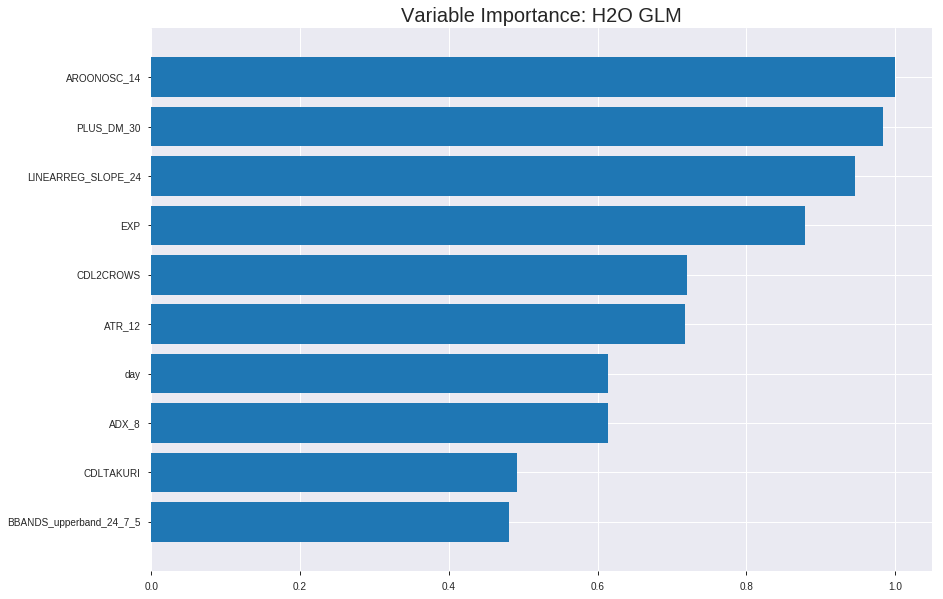

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_144414_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24785960612633232
RMSE: 0.4978550051233113
LogLoss: 0.6887777070465967
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.8722379876026
Residual deviance: 2414.854640905368
AIC: 2516.854640905368
AUC: 0.5476885122116336
pr_auc: 0.5503100274550843
Gini: 0.09537702442326723
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45919424733518244: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      53   812   0.9387   (812.0/865.0)
1      21   867   0.0236   (21.0/888.0)
Total  74   1679  0.4752   (833.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459194     0.675497  353
max f2                       0.416821     0.83821   391
max f0point5                 0.470141     0.574737  326
max accuracy                 0.497338     0.539646  236
max precision                0.792673     1         0
max recall                   0.416821     1         391
max specificity              0.792673     1         0
max absolute_mcc             0.470141     0.10789   326
max min_per_class_accuracy   0.505479     0.532658  202
max mean_per_class_accuracy  0.497338     0.538182  236

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.571183           1.42574   1.42574            0.722222         0.593484  0.722222                    0.593484            0.0146396       0.0146396                  42.5738   42.5738
    2        0.0205362                   0.56443            1.53541   1.48057            0.777778         0.567386  0.75                        0.580435            0.0157658       0.0304054                  53.541    48.0574
    3        0.0302339                   0.560806           1.16123   1.37814            0.588235         0.562577  0.698113                    0.574707            0.0112613       0.0416667                  16.1235   37.8145
    4        0.040502                    0.557887           1.42574   1.39021            0.722222         0.559491  0.704225                    0.570849            0.0146396       0.0563063                  42.5738   39.0211
    5        0.0501997                   0.555805           1.04511   1.32354            0.529412         0.556955  0.670455                    0.568165            0.0101351       0.0664414                  4.51113   32.3544
    6        0.100399                    0.54616            0.942184  1.13286            0.477273         0.550872  0.573864                    0.559519            0.0472973       0.113739                   -5.78163  13.2864
    7        0.150029                    0.539138           1.04378   1.10339            0.528736         0.542533  0.558935                    0.5539              0.0518018       0.165541                   4.37765   10.3394
    8        0.200228                    0.532709           1.00948   1.07985            0.511364         0.536153  0.547009                    0.54945             0.0506757       0.216216                   0.948249  7.98491
    9        0.300057                    0.521286           1.07165   1.07712            0.542857         0.527096  0.545627                    0.542013            0.106982        0.323198                   7.16538   7.71225
    10       0.399886                    0.512931           1.06037   1.07294            0.537143         0.516935  0.543509                    0.535752            0.105856        0.429054                   6.03732   7.29412
    11       0.500285                    0.505224           1.03192   1.06471            0.522727         0.509016  0.539339                    0.530387            0.103604        0.532658                   3.19154   6.4708
    12       0.600114                    0.497913           1.01525   1.05648            0.514286         0.501546  0.535171                    0.525589            0.101351        0.634009                   1.5251    5.64808
    13       0.699943                    0.491372           0.947568  1.04095            0.48             0.494535  0.527302                    0.52116             0.0945946       0.728604                   -5.24324  4.09471
    14       0.799772                    0.481977           0.902445  1.02366            0.457143         0.487014  0.518545                    0.516898            0.0900901       0.818694                   -9.75547  2.36591
    15       0.899601                    0.470191           1.1055    1.03274            0.56             0.476517  0.523145                    0.512417            0.11036         0.929054                   10.5495   3.27405
    16       1                           0.151928           0.706638  1                  0.357955         0.454084  0.50656                     0.50656           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24893284209327418
RMSE: 0.4989317008301579
LogLoss: 0.6909895116615471
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.6487637448975
Residual deviance: 692.3714906848703
AIC: 794.3714906848703
AUC: 0.5346510062812461
pr_auc: 0.5693527909211591
Gini: 0.06930201256249213
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4601062972854683: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   222  0.9569   (222.0/232.0)
1      3    266  0.0112   (3.0/269.0)
Total  13   488  0.4491   (225.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460106     0.702774  386
max f2                       0.439525     0.855054  395
max f0point5                 0.472217     0.606854  357
max accuracy                 0.473306     0.566866  353
max precision                0.54822      1         0
max recall                   0.439525     1         395
max specificity              0.54822      1         0
max absolute_mcc             0.472217     0.129871  357
max min_per_class_accuracy   0.495556     0.521552  202
max mean_per_class_accuracy  0.473306     0.537367  353

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 49.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.541614           1.55204   1.55204            0.833333         0.544025  0.833333                    0.544025            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.536229           0.744981  1.1852             0.4              0.537475  0.636364                    0.541048            0.00743494      0.0260223                  -25.5019  18.5198
    3        0.0319361                   0.532108           1.48996   1.28044            0.8              0.533348  0.6875                      0.538641            0.0148699       0.0408922                  48.9963   28.0437
    4        0.0419162                   0.530047           0.744981  1.15295            0.4              0.530848  0.619048                    0.536786            0.00743494      0.0483271                  -25.5019  15.2947
    5        0.0518962                   0.52838            1.11747   1.14613            0.6              0.529195  0.615385                    0.535326            0.0111524       0.0594796                  11.7472   14.6125
    6        0.101796                    0.523526           1.04297   1.09556            0.56             0.525734  0.588235                    0.530624            0.0520446       0.111524                   4.2974    9.55609
    7        0.151697                    0.515975           1.04297   1.07826            0.56             0.519657  0.578947                    0.527016            0.0520446       0.163569                   4.2974    7.82626
    8        0.201597                    0.512197           1.04297   1.06953            0.56             0.513662  0.574257                    0.523711            0.0520446       0.215613                   4.2974    6.95278
    9        0.301397                    0.505099           1.08022   1.07307            0.58             0.508213  0.576159                    0.518579            0.107807        0.32342                    8.0223    7.30693
    10       0.401198                    0.500921           1.00572   1.05632            0.54             0.502856  0.567164                    0.514668            0.100372        0.423792                   0.572491  5.63169
    11       0.500998                    0.495741           0.968476  1.03882            0.52             0.497783  0.557769                    0.511305            0.0966543       0.520446                   -3.15242  3.88187
    12       0.600798                    0.490778           0.81948   1.00238            0.44             0.493139  0.538206                    0.508287            0.0817844       0.60223                    -18.052   0.238363
    13       0.700599                    0.486417           1.19197   1.02939            0.64             0.488699  0.552707                    0.505497            0.118959        0.72119                    19.197    2.93903
    14       0.800399                    0.480528           0.893978  1.01251            0.48             0.483538  0.543641                    0.502759            0.0892193       0.810409                   -10.6022  1.25059
    15       0.9002                      0.473521           1.22922   1.03653            0.66             0.477118  0.556541                    0.499916            0.122677        0.933086                   22.9219   3.65318
    16       1                           0.353866           0.670483  1                  0.36             0.459865  0.536926                    0.495919        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 14:44:14  0.000 sec   2            2.5       51            1.38359           1.38408
    2019-08-25 14:44:14  0.010 sec   4            1.5       51            1.38288           1.38372
    2019-08-25 14:44:14  0.022 sec   6            0.95      51            1.38202           1.38327
    2019-08-25 14:44:14  0.035 sec   8            0.59      51            1.38102           1.38278
    2019-08-25 14:44:14  0.045 sec   10           0.37      51            1.37993           1.38236
    2019-08-25 14:44:14  0.057 sec   12           0.23      51            1.37877           1.38207
    2019-08-25 14:44:14  0.068 sec   14           0.14      51            1.37756           1.38198
    2019-08-25 14:44:14  0.078 sec   16           0.088     51            1.37631           1.38213
    2019-08-25 14:44:14  0.089 sec   18           0.054     51            1.37504           1.38254
    2019-08-25 14:44:14  0.102 sec   20           0.034     51            1.37379           1.38321
    2019-08-25 14:44:14  0.115 sec   22           0.021     51            1.37264           1.38413
    2019-08-25 14:44:14  0.128 sec   24           0.013     51            1.37161           1.38522

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6505376344086021)

('auc', 0.5153846153846153)

('logloss', 0.6929463387624144)

('mean_per_class_error', 0.46662428480610296)

('rmse', 0.49989691826341875)

('mse', 0.24989692888926315)

glm prediction progress: |████████████████████████████████████████████████| 100%


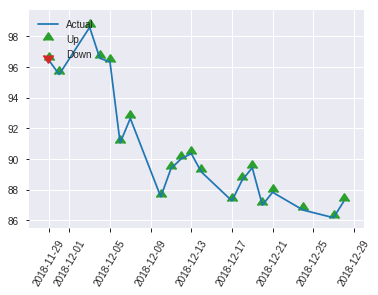


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24989692888926315
RMSE: 0.49989691826341875
LogLoss: 0.6929463387624144
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.2392766240658
Residual deviance: 347.85906205873204
AIC: 449.85906205873204
AUC: 0.5153846153846153
pr_auc: 0.5062469096509339
Gini: 0.03076923076923066
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40890565064365436: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    130  1        (130.0/130.0)
1      0    121  0        (0.0/121.0)
Total  0    251  0.5179   (130.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408906     0.650538  250
max f2                       0.408906     0.823129  250
max f0point5                 0.408906     0.537778  250
max accuracy                 0.538179     0.541833  13
max precision                0.538179     0.714286  13
max recall                   0.408906     1         250
max specificity              0.561897     0.992308  0
max absolute_mcc             0.538179     0.11295   13
max min_per_class_accuracy   0.49695      0.492308  125
max mean_per_class_accuracy  0.511633     0.533376  65

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 49.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.54654            1.38292   1.38292            0.666667         0.552481  0.666667                    0.552481            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.542079           0.69146   1.03719            0.333333         0.543718  0.5                         0.548099            0.00826446      0.0247934                  -30.854    3.71901
    3        0.0318725                   0.540551           2.07438   1.29649            1                0.541511  0.625                       0.546452            0.0165289       0.0413223                  107.438    29.6488
    4        0.0438247                   0.538564           1.38292   1.32006            0.666667         0.539185  0.636364                    0.54447             0.0165289       0.0578512                  38.292     32.006
    5        0.0517928                   0.538221           2.07438   1.43611            1                0.538345  0.692308                    0.543528            0.0165289       0.0743802                  107.438    43.6109
    6        0.103586                    0.531482           0.638271  1.03719            0.307692         0.535006  0.5                         0.539267            0.0330579       0.107438                   -36.1729   3.71901
    7        0.151394                    0.525039           1.38292   1.14637            0.666667         0.527451  0.552632                    0.535535            0.0661157       0.173554                   38.292     14.6368
    8        0.203187                    0.517042           1.11697   1.13888            0.538462         0.521073  0.54902                     0.531849            0.0578512       0.231405                   11.6974    13.8875
    9        0.302789                    0.508813           0.829752  1.03719            0.4              0.512323  0.5                         0.525426            0.0826446       0.31405                    -17.0248   3.71901
    10       0.40239                     0.501984           1.07868   1.04746            0.52             0.504635  0.50495                     0.52028             0.107438        0.421488                   7.86777    4.74593
    11       0.501992                    0.49695            0.746777  0.9878             0.36             0.499091  0.47619                     0.516076            0.0743802       0.495868                   -25.3223   -1.21999
    12       0.601594                    0.492894           0.995702  0.989108           0.48             0.494726  0.476821                    0.512541            0.0991736       0.595041                   -0.429752  -1.08916
    13       0.701195                    0.48708            1.16165   1.01362            0.56             0.489824  0.488636                    0.509314            0.115702        0.710744                   16.1653    1.36176
    14       0.800797                    0.481729           0.995702  1.01139            0.48             0.484039  0.487562                    0.50617             0.0991736       0.809917                   -0.429752  1.13893
    15       0.900398                    0.474334           0.829752  0.991297           0.4              0.477495  0.477876                    0.502998            0.0826446       0.892562                   -17.0248   -0.870328
    16       1                           0.408906           1.07868   1                  0.52             0.460226  0.482072                  

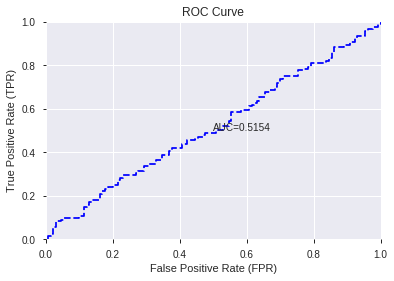

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


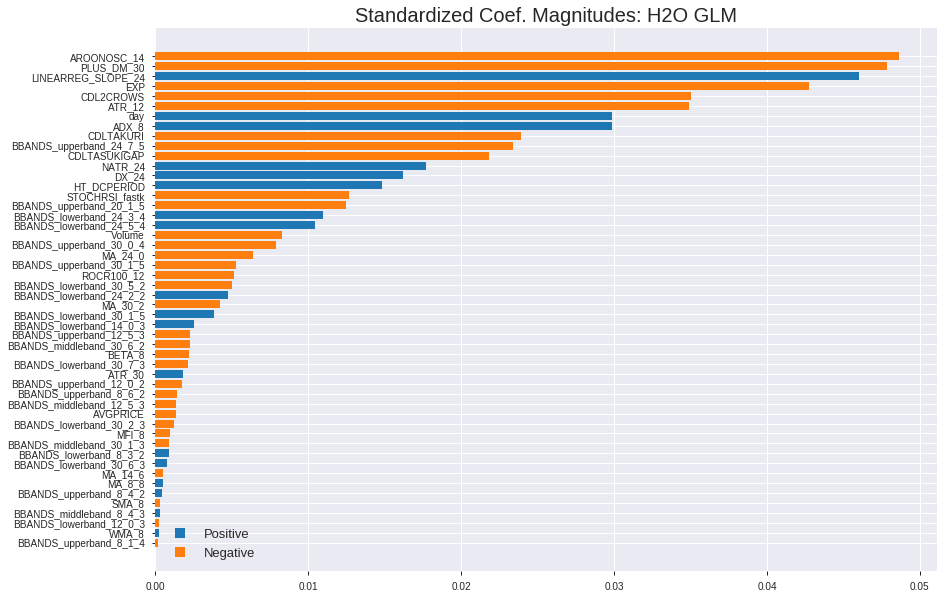

'log_likelihood'
--2019-08-25 14:44:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_144414_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_144414_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['AROONOSC_14',
 'PLUS_DM_30',
 'LINEARREG_SLOPE_24',
 'EXP',
 'CDL2CROWS',
 'ATR_12',
 'day',
 'ADX_8',
 'CDLTAKURI',
 'BBANDS_upperband_24_7_5',
 'CDLTASUKIGAP',
 'NATR_24',
 'DX_24',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'BBANDS_upperband_20_1_5',
 'BBANDS_lowerband_24_3_4',
 'BBANDS_lowerband_24_5_4',
 'Volume',
 'BBANDS_upperband_30_0_4',
 'MA_24_0',
 'BBANDS_upperband_30_1_5',
 'ROCR100_12',
 'BBANDS_lowerband_30_5_2',
 'BBANDS_lowerband_24_2_2',
 'MA_30_2',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_30_6_2',
 'BETA_8',
 'BBANDS_lowerband_30_7_3',
 'ATR_30',
 'BBANDS_upperband_12_0_2',
 'BBANDS_upperband_8_6_2',
 'BBANDS_middleband_12_5_3',
 'AVGPRICE',
 'BBANDS_lowerband_30_2_3',
 'MFI_8',
 'BBANDS_middleband_30_1_3',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_lowerband_30_6_3',
 'MA_14_6',
 'MA_8_8',
 'BBANDS_upperband_8_4_2',
 'SMA_8',
 'BBANDS_middleband_8_4_3',
 'BBANDS_lowerband_12_0_3',
 'WMA_8',
 'BBANDS_upperband_8_1_4'

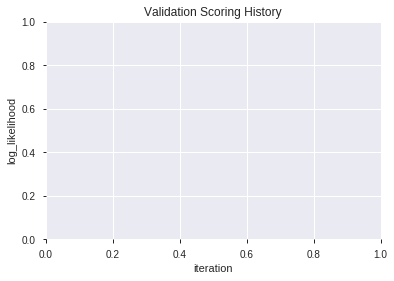

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_144424_model_1  0.528385  0.693056              0.492308  0.499983  0.249983
1  XGBoost_grid_1_AutoML_20190825_144424_model_2  0.525175  0.693179              0.452575  0.500011  0.250011
2  XGBoost_grid_1_AutoML_20190825_144424_model_4  0.523013  0.693164              0.478067  0.499975  0.249975
3               XGBoost_3_AutoML_20190825_144424  0.517864  0.694312              0.473935  0.500595  0.250595
4               XGBoost_1_AutoML_20190825_144424  0.517737  0.699395              0.492308  0.503081  0.253090
5  XGBoost_grid_1_AutoML_20190825_144424_model_6  0.512142  0.699000              0.500000  0.502752  0.252760
6               XGBoost_2_AutoML_20190825_144424  0.495359  0.704225              0.481055  0.505363  0.255392
7  XGBoost_grid_1_AutoML_20190825_144424_model_7  0.489574  0.714485              0.500000  0.509893  0.259991
8  XGBoost_grid_1_AutoML_20190825_144424_model_3  0.469612  0.710721              0.496154  0.508552  0.258625
9  XGBoost_grid_1_AutoML_20190825_144424_model_5  0.469358  0.740504              0.492594  0.521367  0.271824

variable  relative_importance  scaled_importance  percentage
0                     Volume           305.842926           1.000000    0.082570
1                HT_DCPERIOD           214.608047           0.701694    0.057939
2                 PLUS_DM_30           212.964127           0.696319    0.057495
3             STOCHRSI_fastk           210.168518           0.687178    0.056740
4                      ADX_8           182.025879           0.595161    0.049142
5                     ATR_30           175.675140           0.574397    0.047428
6         LINEARREG_SLOPE_24           169.780762           0.555124    0.045837
7    BBANDS_upperband_30_1_5           164.448303           0.537689    0.044397
8                      MFI_8           153.216400           0.500964    0.041365
9                     ATR_12           152.041855           0.497124    0.041048
10                    BETA_8           124.614693           0.407447    0.033643
11                       day           120.050842           0.392525    0.032411
12               AROONOSC_14           103.595123           0.338720    0.027968
13                     DX_24            99.801376           0.326316    0.026944
14                ROCR100_12            99.437622           0.325126    0.026846
15   BBANDS_upperband_24_7_5            98.913223           0.323412    0.026704
16    BBANDS_upperband_8_1_4            94.120743           0.307742    0.025410
17   BBANDS_lowerband_24_5_4            86.615906           0.283204    0.023384
18   BBANDS_upperband_20_1_5            69.583595           0.227514    0.018786
19   BBANDS_lowerband_24_3_4            65.719910           0.214881    0.017743
20   BBANDS_upperband_12_5_3            59.951370           0.196020    0.016185
21   BBANDS_upperband_12_0_2            51.703762           0.169053    0.013959
22    BBANDS_upperband_8_6_2            49.033691           0.160323    0.013238
23                   NATR_24            47.275043           0.154573    0.012763
24    BBANDS_upperband_8_4_2            45.466877           0.148661    0.012275
25   BBANDS_lowerband_30_2_3            40.384914           0.132045    0.010903
26    BBANDS_lowerband_8_3_2            39.684734           0.129755    0.010714
27  BBANDS_middleband_30_1_3            33.096821           0.108215    0.008935
28                       EXP            29.801094           0.097439    0.008046
29   BBANDS_lowerband_30_1_5            29.525730           0.096539    0.007971
30                  AVGPRICE            29.460102           0.096324    0.007953
31   BBANDS_lowerband_30_5_2            29.142654           0.095286    0.007868
32  BBANDS_middleband_30_6_2            28.718668           0.093900    0.007753
33   BBANDS_middleband_8_4_3            26.868984           0.087852    0.007254
34                   MA_30_2            26.815704           0.087678    0.007240
35                     SMA_8            25.572056           0.083612    0.006904
36                   MA_24_0            25.152214           0.082239    0.006790
37                     WMA_8            25.104982           0.082085    0.006778
38   BBANDS_lowerband_30_7_3            24.431744           0.079883    0.006596
39   BBANDS_lowerband_12_0_3            24.151932           0.078968    0.006520
40   BBANDS_upperband_30_0_4            23.783928           0.077765    0.006421
41   BBANDS_lowerband_24_2_2            19.663008           0.064291    0.005309
42                    MA_8_8            19.562218           0.063962    0.005281
43   BBANDS_lowerband_14_0_3            19.347656           0.063260    0.005223
44  BBANDS_middleband_12_5_3            14.886370           0.048673    0.004019
45                   MA_14_6            12.232478           0.039996    0.003302

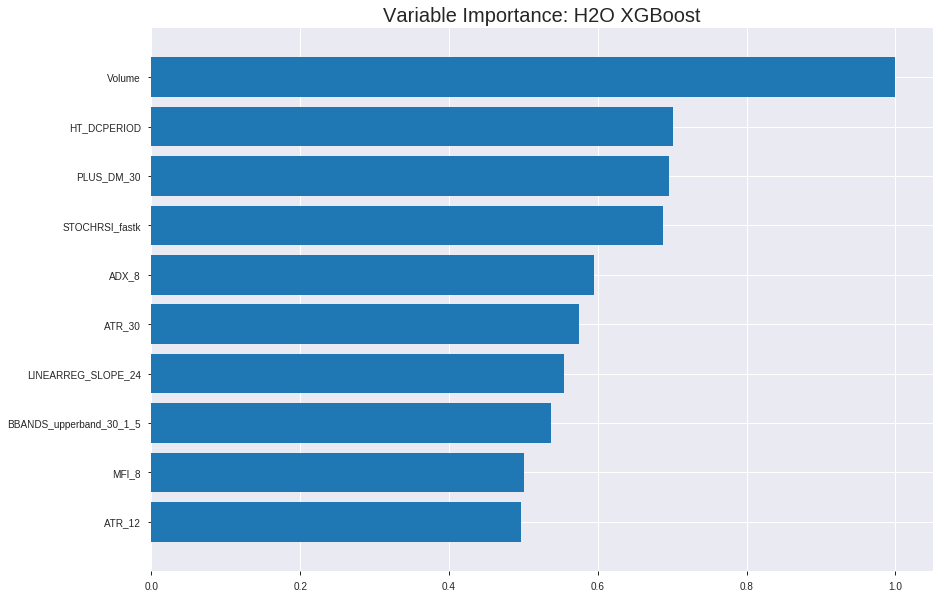

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_144424_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19962363485132298
RMSE: 0.4467926083221644
LogLoss: 0.5902353623869835
Mean Per-Class Error: 0.1706107118679373
AUC: 0.8995267666510441
pr_auc: 0.8976478072126397
Gini: 0.7990535333020883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49013690153757733: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      652  213  0.2462   (213.0/865.0)
1      108  780  0.1216   (108.0/888.0)
Total  760  993  0.1831   (321.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490137     0.829346  222
max f2                       0.46768      0.884461  251
max f0point5                 0.523541     0.853783  180
max accuracy                 0.513973     0.828865  191
max precision                0.790282     1         0
max recall                   0.359987     1         356
max specificity              0.790282     1         0
max absolute_mcc             0.513973     0.660403  191
max min_per_class_accuracy   0.505346     0.824324  202
max mean_per_class_accuracy  0.513973     0.829389  191

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.703936           1.9741    1.9741             1                0.734405  1                           0.734405            0.0202703       0.0202703                  97.4099   97.4099
    2        0.0205362                   0.687664           1.86443   1.91926            0.944444         0.696116  0.972222                    0.715261            0.0191441       0.0394144                  86.4427   91.9263
    3        0.0302339                   0.670908           1.9741    1.93685            1                0.67802   0.981132                    0.703316            0.0191441       0.0585586                  97.4099   93.6852
    4        0.040502                    0.661952           1.75475   1.89069            0.888889         0.665771  0.957746                    0.693797            0.018018        0.0765766                  75.4755   89.0686
    5        0.0501997                   0.651902           1.9741    1.9068             1                0.65679   0.965909                    0.686648            0.0191441       0.0957207                  97.4099   90.68
    6        0.100399                    0.618371           1.9068    1.9068             0.965909         0.633262  0.965909                    0.659955            0.0957207       0.191441                   90.68     90.68
    7        0.150029                    0.596926           1.92872   1.91405            0.977011         0.607629  0.969582                    0.642646            0.0957207       0.287162                   92.8718   91.405
    8        0.200228                    0.579322           1.79464   1.88411            0.909091         0.588223  0.954416                    0.629001            0.0900901       0.377252                   79.4636   88.4112
    9        0.300057                    0.553015           1.6808    1.81647            0.851429         0.565707  0.920152                    0.607943            0.167793        0.545045                   68.0804   81.6471
    10       0.399886                    0.530562           1.60184   1.76289            0.811429         0.542034  0.89301                     0.59149             0.15991         0.704955                   60.184    76.289
    11       0.500285                    0.505677           1.16651   1.64321            0.590909         0.517592  0.832383                    0.57666             0.117117        0.822072                   16.6513   64.3207
    12       0.600114                    0.482655           0.78964   1.50122            0.4              0.49409   0.760456                    0.562924            0.0788288       0.900901                   -21.036   50.1216
    13       0.699943                    0.462471           0.462503  1.35307            0.234286         0.472672  0.685412                    0.550052            0.0461712       0.947072                   -53.7497  35.307
    14       0.799772                    0.436227           0.282014  1.21938            0.142857         0.449251  0.617689                    0.53747             0.0281532       0.975225                   -71.7986  21.9379
    15       0.899601                    0.387242           0.146647  1.10034            0.0742857        0.413767  0.557387                    0.523743            0.0146396       0.989865                   -85.3353  10.0338
    16       1                           0.244176           0.100948  1                  0.0511364        0.347417  0.50656                     0.50604             0.01



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2509628254457737
RMSE: 0.5009619001937908
LogLoss: 0.6951157838523836
Mean Per-Class Error: 0.45498173311113965
AUC: 0.5304287911806178
pr_auc: 0.5509741363804536
Gini: 0.06085758236123562
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3567715585231781: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   219  0.944    (219.0/232.0)
1      5    264  0.0186   (5.0/269.0)
Total  18   483  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356772     0.702128  382
max f2                       0.291495     0.852885  399
max f0point5                 0.396355     0.609995  344
max accuracy                 0.402881     0.572854  342
max precision                0.655697     1         0
max recall                   0.291495     1         399
max specificity              0.655697     1         0
max absolute_mcc             0.396355     0.139397  344
max min_per_class_accuracy   0.493278     0.509294  190
max mean_per_class_accuracy  0.402881     0.545018  342

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 48.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.621247           1.24164   1.24164            0.666667         0.630456  0.666667                    0.630456            0.0148699       0.0148699                  24.1636   24.1636
    2        0.0219561                   0.605255           0.372491  0.84657            0.2              0.609158  0.454545                    0.620775            0.00371747      0.0185874                  -62.7509  -15.343
    3        0.0319361                   0.600193           0.744981  0.814823           0.4              0.601545  0.4375                      0.614765            0.00743494      0.0260223                  -25.5019  -18.5177
    4        0.0419162                   0.593302           1.48996   0.975571           0.8              0.596259  0.52381                     0.610359            0.0148699       0.0408922                  48.9963   -2.44291
    5        0.0518962                   0.584258           1.48996   1.07449            0.8              0.587837  0.576923                    0.606028            0.0148699       0.0557621                  48.9963   7.44924
    6        0.101796                    0.561908           0.81948   0.949486           0.44             0.570618  0.509804                    0.58867             0.0408922       0.0966543                  -18.052   -5.05139
    7        0.151697                    0.549879           1.26647   1.05376            0.68             0.556054  0.565789                    0.577941            0.063197        0.159851                   26.6468   5.37566
    8        0.201597                    0.540985           1.11747   1.06953            0.6              0.544881  0.574257                    0.569758            0.0557621       0.215613                   11.7472   6.95278
    9        0.301397                    0.524373           0.856729  0.999064           0.46             0.532683  0.536424                    0.557481            0.0855019       0.301115                   -14.3271  -0.0935523
    10       0.401198                    0.509531           1.22922   1.05632            0.66             0.517279  0.567164                    0.547481            0.122677        0.423792                   22.9219   5.63169
    11       0.500998                    0.492456           0.856729  1.01656            0.46             0.500275  0.545817                    0.538077            0.0855019       0.509294                   -14.3271  1.65583
    12       0.600798                    0.479322           1.19197   1.0457             0.64             0.485339  0.561462                    0.529317            0.118959        0.628253                   19.197    4.56965
    13       0.700599                    0.462012           0.968476  1.0347             0.52             0.469262  0.555556                    0.520762            0.0966543       0.724907                   -3.15242  3.46964
    14       0.800399                    0.434491           1.00572   1.03108            0.54             0.448281  0.553616                    0.511724            0.100372        0.825279                   0.572491  3.1084
    15       0.9002                      0.391865           1.08022   1.03653            0.58             0.414964  0.556541                    0.500997            0.107807        0.933086                   8.0223    3.65318
    16       1                           0.291495           0.670483  1                  0.36             0.36202   0.536926                    0.487127    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:44:27  0.014 sec   0                  0.5              0.693147            0.5             0                  1                0.49344                          0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-25 14:44:28  0.071 sec   5                  0.491493         0.676237            0.737024        0.732756           1.86443          0.359384                         0.500005           0.693157              0.529235          0.55416              0.931227           0.45509
    2019-08-25 14:44:28  0.108 sec   10                 0.485049         0.663569            0.787277        0.780945           1.86443          0.309184                         0.499686           0.692513              0.530204          0.549099             1.24164            0.451098
    2019-08-25 14:44:28  0.141 sec   15                 0.479521         0.65275             0.804898        0.79918            1.9741           0.282373                         0.499906           0.692967              0.530277          0.552732             0.620818           0.451098
    2019-08-25 14:44:28  0.176 sec   20                 0.47541          0.644738            0.817101        0.812457           1.86443          0.251569                         0.500073           0.693286              0.52277           0.549577             1.24164            0.447106
    2019-08-25 14:44:28  0.216 sec   25                 0.470941         0.63606             0.835121        0.831205           1.86443          0.241301                         0.500486           0.694103              0.515791          0.541754             1.55204            0.44511
    2019-08-25 14:44:28  0.261 sec   30                 0.465095         0.624841            0.858851        0.856612           1.9741           0.208214                         0.500685           0.694533              0.52043           0.548926             1.24164            0.451098
    2019-08-25 14:44:28  0.302 sec   35                 0.460055         0.615238            0.871225        0.869182           1.86443          0.208214                         0.501558           0.696317              0.516488          0.54017              1.06426            0.45509
    2019-08-25 14:44:28  0.342 sec   40                 0.455806         0.607199            0.882018        0.881021           1.9741           0.200799                         0.501904           0.697055              0.518115          0.539023             0.620818           0.45509
    2019-08-25 14:44:28  0.382 sec   45                 0.452216         0.600371            0.887095        0.883823           1.86443          0.188249                         0.501132           0.695478              0.523467          0.547367             0.931227           0.457086
    2019-08-25 14:44:28  0.438 sec   50                 0.446793         0.590235            0.899527        0.897648           1.9741           0.183115                         0.500962           0.695116              0.530429          0.550974             1.24164            0.447106

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
Volume                    305.8429260253906      1.0                  0.08257000958236985
HT_DCPERIOD               214.60804748535156     0.7016936774517228   0.05793885367107709
PLUS_DM_30                212.96412658691406     0.6963186278476622   0.057495035773764094
STOCHRSI_fastk            210.16851806640625     0.6871779602610733   0.05674029076355019
ADX_8                     182.02587890625        0.5951613178430633   0.0491424757173576
---                       ---                    ---                  ---
BBANDS_lowerband_24_2_2   19.663007736206055     0.06429119676475258  0.005308524732927645
MA_8_8                    19.562217712402344     0.06396164844034456  0.005281313924623422
BBANDS_lowerband_14_0_3   19.34765625            0.0632601070799126   0.005223387647770126
BBANDS_middleband_12_5_3  14.886369705200195     0.04867325165455797  0.0040189508555219505
MA_14_6                   12.232478141784668     0.03999594923038745  0.0033024659112090697


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.654054054054054)

('auc', 0.5283852511125239)

('logloss', 0.6930563543304952)

('mean_per_class_error', 0.4375715193897012)

('rmse', 0.4999829713542771)

('mse', 0.24998297164425187)

xgboost prediction progress: |████████████████████████████████████████████| 100%


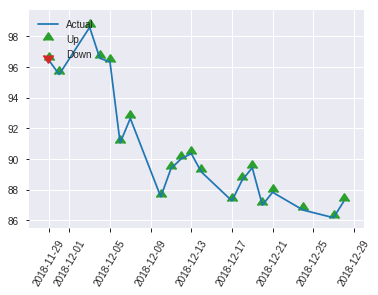


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24998297164425187
RMSE: 0.4999829713542771
LogLoss: 0.6930563543304952
Mean Per-Class Error: 0.4375715193897012
AUC: 0.5283852511125239
pr_auc: 0.5243518442069374
Gini: 0.05677050222504776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3120194971561432: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    128  0.9846   (128.0/130.0)
1      0    121  0        (0.0/121.0)
Total  2    249  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.312019     0.654054  247
max f2                       0.312019     0.825375  247
max f0point5                 0.430628     0.549451  218
max accuracy                 0.549609     0.573705  45
max precision                0.662677     1         0
max recall                   0.312019     1         247
max specificity              0.662677     1         0
max absolute_mcc             0.549609     0.161258  45
max min_per_class_accuracy   0.510272     0.512397  123
max mean_per_class_accuracy  0.549609     0.562428  45

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.630163           2.07438   2.07438            1                0.652833  1                           0.652833            0.0247934       0.0247934                  107.438    107.438
    2        0.0239044                   0.623768           0         1.03719            0                0.625041  0.5                         0.638937            0               0.0247934                  -100       3.71901
    3        0.0318725                   0.596672           1.03719   1.03719            0.5              0.608072  0.5                         0.631221            0.00826446      0.0330579                  3.71901    3.71901
    4        0.0438247                   0.593314           0.69146   0.9429             0.333333         0.59445   0.454545                    0.621192            0.00826446      0.0413223                  -30.854    -5.70999
    5        0.0517928                   0.587493           1.03719   0.957406           0.5              0.588331  0.461538                    0.616137            0.00826446      0.0495868                  3.71901    -4.25938
    6        0.103586                    0.570018           1.59568   1.27654            0.769231         0.575989  0.615385                    0.596063            0.0826446       0.132231                   59.5677    27.6542
    7        0.151394                    0.55266            1.38292   1.31013            0.666667         0.55864   0.631579                    0.584245            0.0661157       0.198347                   38.292     31.0135
    8        0.203187                    0.548356           1.11697   1.2609             0.538462         0.55016   0.607843                    0.575557            0.0578512       0.256198                   11.6974    26.0898
    9        0.302789                    0.535942           0.829752  1.11907            0.4              0.540483  0.539474                    0.564019            0.0826446       0.338843                   -17.0248   11.9074
    10       0.40239                     0.5187             0.829752  1.04746            0.4              0.526872  0.50495                     0.554825            0.0826446       0.421488                   -17.0248   4.74593
    11       0.501992                    0.509725           0.912727  1.02073            0.44             0.514534  0.492063                    0.54683             0.0909091       0.512397                   -8.72727   2.07267
    12       0.601594                    0.497329           0.829752  0.989108           0.4              0.502782  0.476821                    0.539538            0.0826446       0.595041                   -17.0248   -1.08916
    13       0.701195                    0.48277            0.995702  0.990045           0.48             0.489665  0.477273                    0.532453            0.0991736       0.694215                   -0.429752  -0.995492
    14       0.800797                    0.461337           1.07868   1.00107            0.52             0.472083  0.482587                    0.524945            0.107438        0.801653                   7.86777    0.106903
    15       0.900398                    0.420843           1.07868   1.00965            0.52             0.441719  0.486726                    0.515738            0.107438        0.909091                   7.86777    0.965406
    16       1                           0.289983           0.912727  1                  0.44             0.376392  0.482072             

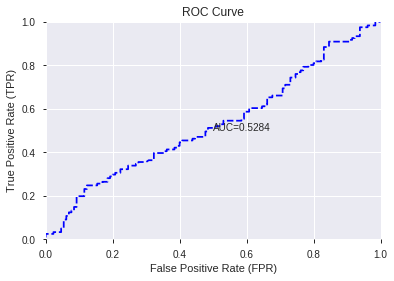

This function is available for GLM models only


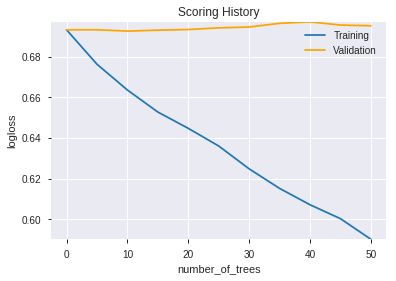

--2019-08-25 14:44:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.81.168
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.81.168|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_144424_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_144424_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'HT_DCPERIOD',
 'PLUS_DM_30',
 'STOCHRSI_fastk',
 'ADX_8',
 'ATR_30',
 'LINEARREG_SLOPE_24',
 'BBANDS_upperband_30_1_5',
 'MFI_8',
 'ATR_12',
 'BETA_8',
 'day',
 'AROONOSC_14',
 'DX_24',
 'ROCR100_12',
 'BBANDS_upperband_24_7_5',
 'BBANDS_upperband_8_1_4',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_upperband_20_1_5',
 'BBANDS_lowerband_24_3_4',
 'BBANDS_upperband_12_5_3',
 'BBANDS_upperband_12_0_2',
 'BBANDS_upperband_8_6_2',
 'NATR_24',
 'BBANDS_upperband_8_4_2',
 'BBANDS_lowerband_30_2_3',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_middleband_30_1_3',
 'EXP',
 'BBANDS_lowerband_30_1_5',
 'AVGPRICE',
 'BBANDS_lowerband_30_5_2',
 'BBANDS_middleband_30_6_2',
 'BBANDS_middleband_8_4_3',
 'MA_30_2',
 'SMA_8',
 'MA_24_0',
 'WMA_8',
 'BBANDS_lowerband_30_7_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_30_0_4',
 'BBANDS_lowerband_24_2_2',
 'MA_8_8',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_middleband_12_5_3',
 'MA_14_6']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [924] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190825_144445  0.534901  0.897688              0.440750  0.563088  0.317068
1  DeepLearning_grid_1_AutoML_20190825_144445_model_2  0.515067  0.759354              0.471233  0.527289  0.278034
2  DeepLearning_grid_1_AutoML_20190825_144445_model_7  0.511507  0.722831              0.500000  0.505446  0.255475
3  DeepLearning_grid_1_AutoML_20190825_144445_model_5  0.504704  0.707161              0.500000  0.506904  0.256951
4  DeepLearning_grid_1_AutoML_20190825_144445_model_8  0.504132  0.698684              0.500000  0.502754  0.252762
5  DeepLearning_grid_1_AutoML_20190825_144445_model_6  0.500318  0.702370              0.496154  0.504044  0.254060
6  DeepLearning_grid_1_AutoML_20190825_144445_model_3  0.494278  0.789929              0.500000  0.536605  0.287945
7  DeepLearning_grid_1_AutoML_20190825_144445_model_4  0.477305  1.188671              0.500000  0.606854  0.368271
8  DeepLearning_grid_1_AutoML_20190825_144445_model_1  0.471074  1.590747              0.500000  0.640759  0.410572
9  DeepLearning_grid_1_AutoML_20190825_144445_model_9  0.457088  0.696639              0.480769  0.501740  0.251743

variable  relative_importance  scaled_importance  percentage
0                 HT_DCPERIOD             1.000000           1.000000    0.001859
1                   CDLTAKURI             0.946538           0.946538    0.001760
2                CDLTASUKIGAP             0.849565           0.849565    0.001579
3     BBANDS_upperband_20_1_5             0.793698           0.793698    0.001476
4                 AROONOSC_14             0.790757           0.790757    0.001470
...                       ...                  ...                ...         ...
1034                  ROCR_20             0.266962           0.266962    0.000496
1035  BBANDS_upperband_20_3_3             0.256644           0.256644    0.000477
1036                   T3_8_5             0.241831           0.241831    0.000450
1037                   SUM_30             0.227357           0.227357    0.000423
1038                MAVP_14_7             0.225380           0.225380    0.000419

[1039 rows x 4 columns]

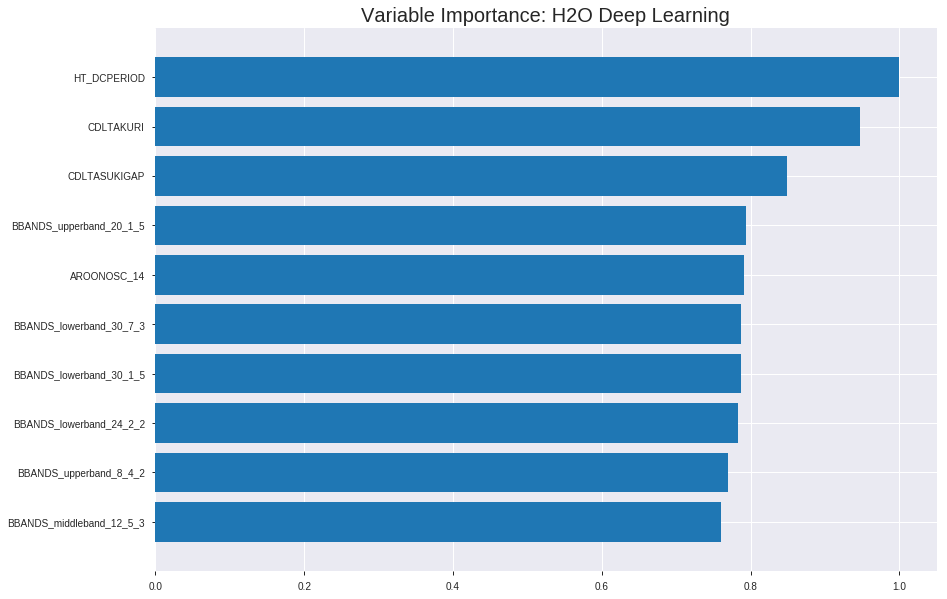

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190825_144445


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2515477260091299
RMSE: 0.5015453379397817
LogLoss: 0.7135470340729959
Mean Per-Class Error: 0.42414661771598183
AUC: 0.6026740613445816
pr_auc: 0.6444571385116357
Gini: 0.20534812268916314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.038956856748730395: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   850   0.9827   (850.0/865.0)
1      2    886   0.0023   (2.0/888.0)
Total  17   1736  0.486    (852.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0389569    0.675305  392
max f2                       0.0287157    0.837894  396
max f0point5                 0.43417      0.588747  172
max accuracy                 0.43417      0.577296  172
max precision                0.999899     1         0
max recall                   0.0287157    1         396
max specificity              0.999899     1         0
max absolute_mcc             0.667117     0.20069   67
max min_per_class_accuracy   0.485945     0.565318  133
max mean_per_class_accuracy  0.43417      0.575853  172

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 43.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.978782           1.9741    1.9741             1                0.993917   1                           0.993917            0.0202703       0.0202703                  97.4099   97.4099
    2        0.0205362                   0.91634            1.9741    1.9741             1                0.949773   1                           0.971845            0.0202703       0.0405405                  97.4099   97.4099
    3        0.0302339                   0.869058           1.85798   1.93685            0.941176         0.89088    0.981132                    0.945875            0.018018        0.0585586                  85.7976   93.6852
    4        0.040502                    0.781436           1.53541   1.83508            0.777778         0.84207    0.929577                    0.919558            0.0157658       0.0743243                  53.541    83.5078
    5        0.0501997                   0.712943           1.85798   1.8395             0.941176         0.748842   0.931818                    0.886579            0.018018        0.0923423                  85.7976   83.9501
    6        0.403879                    0.521242           1.0762    1.17108            0.545161         0.53226    0.59322                     0.576299            0.380631        0.472973                   7.62024   17.1076
    7        0.500285                    0.485846           0.969528  1.13224            0.491124         0.495768   0.573546                    0.560781            0.0934685       0.566441                   -3.0472   13.2237
    8        0.600114                    0.439384           1.04909   1.11841            0.531429         0.466813   0.56654                     0.545149            0.10473         0.671171                   4.90927   11.8406
    9        0.699943                    0.384663           0.846042  1.07956            0.428571         0.414381   0.546862                    0.526498            0.0844595       0.755631                   -15.3958  7.95603
    10       0.799772                    0.293892           0.823481  1.0476             0.417143         0.345175   0.53067                     0.503865            0.0822072       0.837838                   -17.6519  4.75961
    11       0.899601                    0.142431           0.834762  1.02398            0.422857         0.225983   0.518706                    0.473029            0.0833333       0.921171                   -16.5238  2.39778
    12       1                           0.0149006          0.785153  1                  0.397727         0.0800439  0.50656                     0.433573            0.0788288       1                          -21.4847  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3480328030368131
RMSE: 0.5899430506725315
LogLoss: 1.1212890964469315
Mean Per-Class Error: 0.4417782976541469
AUC: 0.5552333034226381
pr_auc: 0.5518293155239324
Gini: 0.1104666068452762
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05725600167455118: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      31   201  0.8664   (201.0/232.0)
1      12   257  0.0446   (12.0/269.0)
Total  43   458  0.4251   (213.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.057256     0.707015  366
max f2                       0.0320589    0.857234  393
max f0point5                 0.057256     0.611614  366
max accuracy                 0.10051      0.576846  304
max precision                0.485587     0.604317  93
max recall                   0.0320589    1         393
max specificity              0.999967     0.982759  0
max absolute_mcc             0.057256     0.158452  366
max min_per_class_accuracy   0.258009     0.531599  192
max mean_per_class_accuracy  0.10051      0.558222  304

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 33.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.999767           0.620818  0.620818           0.333333         0.999934   0.333333                    0.999934            0.00743494      0.00743494                 -37.9182  -37.9182
    2        0.0219561                   0.99585            0.744981  0.677256           0.4              0.997381   0.363636                    0.998773            0.00743494      0.0148699                  -25.5019  -32.2744
    3        0.0319361                   0.99269            1.11747   0.814823           0.6              0.994372   0.4375                      0.997398            0.0111524       0.0260223                  11.7472   -18.5177
    4        0.0419162                   0.988232           0.744981  0.798194           0.4              0.990234   0.428571                    0.995692            0.00743494      0.0334572                  -25.5019  -20.1806
    5        0.0518962                   0.962907           0.744981  0.787961           0.4              0.975275   0.423077                    0.991766            0.00743494      0.0408922                  -25.5019  -21.2039
    6        0.101796                    0.768261           1.04297   0.912967           0.56             0.872026   0.490196                    0.93307             0.0520446       0.0929368                  4.2974    -8.70326
    7        0.201597                    0.521242           1.11747   1.01421            0.6              0.565724   0.544554                    0.751215            0.111524        0.204461                   11.7472   1.42074
    8        0.301397                    0.48173            1.26647   1.09774            0.68             0.490988   0.589404                    0.665047            0.126394        0.330855                   26.6468   9.77375
    9        0.401198                    0.378889           0.893978  1.04705            0.48             0.431781   0.562189                    0.607021            0.0892193       0.420074                   -10.6022  4.7051
    10       0.500998                    0.258009           1.11747   1.06108            0.6              0.31869    0.569721                    0.549585            0.111524        0.531599                   11.7472   6.10791
    11       0.600798                    0.18427            1.19197   1.08282            0.64             0.216572   0.581395                    0.494267            0.118959        0.650558                   19.197    8.28218
    12       0.700599                    0.13461            0.968476  1.06653            0.52             0.158647   0.57265                     0.446458            0.0966543       0.747212                   -3.15242  6.65332
    13       0.800399                    0.0801345          0.968476  1.05431            0.52             0.102416   0.566085                    0.40356             0.0966543       0.843866                   -3.15242  5.43066
    14       0.9002                      0.0604653          0.931227  1.04066            0.5              0.0709689  0.558758                    0.366687            0.0929368       0.936803                   -6.87732  4.06614
    15       1                           0.0190097          0.633234  1                  0.34             0.0452646  0.536926                    0.334609            0.063197        1                          -36.6766  0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:44:46  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:44:46  0.335 sec   9036 obs/sec      1         1             1753       0.602537         1.33423             -0.452452      0.543349        0.55352            1.64508          0.49344                          0.684551           2.39496               -0.884722        0.544722          0.540677             0.620818           0.433134
    2019-08-25 14:44:47  1.680 sec   12156 obs/sec     10        10            17530      0.501545         0.713547            -0.00636414    0.602674        0.644457           1.9741           0.486024                         0.589943           1.12129               -0.399766        0.555233          0.551829             0.620818           0.42515

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ----------------------
HT_DCPERIOD              1.0                    1.0                  0.0018590468611220771
CDLTAKURI                0.9465383291244507     0.9465383291244507   0.0017596591096905455
CDLTASUKIGAP             0.8495653867721558     0.8495653867721558   0.0015793818655967396
BBANDS_upperband_20_1_5  0.7936983108520508     0.7936983108520508   0.0014755223534673996
AROONOSC_14              0.79075688123703       0.79075688123703     0.0014700540979743837
---                      ---                    ---                  ---
ROCR_20                  0.26696154475212097    0.26696154475212097  0.0004962940218117314
BBANDS_upperband_20_3_3  0.25664448738098145    0.25664448738098145  0.0004771141286898981
T3_8_5                   0.24183149635791779    0.24183149635791779  0.00044957608422464205
SUM_30                   0.2273569107055664     0.2273569107055664   0.00042266715120159557
MAVP_14_7                0.22538019716739655    0.22538019716739655  0.0004189923481031234


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.6647058823529413)

('auc', 0.5349014621741894)

('logloss', 0.897687700547511)

('mean_per_class_error', 0.4407501589319771)

('rmse', 0.5630882822597978)

('mse', 0.31706841361828975)

deeplearning prediction progress: |███████████████████████████████████████| 100%


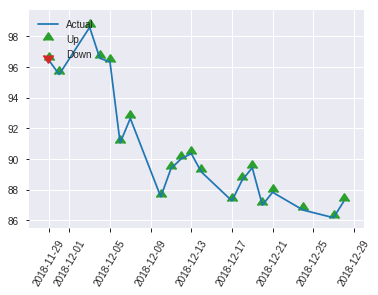


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.31706841361828975
RMSE: 0.5630882822597978
LogLoss: 0.897687700547511
Mean Per-Class Error: 0.4407501589319771
AUC: 0.5349014621741894
pr_auc: 0.5060273072613382
Gini: 0.06980292434837887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1213718429152224: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   106  0.8154   (106.0/130.0)
1      8    113  0.0661   (8.0/121.0)
Total  32   219  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.121372     0.664706  218
max f2                       0.0828219    0.827633  246
max f0point5                 0.121372     0.5667    218
max accuracy                 0.158527     0.545817  172
max precision                0.992289     0.666667  2
max recall                   0.0828219    1         246
max specificity              0.999548     0.992308  0
max absolute_mcc             0.121372     0.177535  218
max min_per_class_accuracy   0.207407     0.5       125
max mean_per_class_accuracy  0.121372     0.55925   218

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 25.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.937409           1.38292   1.38292            0.666667         0.99576    0.666667                    0.99576             0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.64953            1.38292   1.38292            0.666667         0.735848   0.666667                    0.865804            0.0165289       0.0330579                  38.292     38.292
    3        0.0318725                   0.564688           1.03719   1.29649            0.5              0.582817   0.625                       0.795057            0.00826446      0.0413223                  3.71901    29.6488
    4        0.0438247                   0.527116           0.69146   1.13148            0.333333         0.539376   0.545455                    0.725326            0.00826446      0.0495868                  -30.854    13.148
    5        0.0517928                   0.490793           2.07438   1.27654            1                0.502181   0.615385                    0.690996            0.0165289       0.0661157                  107.438    27.6542
    6        0.103586                    0.450308           0.957406  1.11697            0.461538         0.482938   0.538462                    0.586967            0.0495868       0.115702                   -4.25938   11.6974
    7        0.151394                    0.400493           1.03719   1.09178            0.5              0.416076   0.526316                    0.533001            0.0495868       0.165289                   3.71901    9.1779
    8        0.203187                    0.375293           0.957406  1.05753            0.461538         0.385958   0.509804                    0.49552             0.0495868       0.214876                   -4.25938   5.75271
    9        0.302789                    0.30916            0.829752  0.982601           0.4              0.337773   0.473684                    0.443629            0.0826446       0.297521                   -17.0248   -1.73989
    10       0.40239                     0.256783           1.16165   1.02692            0.56             0.283999   0.49505                     0.404117            0.115702        0.413223                   16.1653    2.69209
    11       0.501992                    0.207407           0.912727  1.00426            0.44             0.234564   0.484127                    0.370476            0.0909091       0.504132                   -8.72727   0.426341
    12       0.601594                    0.175616           1.07868   1.01658            0.52             0.191347   0.490066                    0.340819            0.107438        0.61157                    7.86777    1.65837
    13       0.701195                    0.156254           1.3276    1.06076            0.64             0.165363   0.511364                    0.315896            0.132231        0.743802                   32.7603    6.07626
    14       0.800797                    0.132028           0.995702  1.05267            0.48             0.141593   0.507463                    0.294216            0.0991736       0.842975                   -0.429752  5.26705
    15       0.900398                    0.112143           0.995702  1.04637            0.48             0.12327    0.504425                    0.275306            0.0991736       0.942149                   -0.429752  4.63688
    16       1                           0.0658818          0.580826  1                  0.28             0.0957235  0.482072    

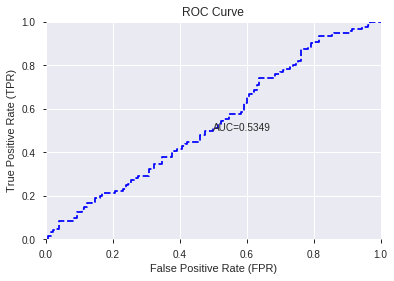

This function is available for GLM models only


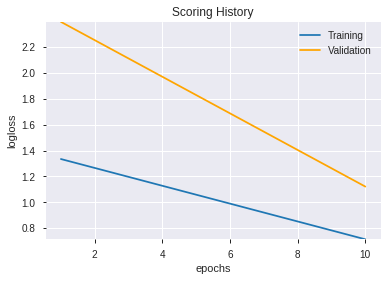

--2019-08-25 15:17:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190825_144445',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190825_144445',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_b594'

['HT_DCPERIOD',
 'CDLTAKURI',
 'CDLTASUKIGAP',
 'BBANDS_upperband_20_1_5',
 'AROONOSC_14',
 'BBANDS_lowerband_30_7_3',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_lowerband_24_2_2',
 'BBANDS_upperband_8_4_2',
 'BBANDS_middleband_12_5_3',
 'MA_14_6',
 'BBANDS_middleband_30_1_3',
 'DX_24',
 'SMA_8',
 'EXP',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_30_0_4',
 'STOCHRSI_fastk',
 'BBANDS_lowerband_30_2_3',
 'BBANDS_upperband_12_5_3',
 'BBANDS_upperband_30_1_5',
 'ADX_8',
 'BBANDS_lowerband_30_5_2',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_lowerband_30_6_3',
 'BBANDS_middleband_30_6_2',
 'BBANDS_upperband_8_1_4',
 'BBANDS_upperband_12_0_2',
 'CDL2CROWS',
 'MA_8_8',
 'ROCP_14',
 'BETA_12',
 'ATR_12',
 'ROCR100_12',
 'MFI_8',
 'WMA_8',
 'AVGPRICE',
 'MA_30_2',
 'BBANDS_upperband_8_6_2',
 'BBANDS_middleband_8_4_3',
 'BBANDS_lowerband_20_1_3',
 'MFI_14',
 'BBANDS_upperband_24_7_5',
 'MACD_hist',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_24_3_4',
 'dayofyear',
 'MA_24_0',
 'BBANDS_lowerband_8_3_2

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_151730_model_1  0.515575  0.691958              0.496154  0.499664  0.249665

variable  relative_importance  scaled_importance    percentage
0                          OBV         2.634592e-02           1.000000  1.515497e-02
1              CDLADVANCEBLOCK         2.465597e-02           0.935855  1.418286e-02
2                    CDLHAMMER         2.328651e-02           0.883876  1.339511e-02
3                  CDLPIERCING         2.218498e-02           0.842065  1.276148e-02
4                       TRANGE         2.161235e-02           0.820330  1.243208e-02
...                        ...                  ...                ...           ...
1034   BBANDS_lowerband_14_5_3         3.605013e-06           0.000137  2.073713e-06
1035  BBANDS_middleband_12_2_3         2.388137e-06           0.000091  1.373729e-06
1036   BBANDS_upperband_14_4_4         2.251411e-06           0.000085  1.295080e-06
1037  BBANDS_middleband_12_2_4         8.047982e-07           0.000031  4.629444e-07
1038  BBANDS_middleband_12_3_4         3.736366e-07           0.000014  2.149271e-07

[1039 rows x 4 columns]

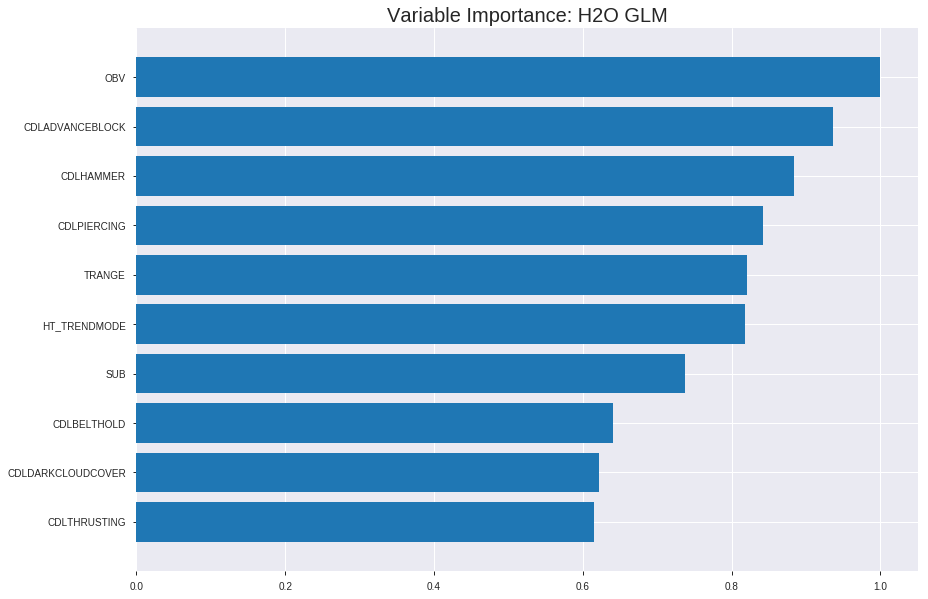

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_151730_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24325043337316413
RMSE: 0.4932042511710175
LogLoss: 0.6795194262979803
Null degrees of freedom: 1752
Residual degrees of freedom: 713
Null deviance: 2429.8722379876026
Residual deviance: 2382.395108600719
AIC: 4462.395108600719
AUC: 0.6118314846638546
pr_auc: 0.60895376232353
Gini: 0.22366296932770924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4339734954866058: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      57   808   0.9341   (808.0/865.0)
1      14   874   0.0158   (14.0/888.0)
Total  71   1682  0.4689   (822.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433973     0.680156  353
max f2                       0.352551     0.837578  395
max f0point5                 0.503486     0.596999  207
max accuracy                 0.504112     0.589846  205
max precision                0.642587     1         0
max recall                   0.352551     1         395
max specificity              0.642587     1         0
max absolute_mcc             0.503486     0.179277  207
max min_per_class_accuracy   0.508382     0.586127  194
max mean_per_class_accuracy  0.504112     0.589289  205

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.600822           1.75475   1.75475            0.888889         0.6136    0.888889                    0.6136              0.018018        0.018018                   75.4755   75.4755
    2        0.0205362                   0.58736            1.53541   1.64508            0.777778         0.594003  0.833333                    0.603802            0.0157658       0.0337838                  53.541    64.5083
    3        0.0302339                   0.577294           1.16123   1.48989            0.588235         0.581917  0.754717                    0.596782            0.0112613       0.045045                   16.1235   48.9886
    4        0.040502                    0.573194           1.64508   1.52923            0.833333         0.574964  0.774648                    0.591251            0.0168919       0.0619369                  64.5083   52.9232
    5        0.0501997                   0.569644           0.812864  1.39084            0.411765         0.571268  0.704545                    0.58739             0.00788288      0.0698198                  -18.7136  39.0843
    6        0.100399                    0.557416           1.30111   1.34598            0.659091         0.563325  0.681818                    0.575358            0.0653153       0.135135                   30.1111   34.5977
    7        0.150029                    0.54746            1.17992   1.29105            0.597701         0.551787  0.653992                    0.567561            0.0585586       0.193694                   17.9921   29.1046
    8        0.200228                    0.541051           1.09921   1.24295            0.556818         0.544074  0.62963                     0.561672            0.0551802       0.248874                   9.92143   24.2951
    9        0.300057                    0.527598           1.11678   1.20097            0.565714         0.533927  0.608365                    0.552441            0.111486        0.36036                    11.6776   20.0973
    10       0.399886                    0.51724            1.09421   1.17432            0.554286         0.522032  0.594864                    0.54485             0.109234        0.469595                   9.42149   17.4321
    11       0.500285                    0.508258           1.14408   1.16825            0.579545         0.512728  0.59179                     0.538403            0.114865        0.584459                   14.408    16.8252
    12       0.600114                    0.498559           0.936287  1.12967            0.474286         0.503419  0.572243                    0.532584            0.0934685       0.677928                   -6.3713   12.9665
    13       0.699943                    0.487736           0.925006  1.10048            0.468571         0.493449  0.557457                    0.527002            0.0923423       0.77027                    -7.49936  10.0476
    14       0.799772                    0.474987           0.868604  1.07153            0.44             0.48113   0.542796                    0.521276            0.0867117       0.856982                   -13.1396  7.15331
    15       0.899601                    0.45552            0.823481  1.04401            0.417143         0.466647  0.528852                    0.515214            0.0822072       0.939189                   -17.6519  4.40068
    16       1                           0.202001           0.605689  1                  0.306818         0.429018  0.50656                     0.50656          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24755436816005988
RMSE: 0.4975483576096497
LogLoss: 0.688200278453807
Null degrees of freedom: 500
Residual degrees of freedom: -539
Null deviance: 693.6487637448975
Residual deviance: 689.5766790107147
AIC: 2769.5766790107145
AUC: 0.5547766312011281
pr_auc: 0.5979077503384402
Gini: 0.10955326240225616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3482705354161763: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    269  0        (0.0/269.0)
Total  1    500  0.4611   (231.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348271     0.69961   398
max f2                       0.348271     0.853426  398
max f0point5                 0.46264      0.603231  330
max accuracy                 0.480478     0.56487   271
max precision                0.711913     1         0
max recall                   0.348271     1         398
max specificity              0.711913     1         0
max absolute_mcc             0.559705     0.128886  31
max min_per_class_accuracy   0.498972     0.546468  201
max mean_per_class_accuracy  0.486649     0.551948  247

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 50.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.584448           1.55204   1.55204            0.833333         0.617708  0.833333                    0.617708            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.573201           1.48996   1.52383            0.8              0.577983  0.818182                    0.599651            0.0148699       0.0334572                  48.9963   52.3826
    3        0.0319361                   0.569175           1.86245   1.62965            1                0.571073  0.875                       0.59072             0.0185874       0.0520446                  86.2454   62.9647
    4        0.0419162                   0.56568            1.11747   1.5077             0.6              0.56739   0.809524                    0.585165            0.0111524       0.063197                   11.7472   50.77
    5        0.0518962                   0.562879           1.48996   1.50429            0.8              0.564167  0.807692                    0.581127            0.0148699       0.0780669                  48.9963   50.4289
    6        0.101796                    0.547673           0.968476  1.24164            0.52             0.556766  0.666667                    0.569186            0.0483271       0.126394                   -3.15242  24.1636
    7        0.151697                    0.541094           0.968476  1.15178            0.52             0.544551  0.618421                    0.561082            0.0483271       0.174721                   -3.15242  15.178
    8        0.201597                    0.53325            0.893978  1.08797            0.48             0.537392  0.584158                    0.555218            0.0446097       0.219331                   -10.6022  8.79679
    9        0.301397                    0.520173           0.968476  1.0484             0.52             0.526921  0.562914                    0.545848            0.0966543       0.315985                   -3.15242  4.8401
    10       0.401198                    0.508651           1.00572   1.03779            0.54             0.514129  0.557214                    0.537958            0.100372        0.416357                   0.572491  3.77851
    11       0.500998                    0.499687           1.26647   1.08334            0.68             0.504121  0.581673                    0.531218            0.126394        0.542751                   26.6468   8.33395
    12       0.600798                    0.489576           1.00572   1.07045            0.54             0.494399  0.574751                    0.525101            0.100372        0.643123                   0.572491  7.04467
    13       0.700599                    0.478542           0.968476  1.05592            0.52             0.48389   0.566952                    0.519231            0.0966543       0.739777                   -3.15242  5.59209
    14       0.800399                    0.46924            0.81948   1.02644            0.44             0.473901  0.551122                    0.513579            0.0817844       0.821561                   -18.052   2.64395
    15       0.9002                      0.45655            0.856729  1.00762            0.46             0.463048  0.54102                     0.507977            0.0855019       0.907063                   -14.3271  0.762453
    16       1                           0.341059           0.931227  1                  0.5              0.4304    0.536926                    0.500234            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:17:33  0.000 sec   2            3.7       1040          1.37592           1.38059
    2019-08-25 15:17:35  2.039 sec   4            2.7       1040          1.37354           1.37962
    2019-08-25 15:17:37  4.112 sec   6            2         1040          1.37069           1.37865
    2019-08-25 15:17:39  6.184 sec   8            1.4       1040          1.36732           1.3777
    2019-08-25 15:17:41  8.279 sec   10           1         1040          1.36343           1.37688
    2019-08-25 15:17:43  10.349 sec  12           0.76      1040          1.35904           1.3764
    2019-08-25 15:17:45  12.408 sec  14           0.55      1040          1.35423           1.37645
    2019-08-25 15:17:48  14.548 sec  16           0.4       1040          1.3491            1.37726
    2019-08-25 15:17:50  16.621 sec  18           0.29      1040          1.34377           1.37913
    2019-08-25 15:17:52  18.789 sec  20           0.21      1040          1.33837           1.38228
    2019-08-25 15:17:54  20.874 sec  22           0.15      1040          1.33298           1.38683

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6522911051212937)

('auc', 0.5155753337571519)

('logloss', 0.6919578343718502)

('mean_per_class_error', 0.45238397965670685)

('rmse', 0.4996644857853936)

('mse', 0.24966459835518176)

glm prediction progress: |████████████████████████████████████████████████| 100%


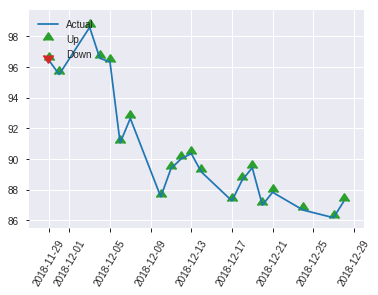


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24966459835518176
RMSE: 0.4996644857853936
LogLoss: 0.6919578343718502
Null degrees of freedom: 250
Residual degrees of freedom: -789
Null deviance: 348.2392766240658
Residual deviance: 347.3628328546688
AIC: 2427.362832854669
AUC: 0.5155753337571519
pr_auc: 0.5047996122876939
Gini: 0.031150667514303843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.423757183932229: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    129  0.9923   (129.0/130.0)
1      0    121  0        (0.0/121.0)
Total  1    250  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423757     0.652291  249
max f2                       0.423757     0.824251  249
max f0point5                 0.445126     0.541028  246
max accuracy                 0.536221     0.557769  53
max precision                0.926857     1         0
max recall                   0.423757     1         249
max specificity              0.926857     1         0
max absolute_mcc             0.536221     0.115802  53
max min_per_class_accuracy   0.508054     0.515385  125
max mean_per_class_accuracy  0.536221     0.547616  53

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 51.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.58412            1.38292   1.38292            0.666667         0.70101   0.666667                    0.70101             0.0165289       0.0165289                  38.292    38.292
    2        0.0239044                   0.577817           0.69146   1.03719            0.333333         0.580264  0.5                         0.640637            0.00826446      0.0247934                  -30.854   3.71901
    3        0.0318725                   0.573952           1.03719   1.03719            0.5              0.576253  0.5                         0.624541            0.00826446      0.0330579                  3.71901   3.71901
    4        0.0438247                   0.57153            1.38292   1.13148            0.666667         0.572504  0.545455                    0.610349            0.0165289       0.0495868                  38.292    13.148
    5        0.0517928                   0.57048            1.03719   1.11697            0.5              0.571251  0.538462                    0.604334            0.00826446      0.0578512                  3.71901   11.6974
    6        0.103586                    0.555411           1.11697   1.11697            0.538462         0.560961  0.538462                    0.582647            0.0578512       0.115702                   11.6974   11.6974
    7        0.151394                    0.547797           1.38292   1.20096            0.666667         0.551564  0.578947                    0.572831            0.0661157       0.181818                   38.292    20.0957
    8        0.203187                    0.540046           1.11697   1.17955            0.538462         0.544205  0.568627                    0.565534            0.0578512       0.239669                   11.6974   17.955
    9        0.302789                    0.528997           0.829752  1.06448            0.4              0.533399  0.513158                    0.554964            0.0826446       0.322314                   -17.0248  6.44846
    10       0.40239                     0.516323           0.912727  1.02692            0.44             0.52263   0.49505                     0.54696             0.0909091       0.413223                   -8.72727  2.69209
    11       0.501992                    0.508054           1.07868   1.03719            0.52             0.511931  0.5                         0.54001             0.107438        0.520661                   7.86777   3.71901
    12       0.601594                    0.501567           0.912727  1.01658            0.44             0.504713  0.490066                    0.534166            0.0909091       0.61157                    -8.72727  1.65837
    13       0.701195                    0.491506           0.829752  0.990045           0.4              0.496425  0.477273                    0.528805            0.0826446       0.694215                   -17.0248  -0.995492
    14       0.800797                    0.482649           1.16165   1.01139            0.56             0.486214  0.487562                    0.523508            0.115702        0.809917                   16.1653   1.13893
    15       0.900398                    0.467115           0.746777  0.982118           0.36             0.476351  0.473451                    0.518291            0.0743802       0.884298                   -25.3223  -1.7882
    16       1                           0.367054           1.16165   1                  0.56             0.451957  0.482072                    0.511684          

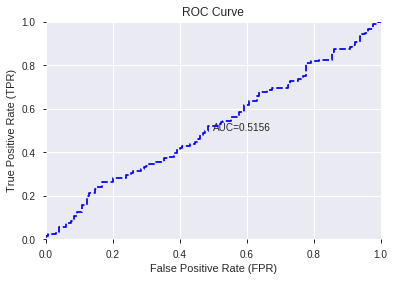

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


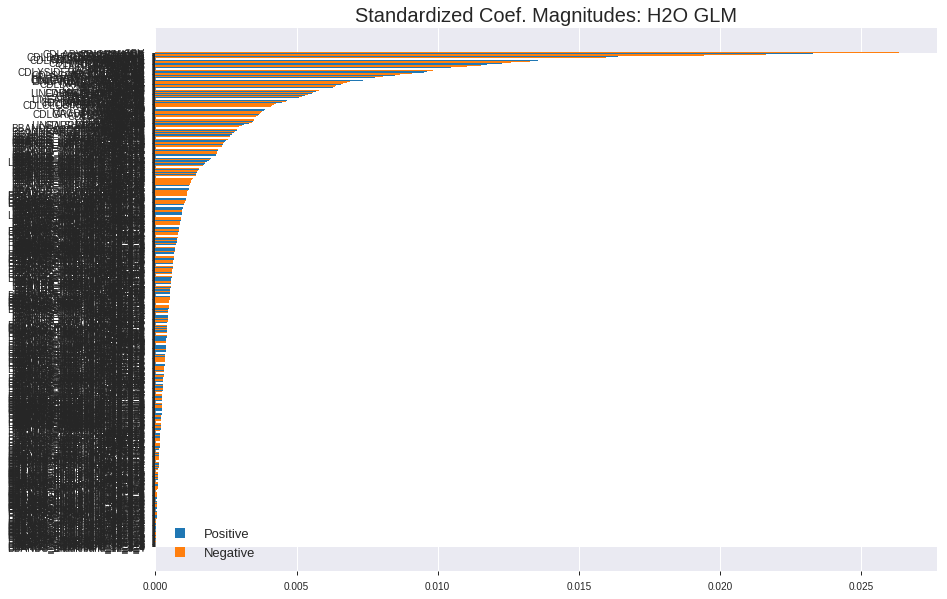

'log_likelihood'
--2019-08-25 15:18:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_151730_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_151730_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['OBV',
 'CDLADVANCEBLOCK',
 'CDLHAMMER',
 'CDLPIERCING',
 'TRANGE',
 'HT_TRENDMODE',
 'SUB',
 'CDLBELTHOLD',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'MFI_24',
 'ADXR_12',
 'CDLHARAMICROSS',
 'CDLMORNINGSTAR',
 'CDLINVERTEDHAMMER',
 'aroonup_8',
 'AROONOSC_8',
 'ADXR_14',
 'CORREL_20',
 'aroonup_14',
 'CDLMATCHINGLOW',
 'CDL2CROWS',
 'ADXR_8',
 'CDLLONGLINE',
 'MFI_30',
 'CDLHIKKAKEMOD',
 'CDLINNECK',
 'aroonup_12',
 'ADX_14',
 'DIV',
 'TAN',
 'aroondown_8',
 'COSH',
 'SINH',
 'EXP',
 'ADX_12',
 'CDLMARUBOZU',
 'ADX_20',
 'MFI_14',
 'AROONOSC_14',
 'CDLXSIDEGAP3METHODS',
 'PLUS_DI_30',
 'day',
 'AROONOSC_12',
 'CDLTAKURI',
 'COS',
 'CDLTASUKIGAP',
 'CDLSEPARATINGLINES',
 'AD',
 'ADX_24',
 'PLUS_DI_24',
 'HT_PHASOR_quadrature',
 'LINEARREG_ANGLE_24',
 'is_quarter_start',
 'STDDEV_24',
 'DX_30',
 'LINEARREG_SLOPE_24',
 'CDLEVENINGDOJISTAR',
 'MACDFIX_hist_24',
 'WILLR_30',
 'MACDFIX_hist_20',
 'ATR_8',
 'WILLR_24',
 'aroondown_20',
 'SIN',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'MOM_20'

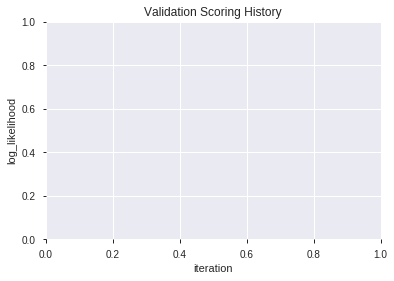

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_151821_model_1  0.535092  0.698286              0.496154  0.502427  0.252433
1  XGBoost_grid_1_AutoML_20190825_151821_model_4  0.523140  0.695379              0.500000  0.501022  0.251023
2  XGBoost_grid_1_AutoML_20190825_151821_model_5  0.521996  0.713785              0.474221  0.509290  0.259376
3  XGBoost_grid_1_AutoML_20190825_151821_model_6  0.514367  0.709189              0.500000  0.507644  0.257702
4               XGBoost_1_AutoML_20190825_151821  0.503433  0.712760              0.500000  0.509062  0.259144
5               XGBoost_3_AutoML_20190825_151821  0.494660  0.707512              0.500000  0.506852  0.256899
6               XGBoost_2_AutoML_20190825_151821  0.479021  0.715368              0.496154  0.510642  0.260755
7  XGBoost_grid_1_AutoML_20190825_151821_model_7  0.477432  0.730414              0.500000  0.517434  0.267738
8  XGBoost_grid_1_AutoML_20190825_151821_model_2  0.469549  0.707953              0.496154  0.507182  0.257234
9  XGBoost_grid_1_AutoML_20190825_151821_model_3  0.465289  0.718940              0.500000  0.512220  0.262369

variable  relative_importance  scaled_importance  percentage
0    BBANDS_upperband_12_6_5           112.144218           1.000000    0.025307
1                  dayofyear           100.141541           0.892971    0.022598
2                  CORREL_20            95.135277           0.848330    0.021468
3                        SUB            90.432587           0.806395    0.020407
4                        BOP            89.697464           0.799840    0.020241
..                       ...                  ...                ...         ...
211   BBANDS_upperband_8_6_5             4.888176           0.043588    0.001103
212                   MFI_30             4.857887           0.043318    0.001096
213              MINUS_DM_20             4.124277           0.036777    0.000931
214  BBANDS_upperband_14_0_5             3.654745           0.032590    0.000825
215   BBANDS_upperband_8_3_3             3.196421           0.028503    0.000721

[216 rows x 4 columns]

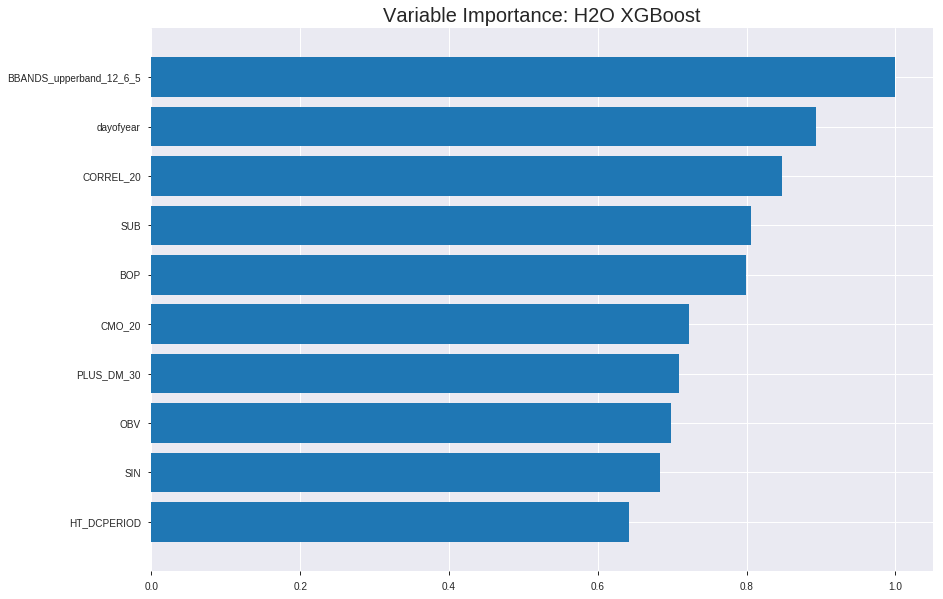

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_151821_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18998557749844877
RMSE: 0.4358733502962171
LogLoss: 0.570002135959613
Mean Per-Class Error: 0.14233778576264133
AUC: 0.9313440608238296
pr_auc: 0.9304554354454947
Gini: 0.8626881216476592
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4918547123670578: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      671  194   0.2243   (194.0/865.0)
1      69   819   0.0777   (69.0/888.0)
Total  740  1013  0.15     (263.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491855     0.861652  214
max f2                       0.4655       0.909763  243
max f0point5                 0.521666     0.872919  178
max accuracy                 0.515693     0.857387  185
max precision                0.790453     1         0
max recall                   0.349177     1         344
max specificity              0.790453     1         0
max absolute_mcc             0.515693     0.715641  185
max min_per_class_accuracy   0.510594     0.850225  191
max mean_per_class_accuracy  0.515693     0.857662  185

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.71454            1.9741     1.9741             1                0.747319  1                           0.747319            0.0202703       0.0202703                  97.4099   97.4099
    2        0.0205362                   0.695773           1.9741     1.9741             1                0.703262  1                           0.725291            0.0202703       0.0405405                  97.4099   97.4099
    3        0.0302339                   0.686504           1.9741     1.9741             1                0.688879  1                           0.713612            0.0191441       0.0596847                  97.4099   97.4099
    4        0.040502                    0.672095           1.9741     1.9741             1                0.679113  1                           0.704866            0.0202703       0.079955                   97.4099   97.4099
    5        0.0501997                   0.66367            1.9741     1.9741             1                0.667713  1                           0.697688            0.0191441       0.0990991                  97.4099   97.4099
    6        0.100399                    0.634466           1.95167    1.96288            0.988636         0.646797  0.994318                    0.672242            0.097973        0.197072                   95.1666   96.2883
    7        0.150029                    0.607486           1.86065    1.92906            0.942529         0.621495  0.977186                    0.655455            0.0923423       0.289414                   86.0645   92.9063
    8        0.200228                    0.588442           1.9068     1.92348            0.965909         0.598364  0.974359                    0.641142            0.0957207       0.385135                   90.68     92.3481
    9        0.300057                    0.557403           1.77105    1.87277            0.897143         0.571898  0.948669                    0.618104            0.176802        0.561937                   77.1049   87.2767
    10       0.399886                    0.534258           1.61312    1.80795            0.817143         0.546279  0.915835                    0.600174            0.161036        0.722973                   61.3121   80.7948
    11       0.500285                    0.511188           1.25624    1.69723            0.636364         0.522503  0.859749                    0.584586            0.126126        0.849099                   25.6245   69.723
    12       0.600114                    0.48655            0.857323   1.55751            0.434286         0.498775  0.788973                    0.570312            0.0855856       0.934685                   -14.2677  55.7512
    13       0.699943                    0.456351           0.39482    1.39168            0.2              0.472167  0.704971                    0.556314            0.0394144       0.974099                   -60.518   39.1684
    14       0.799772                    0.424405           0.19177    1.24191            0.0971429        0.441127  0.629101                    0.541936            0.0191441       0.993243                   -80.823   24.1908
    15       0.899601                    0.373881           0.0564028  1.11035            0.0285714        0.40161   0.56246                     0.526364            0.00563063      0.998874                   -94.3597  11.0353
    16       1                           0.178232           0.0112165  1                  0.00568182       0.324347  0.50656                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24512633905623032
RMSE: 0.4951023521012906
LogLoss: 0.6833136570523473
Mean Per-Class Error: 0.43415107037559286
AUC: 0.568292526599154
pr_auc: 0.5912797963945705
Gini: 0.13658505319830794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30908167362213135: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    229  0.9871   (229.0/232.0)
1      0    269  0        (0.0/269.0)
Total  3    498  0.4571   (229.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309082     0.701434  396
max f2                       0.309082     0.854511  396
max f0point5                 0.487844     0.607369  283
max accuracy                 0.507364     0.57485   245
max precision                0.702319     1         0
max recall                   0.309082     1         396
max specificity              0.702319     1         0
max absolute_mcc             0.507364     0.135773  245
max min_per_class_accuracy   0.529608     0.547414  194
max mean_per_class_accuracy  0.507364     0.565849  245

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 52.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.668301           1.55204   1.55204            0.833333         0.684442  0.833333                    0.684442            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.657529           1.48996   1.52383            0.8              0.6621    0.818182                    0.674286            0.0148699       0.0334572                  48.9963   52.3826
    3        0.0319361                   0.640221           1.11747   1.39684            0.6              0.64201   0.75                        0.6642              0.0111524       0.0446097                  11.7472   39.684
    4        0.0419162                   0.637888           0.744981  1.24164            0.4              0.638393  0.666667                    0.658055            0.00743494      0.0520446                  -25.5019  24.1636
    5        0.0518962                   0.634115           0.744981  1.14613            0.4              0.634622  0.615385                    0.653549            0.00743494      0.0594796                  -25.5019  14.6125
    6        0.101796                    0.609021           0.968476  1.05904            0.52             0.62159   0.568627                    0.637883            0.0483271       0.107807                   -3.15242  5.90422
    7        0.151697                    0.595749           1.41546   1.17629            0.76             0.601639  0.631579                    0.62596             0.070632        0.178439                   41.5465   17.6286
    8        0.201597                    0.584991           1.11747   1.16173            0.6              0.589175  0.623762                    0.616855            0.0557621       0.234201                   11.7472   16.1728
    9        0.301397                    0.565259           1.08022   1.13474            0.58             0.574725  0.609272                    0.602905            0.107807        0.342007                   8.0223    13.474
    10       0.401198                    0.552034           0.968476  1.09338            0.52             0.558086  0.587065                    0.591756            0.0966543       0.438662                   -3.15242  9.33807
    11       0.500998                    0.52976            1.04297   1.08334            0.56             0.54039   0.581673                    0.581524            0.104089        0.542751                   4.2974    8.33395
    12       0.600798                    0.511573           1.11747   1.08901            0.6              0.521594  0.584718                    0.571569            0.111524        0.654275                   11.7472   8.90094
    13       0.700599                    0.497591           0.893978  1.06123            0.48             0.504554  0.569801                    0.562022            0.0892193       0.743494                   -10.6022  6.12271
    14       0.800399                    0.467837           0.893978  1.04037            0.48             0.482505  0.558603                    0.552107            0.0892193       0.832714                   -10.6022  4.0373
    15       0.9002                      0.431378           0.931227  1.02827            0.5              0.449115  0.552106                    0.540689            0.0929368       0.925651                   -6.87732  2.82726
    16       1                           0.302744           0.744981  1                  0.4              0.390539  0.536926                    0.525704            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:18:35  0.011 sec   0                  0.5              0.693147            0.5             0                  1                0.49344                          0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-25 15:18:36  0.628 sec   5                  0.491245         0.675744            0.725385        0.730016           1.7663           0.363948                         0.497384           0.68792               0.544954          0.560088             0.931227           0.441118
    2019-08-25 15:18:36  0.814 sec   10                 0.483665         0.660832            0.789278        0.785979           1.9741           0.309184                         0.496265           0.68568               0.564255          0.569933             0.931227           0.439122
    2019-08-25 15:18:36  0.991 sec   15                 0.478226         0.650166            0.802922        0.795252           1.8702           0.311466                         0.496602           0.686332              0.543568          0.568221             1.06426            0.431138
    2019-08-25 15:18:36  1.165 sec   20                 0.473324         0.640607            0.821025        0.815229           1.9741           0.288078                         0.496557           0.686225              0.547334          0.571483             1.24164            0.437126
    2019-08-25 15:18:36  1.350 sec   25                 0.467419         0.629219            0.844393        0.840887           1.9741           0.239019                         0.496151           0.685384              0.547718          0.582078             1.55204            0.439122
    2019-08-25 15:18:37  1.546 sec   30                 0.461114         0.617141            0.866714        0.866164           1.9741           0.218483                         0.495447           0.683968              0.557453          0.589709             1.86245            0.441118
    2019-08-25 15:18:37  1.758 sec   35                 0.455353         0.606179            0.883386        0.88549            1.9741           0.20308                          0.496125           0.685343              0.551123          0.579742             1.55204            0.443114
    2019-08-25 15:18:37  1.963 sec   40                 0.447998         0.592397            0.905244        0.905104           1.9741           0.183115                         0.496459           0.686041              0.552878          0.576874             1.55204            0.453094
    2019-08-25 15:18:37  2.168 sec   45                 0.442065         0.581404            0.918716        0.918531           1.9741           0.163149                         0.496032           0.685137              0.558142          0.587302             1.55204            0.451098
    2019-08-25 15:18:37  2.372 sec   50                 0.435873         0.570002            0.931344        0.930455           1.9741           0.150029                         0.495102           0.683314              0.568293          0.59128              1.55204            0.457086

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BBANDS_upperband_12_6_5  112.14421844482422     1.0                   0.025306692724062017
dayofyear                100.14154052734375     0.8929710502785672    0.022598143980882637
CORREL_20                95.1352767944336       0.8483297499749473    0.02146842031129635
SUB                      90.43258666992188      0.8063954426185187    0.020407201680430836
BOP                      89.69746398925781      0.7998402880964356    0.020241312399181737
---                      ---                    ---                   ---
BBANDS_upperband_8_6_5   4.888175964355469      0.043588301137079906  0.0011030757432399642
MFI_30                   4.857887268066406      0.043318214130285485  0.001096240734350256
MINUS_DM_20              4.124277114868164      0.03677654695054421   0.0009306927731294624
BBANDS_upperband_14_0_5  3.654745101928711      0.032589688105293384  0.0008247372228536786
BBANDS_upperband_8_3_3   3.196420669555664      0.02850276825575566   0.0007213107980335576


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6522911051212937)

('auc', 0.535092180546726)

('logloss', 0.6982860846886665)

('mean_per_class_error', 0.4514939605848697)

('rmse', 0.5024274490039256)

('mse', 0.25243334151259217)

xgboost prediction progress: |████████████████████████████████████████████| 100%


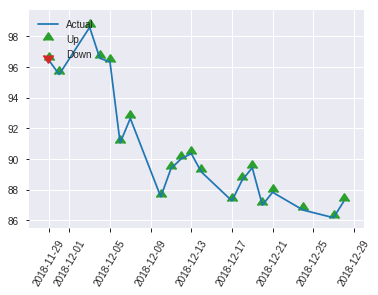


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25243334151259217
RMSE: 0.5024274490039256
LogLoss: 0.6982860846886665
Mean Per-Class Error: 0.4514939605848697
AUC: 0.535092180546726
pr_auc: 0.5081910669568707
Gini: 0.07018436109345205
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31412163376808167: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    129  0.9923   (129.0/130.0)
1      0    121  0        (0.0/121.0)
Total  1    250  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314122     0.652291  249
max f2                       0.314122     0.824251  249
max f0point5                 0.460776     0.548317  199
max accuracy                 0.549087     0.553785  76
max precision                0.668227     0.666667  2
max recall                   0.314122     1         249
max specificity              0.675747     0.992308  0
max absolute_mcc             0.549087     0.101672  76
max min_per_class_accuracy   0.524923     0.512397  115
max mean_per_class_accuracy  0.524923     0.548506  115

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.66691            1.38292   1.38292            0.666667         0.673207  0.666667                    0.673207            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.659396           0         0.69146            0                0.662795  0.333333                    0.668001            0               0.0165289                  -100       -30.854
    3        0.0318725                   0.643198           1.03719   0.777893           0.5              0.648899  0.375                       0.663226            0.00826446      0.0247934                  3.71901    -22.2107
    4        0.0438247                   0.629984           1.38292   0.9429             0.666667         0.637613  0.454545                    0.65624             0.0165289       0.0413223                  38.292     -5.70999
    5        0.0517928                   0.619989           0         0.797839           0                0.6252    0.384615                    0.651465            0               0.0413223                  -100       -20.2161
    6        0.103586                    0.594912           1.43611   1.11697            0.692308         0.603593  0.538462                    0.627529            0.0743802       0.115702                   43.6109    11.6974
    7        0.151394                    0.578266           1.03719   1.09178            0.5              0.588344  0.526316                    0.615155            0.0495868       0.165289                   3.71901    9.1779
    8        0.203187                    0.569701           1.43611   1.17955            0.692308         0.573343  0.568627                    0.604497            0.0743802       0.239669                   43.6109    17.955
    9        0.302789                    0.54917            1.07868   1.14637            0.52             0.557991  0.552632                    0.589199            0.107438        0.347107                   7.86777    14.6368
    10       0.40239                     0.534017           0.912727  1.08854            0.44             0.540877  0.524752                    0.577238            0.0909091       0.438017                   -8.72727   8.85361
    11       0.501992                    0.515996           0.746777  1.02073            0.36             0.525223  0.492063                    0.566918            0.0743802       0.512397                   -25.3223   2.07267
    12       0.601594                    0.501825           1.07868   1.03032            0.52             0.509045  0.496689                    0.557336            0.107438        0.619835                   7.86777    3.03213
    13       0.701195                    0.482515           0.912727  1.01362            0.44             0.491043  0.488636                    0.547919            0.0909091       0.710744                   -8.72727   1.36176
    14       0.800797                    0.460603           1.24463   1.04235            0.6              0.468687  0.502488                    0.538065            0.123967        0.834711                   24.4628    4.23502
    15       0.900398                    0.416395           0.663802  1.00048            0.32             0.438719  0.482301                    0.527075            0.0661157       0.900826                   -33.6198   0.0475389
    16       1                           0.273284           0.995702  1                  0.48             0.368667  0.482072                  

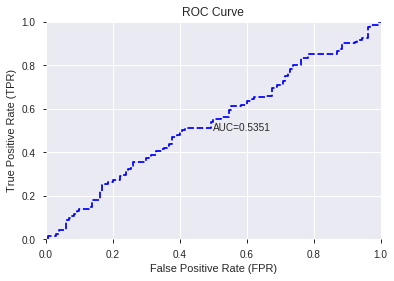

This function is available for GLM models only


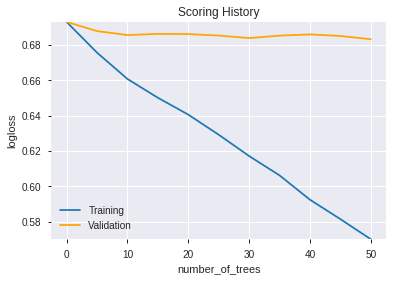

--2019-08-25 15:19:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_151821_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_151821_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BBANDS_upperband_12_6_5',
 'dayofyear',
 'CORREL_20',
 'SUB',
 'BOP',
 'CMO_20',
 'PLUS_DM_30',
 'OBV',
 'SIN',
 'HT_DCPERIOD',
 'WILLR_20',
 'HT_PHASOR_quadrature',
 'STDDEV_24',
 'CORREL_30',
 'MFI_24',
 'Volume',
 'BBANDS_upperband_20_0_2',
 'ADXR_12',
 'STOCHF_fastk',
 'APO',
 'MFI_12',
 'PLUS_DI_30',
 'BETA_14',
 'CCI_20',
 'ADXR_8',
 'BETA_8',
 'TRIX_8',
 'TRANGE',
 'STDDEV_8',
 'ULTOSC',
 'TAN',
 'dayofweek',
 'day',
 'STDDEV_12',
 'MFI_14',
 'aroonup_24',
 'STOCHRSI_fastd',
 'AROONOSC_8',
 'BETA_30',
 'BBANDS_upperband_24_1_5',
 'ADX_20',
 'ADX_24',
 'DX_8',
 'ADX_14',
 'STOCHRSI_fastk',
 'PLUS_DM_8',
 'DIV',
 'MFI_20',
 'ROC_14',
 'BBANDS_lowerband_14_4_3',
 'LINEARREG_ANGLE_12',
 'STOCH_slowk',
 'aroondown_8',
 'MACDEXT_signal',
 'MACDEXT_hist',
 'ATR_8',
 'MACDFIX_hist_12',
 'WILLR_24',
 'BBANDS_upperband_8_0_4',
 'MOM_30',
 'LINEARREG_ANGLE_8',
 'ADX_12',
 'ROCP_14',
 'MACDFIX_hist_24',
 'BBANDS_upperband_30_5_3',
 'BETA_24',
 'SAREXT',
 'LINEARREG_ANGLE_24',
 'ATR_30',
 

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

202

['MIDPRICE_14',
 'SAR_0.14',
 'SMA_14',
 'TEMA_14',
 'TRIMA_14',
 'WMA_14',
 'MA_14_0',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_14_0_5',
 'MA_14_1',
 'BBANDS_middleband_14_1_2',
 'BBANDS_upperband_14_1_3',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_lowerband_14_1_4',
 'MAVP_14_2',
 'BBANDS_middleband_14_2_2',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_upperband_14_2_5',
 'BBANDS_lowerband_14_2_5',
 'BBANDS_middleband_14_3_2',
 'BBANDS_upperband_14_3_4',
 'BBANDS_upperband_14_3_5',
 'BBANDS_middleband_14_3_5',
 'BBANDS_middleband_14_4_5',
 'MA_14_5',
 'MAVP_14_5',
 'BBANDS_upperband_14_5_3',
 'BBANDS_middleband_14_5_4',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_lowerband_14_6_3',
 'BBANDS_middleband_14_7

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190825_152026  0.525747  0.751829              0.496154  0.521756  0.272229
1  DeepLearning_grid_1_AutoML_20190825_152026_model_9  0.516338  0.699852              0.467387  0.503331  0.253342
2  DeepLearning_grid_1_AutoML_20190825_152026_model_3  0.476351  0.870518              0.485188  0.563707  0.317765
3  DeepLearning_grid_1_AutoML_20190825_152026_model_2  0.475016  0.821378              0.500000  0.547788  0.300072
4  DeepLearning_grid_1_AutoML_20190825_152026_model_7  0.467832  0.789295              0.500000  0.536253  0.287568
5  DeepLearning_grid_1_AutoML_20190825_152026_model_8  0.465989  0.703010              0.500000  0.504882  0.254906
6  DeepLearning_grid_1_AutoML_20190825_152026_model_5  0.461062  0.698394              0.500000  0.502601  0.252608
7  DeepLearning_grid_1_AutoML_20190825_152026_model_6  0.457279  0.704191              0.473935  0.505425  0.255455
8  DeepLearning_grid_1_AutoML_20190825_152026_model_1  0.452956  1.506902              0.500000  0.632390  0.399918
9  DeepLearning_grid_1_AutoML_20190825_152026_model_4  0.438207  1.290365              0.488748  0.633547  0.401382

variable  relative_importance  scaled_importance  percentage
0                        OBV             1.000000           1.000000    0.009037
1                 aroonup_24             0.794571           0.794571    0.007180
2                      VAR_8             0.771866           0.771866    0.006975
3          HT_PHASOR_inphase             0.767217           0.767217    0.006933
4                     RSI_14             0.744964           0.744964    0.006732
..                       ...                  ...                ...         ...
197                    ATR_8             0.355394           0.355394    0.003212
198           CDLMATCHINGLOW             0.344049           0.344049    0.003109
199           MACDFIX_hist_8             0.330256           0.330256    0.002984
200           STOCHRSI_fastd             0.318351           0.318351    0.002877
201  BBANDS_lowerband_20_3_3             0.286406           0.286406    0.002588

[202 rows x 4 columns]

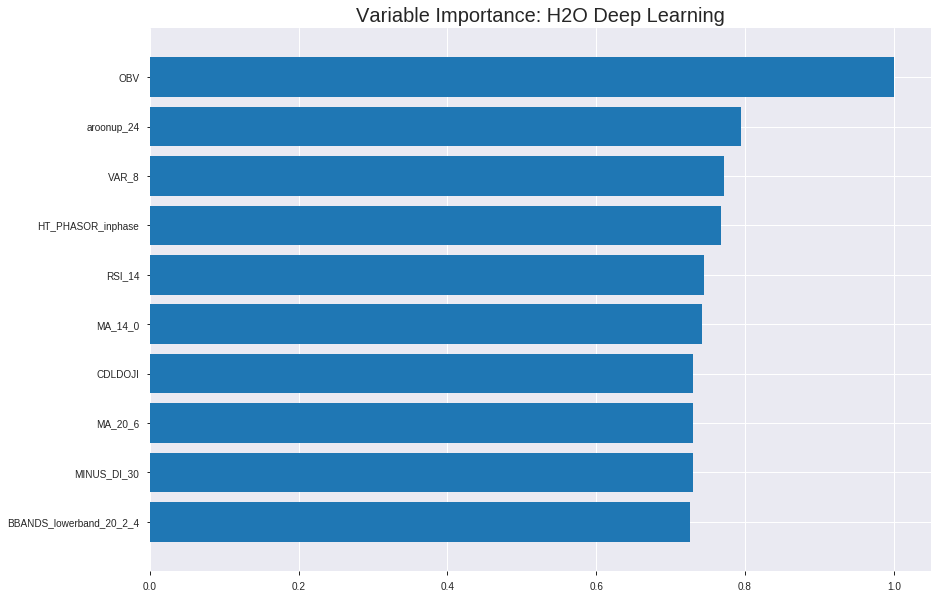

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190825_152026


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26326270408494035
RMSE: 0.5130913213892244
LogLoss: 0.7523360663428689
Mean Per-Class Error: 0.41234963286986415
AUC: 0.6083749934906004
pr_auc: 0.6075215813950927
Gini: 0.21674998698120085
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09897842040104121: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      32   833   0.963    (833.0/865.0)
1      11   877   0.0124   (11.0/888.0)
Total  43   1710  0.4815   (844.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0989784    0.675135  382
max f2                       0.0390292    0.837104  398
max f0point5                 0.436907     0.594934  248
max accuracy                 0.535667     0.587564  194
max precision                0.996529     1         0
max recall                   0.0390292    1         398
max specificity              0.996529     1         0
max absolute_mcc             0.535667     0.175296  194
max min_per_class_accuracy   0.532242     0.583333  196
max mean_per_class_accuracy  0.535667     0.58765   194

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 54.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.982592           1.75475   1.75475            0.888889         0.988695  0.888889                    0.988695            0.018018        0.018018                   75.4755   75.4755
    2        0.0205362                   0.970958           1.64508   1.69992            0.833333         0.976849  0.861111                    0.982772            0.0168919       0.0349099                  64.5083   69.9919
    3        0.0302339                   0.960932           1.50961   1.63887            0.764706         0.96414   0.830189                    0.976796            0.0146396       0.0495495                  50.9605   63.8875
    4        0.040502                    0.946373           1.31607   1.55704            0.666667         0.954433  0.788732                    0.971126            0.0135135       0.0630631                  31.6066   55.7036
    5        0.0501997                   0.939375           1.04511   1.45814            0.529412         0.942655  0.738636                    0.965626            0.0101351       0.0731982                  4.51113   45.8141
    6        0.100399                    0.882066           1.09921   1.27868            0.556818         0.912912  0.647727                    0.939269            0.0551802       0.128378                   9.92143   27.8678
    7        0.150029                    0.832866           1.13454   1.231              0.574713         0.860711  0.623574                    0.913282            0.0563063       0.184685                   13.454    23.0997
    8        0.200228                    0.769794           1.00948   1.17546            0.511364         0.801625  0.595442                    0.885288            0.0506757       0.23536                    0.948249  17.5461
    9        0.300057                    0.670107           1.31983   1.22349            0.668571         0.719717  0.619772                    0.830203            0.131757        0.367117                   31.9826   22.3491
    10       0.399886                    0.598345           1.11678   1.19685            0.565714         0.630712  0.606277                    0.780401            0.111486        0.478604                   11.6776   19.685
    11       0.500285                    0.530778           1.04313   1.166              0.528409         0.565589  0.59065                     0.737292            0.10473         0.583333                   4.31319   16.6002
    12       0.600114                    0.471108           0.936287  1.12779            0.474286         0.498512  0.571293                    0.697571            0.0934685       0.676802                   -6.3713   12.7789
    13       0.699943                    0.40298            0.970129  1.1053             0.491429         0.437944  0.559902                    0.660542            0.0968468       0.773649                   -2.98713  10.5302
    14       0.799772                    0.337481           0.755798  1.06168            0.382857         0.370588  0.537803                    0.624349            0.0754505       0.849099                   -24.4202  6.16767
    15       0.899601                    0.228279           0.710676  1.02273            0.36             0.283947  0.518072                    0.586575            0.0709459       0.920045                   -28.9324  2.2726
    16       1                           0.0304212          0.79637   1                  0.403409         0.147512  0.50656                     0.542493           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27648968450271555
RMSE: 0.5258228641878513
LogLoss: 0.7877024313890378
Mean Per-Class Error: 0.42898346365850526
AUC: 0.578675810793488
pr_auc: 0.5918177699076481
Gini: 0.1573516215869759
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15842558597193976: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      21   211  0.9095   (211.0/232.0)
1      4    265  0.0149   (4.0/269.0)
Total  25   476  0.4291   (215.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.158426     0.711409  376
max f2                       0.121345     0.856777  387
max f0point5                 0.259662     0.62206   326
max accuracy                 0.272525     0.592814  317
max precision                0.996044     1         0
max recall                   0.0939993    1         394
max specificity              0.996044     1         0
max absolute_mcc             0.259662     0.180637  326
max min_per_class_accuracy   0.492051     0.534483  200
max mean_per_class_accuracy  0.272525     0.571017  317

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 50.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.987421           1.55204   1.55204            0.833333         0.991205  0.833333                    0.991205            0.0185874       0.0185874                  55.2045   55.2045
    2        0.0219561                   0.98159            0.372491  1.01588            0.2              0.984262  0.545455                    0.988049            0.00371747      0.0223048                  -62.7509  1.58837
    3        0.0319361                   0.962071           1.48996   1.16403            0.8              0.968371  0.625                       0.9819              0.0148699       0.0371747                  48.9963   16.4033
    4        0.0419162                   0.953394           1.11747   1.15295            0.6              0.956684  0.619048                    0.975896            0.0111524       0.0483271                  11.7472   15.2947
    5        0.0518962                   0.936916           1.11747   1.14613            0.6              0.940503  0.615385                    0.96909             0.0111524       0.0594796                  11.7472   14.6125
    6        0.101796                    0.86192            1.11747   1.13208            0.6              0.89875   0.607843                    0.934609            0.0557621       0.115242                   11.7472   13.208
    7        0.151697                    0.817856           1.19197   1.15178            0.64             0.836587  0.618421                    0.902365            0.0594796       0.174721                   19.197    15.178
    8        0.201597                    0.750971           1.11747   1.14329            0.6              0.77739   0.613861                    0.871431            0.0557621       0.230483                   11.7472   14.3288
    9        0.301397                    0.640437           1.08022   1.12241            0.58             0.694642  0.602649                    0.812892            0.107807        0.33829                    8.0223    12.2406
    10       0.401198                    0.574364           1.11747   1.12118            0.6              0.606376  0.60199                     0.76152             0.111524        0.449814                   11.7472   12.1178
    11       0.500998                    0.494359           0.81948   1.06108            0.44             0.531753  0.569721                    0.715749            0.0817844       0.531599                   -18.052   6.10791
    12       0.600798                    0.407049           1.11747   1.07045            0.6              0.45204   0.574751                    0.671944            0.111524        0.643123                   11.7472   7.04467
    13       0.700599                    0.332751           1.11747   1.07715            0.6              0.372335  0.578348                    0.629265            0.111524        0.754647                   11.7472   7.71455
    14       0.800399                    0.272525           1.11747   1.08217            0.6              0.3022    0.581047                    0.588483            0.111524        0.866171                   11.7472   8.21737
    15       0.9002                      0.208085           0.633234  1.0324             0.34             0.240984  0.554324                    0.549958            0.063197        0.929368                   -36.6766  3.24022
    16       1                           0.0321755          0.707732  1                  0.38             0.147281  0.536926                    0.509771           


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:20:26  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:20:26  0.103 sec   34372 obs/sec     1         1             1753       0.57834          1.00982             -0.338138      0.54798         0.549646           1.42574          0.482031                         0.609078           1.199                 -0.492041        0.541966          0.564938             1.24164            0.459082
    2019-08-25 15:20:27  0.578 sec   35271 obs/sec     10        10            17530      0.513091         0.752336            -0.0532321     0.608375        0.607522           1.75475          0.48146                          0.525823           0.787702              -0.112024        0.578676          0.591818             1.55204            0.429142

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
OBV                      1.0                    1.0                  0.009036775243026436
aroonup_24               0.7945709824562073     0.7945709824562073   0.007180359383087447
VAR_8                    0.7718663215637207     0.7718663215637207   0.006975182465632914
HT_PHASOR_inphase        0.7672170996665955     0.7672170996665955   0.006933168492293636
RSI_14                   0.7449641227722168     0.7449641227722168   0.006732073341610876
---                      ---                    ---                  ---
ATR_8                    0.35539406538009644    0.35539406538009644  0.0032116162915453743
CDLMATCHINGLOW           0.34404921531677246    0.34404921531677246  0.0031090954313572816
MACDFIX_hist_8           0.3302564322948456     0.3302564322948456   0.002984453151212297
STOCHRSI_fastd           0.3183513879776001     0.3183513879776001   0.0028768699414590806
BBANDS_lowerband_20_3_3  0.2864059507846832     0.2864059507846832   0.0025881862055064735


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6522911051212937)

('auc', 0.5257469802924348)

('logloss', 0.7518285555505081)

('mean_per_class_error', 0.4482517482517483)

('rmse', 0.5217557366686358)

('mse', 0.27222904874663084)

deeplearning prediction progress: |███████████████████████████████████████| 100%


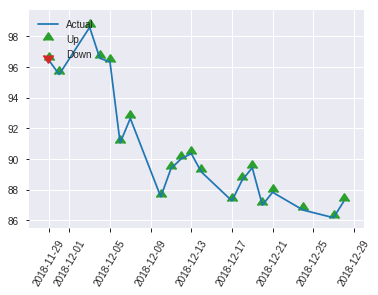


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27222904874663084
RMSE: 0.5217557366686358
LogLoss: 0.7518285555505081
Mean Per-Class Error: 0.4482517482517483
AUC: 0.5257469802924348
pr_auc: 0.5292320788061703
Gini: 0.05149396058486966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12860096618095676: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    129  0.9923   (129.0/130.0)
1      0    121  0        (0.0/121.0)
Total  1    250  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.128601     0.652291  249
max f2                       0.128601     0.824251  249
max f0point5                 0.272387     0.544218  226
max accuracy                 0.603932     0.561753  54
max precision                0.97725      1         0
max recall                   0.128601     1         249
max specificity              0.97725      1         0
max absolute_mcc             0.856587     0.133583  17
max min_per_class_accuracy   0.451378     0.487603  124
max mean_per_class_accuracy  0.603932     0.551748  54

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.950809           2.07438   2.07438            1                0.962403  1                           0.962403            0.0247934       0.0247934                  107.438    107.438
    2        0.0239044                   0.932263           0.69146   1.38292            0.333333         0.941193  0.666667                    0.951798            0.00826446      0.0330579                  -30.854    38.292
    3        0.0318725                   0.92258            2.07438   1.55579            1                0.927688  0.75                        0.945771            0.0165289       0.0495868                  107.438    55.5785
    4        0.0438247                   0.911104           0.69146   1.32006            0.333333         0.916756  0.636364                    0.937858            0.00826446      0.0578512                  -30.854    32.006
    5        0.0517928                   0.888756           1.03719   1.27654            0.5              0.888939  0.615385                    0.930332            0.00826446      0.0661157                  3.71901    27.6542
    6        0.103586                    0.766637           1.43611   1.35633            0.692308         0.83328   0.653846                    0.881806            0.0743802       0.140496                   43.6109    35.6325
    7        0.151394                    0.649547           0.518595  1.09178            0.25             0.701987  0.526316                    0.825021            0.0247934       0.165289                   -48.1405   9.1779
    8        0.203187                    0.615101           1.59568   1.22022            0.769231         0.630719  0.588235                    0.775493            0.0826446       0.247934                   59.5677    22.0224
    9        0.302789                    0.575029           0.912727  1.11907            0.44             0.590697  0.539474                    0.714705            0.0909091       0.338843                   -8.72727   11.9074
    10       0.40239                     0.511637           0.580826  0.985844           0.28             0.538688  0.475248                    0.671136            0.0578512       0.396694                   -41.9174   -1.4156
    11       0.501992                    0.449286           0.912727  0.971337           0.44             0.478461  0.468254                    0.632907            0.0909091       0.487603                   -8.72727   -2.86633
    12       0.601594                    0.404399           1.16165   1.00285            0.56             0.426093  0.483444                    0.598666            0.115702        0.603306                   16.1653    0.284604
    13       0.701195                    0.369508           1.07868   1.01362            0.52             0.386768  0.488636                    0.568567            0.107438        0.710744                   7.86777    1.36176
    14       0.800797                    0.335359           0.995702  1.01139            0.48             0.351438  0.487562                    0.541561            0.0991736       0.809917                   -0.429752  1.13893
    15       0.900398                    0.276768           1.07868   1.01883            0.52             0.311802  0.49115                     0.516145            0.107438        0.917355                   7.86777    1.88327
    16       1                           0.0792607          0.829752  1                  0.4              0.212372  0.482072                    0

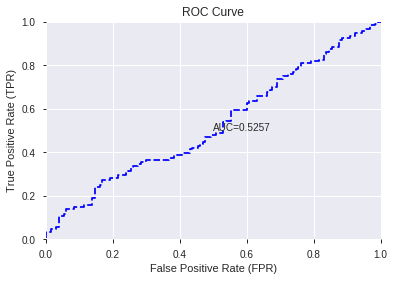

This function is available for GLM models only


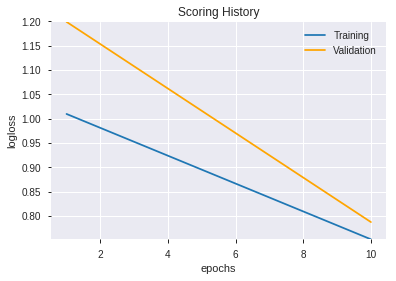

--2019-08-25 15:33:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190825_152026',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190825_152026',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_b594'

['OBV',
 'aroonup_24',
 'VAR_8',
 'HT_PHASOR_inphase',
 'RSI_14',
 'MA_14_0',
 'CDLDOJI',
 'MA_20_6',
 'MINUS_DI_30',
 'BBANDS_lowerband_20_2_4',
 'aroondown_14',
 'BBANDS_upperband_14_7_5',
 'BBANDS_lowerband_20_0_4',
 'MOM_12',
 'SAR_0.2',
 'BBANDS_upperband_20_6_5',
 'WCLPRICE',
 'CDLHARAMI',
 'ROCR_12',
 'BBANDS_middleband_24_7_3',
 'MACDEXT',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_14_0_4',
 'MINUS_DI_8',
 'BBANDS_middleband_14_3_5',
 'LINEARREG_SLOPE_12',
 'PLUS_DM_30',
 'BBANDS_lowerband_24_1_5',
 'AROONOSC_12',
 'aroondown_8',
 'BBANDS_middleband_20_6_4',
 'MFI_12',
 'MFI_30',
 'MINUS_DI_20',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_upperband_20_5_4',
 'BBANDS_upperband_14_3_5',
 'MACDFIX_20',
 'STOCH_slowk',
 'BETA_8',
 'BBANDS_lowerband_30_7_3',
 'MACDFIX_hist_12',
 'BOP',
 'LINEARREG_ANGLE_8',
 'TEMA_14',
 'DX_20',
 'PLUS_DM_12',
 'BBANDS_upperband_20_5_3',
 'BBANDS_upperband_20_3_5',
 'MAVP_20_5',
 'RSI_12',
 'STDDEV_8',
 'MAVP_20_0',
 'WILLR_14',
 'MINUS_DM_8',
 'MAVP_

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190825_153319_model_1  0.494406  0.699377              0.496154  0.50308  0.25309

variable  relative_importance  scaled_importance  percentage
0                      TRANGE             0.061578           1.000000    0.039459
1                         OBV             0.059722           0.969846    0.038269
2                      ADX_12             0.046370           0.753024    0.029713
3                      MFI_24             0.042344           0.687638    0.027133
4                   aroonup_8             0.041819           0.679121    0.026797
..                        ...                  ...                ...         ...
197  BBANDS_middleband_14_2_3             0.000058           0.000944    0.000037
198               LINEARREG_8             0.000037           0.000594    0.000023
199                     TSF_8             0.000035           0.000574    0.000023
200  BBANDS_middleband_14_2_2             0.000030           0.000483    0.000019
201                    RSI_12             0.000021           0.000336    0.000013

[202 rows x 4 columns]

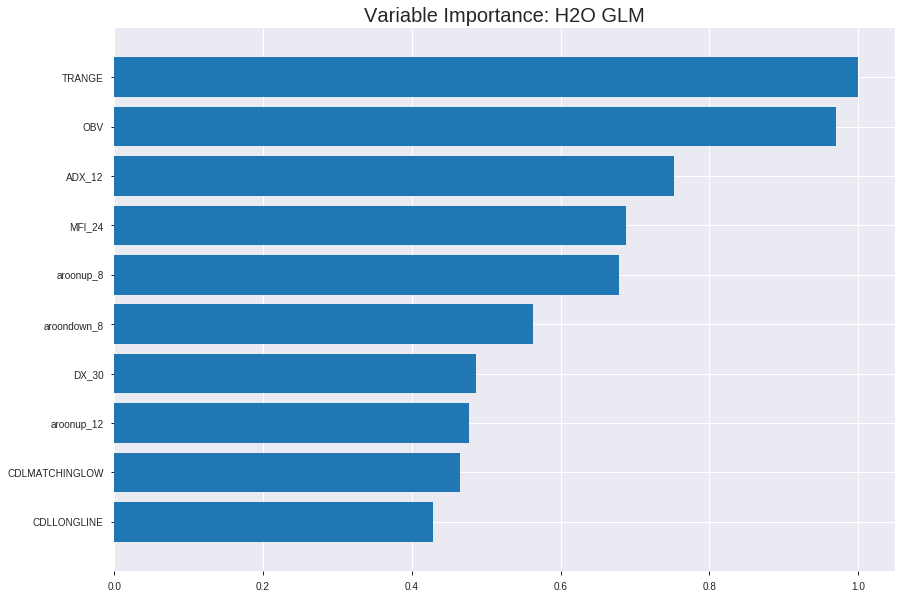

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_153319_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24479857379839287
RMSE: 0.49477123380244414
LogLoss: 0.6826869001275182
Null degrees of freedom: 1752
Residual degrees of freedom: 1550
Null deviance: 2429.8722379876026
Residual deviance: 2393.5002718470787
AIC: 2799.5002718470787
AUC: 0.596194605009634
pr_auc: 0.5824000479940176
Gini: 0.1923892100192679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.426332890611304: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      49   816   0.9434   (816.0/865.0)
1      23   865   0.0259   (23.0/888.0)
Total  72   1681  0.4786   (839.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426333     0.673414  356
max f2                       0.363713     0.83742   396
max f0point5                 0.49735      0.592308  219
max accuracy                 0.500805     0.581289  209
max precision                0.641178     1         0
max recall                   0.363713     1         396
max specificity              0.641178     1         0
max absolute_mcc             0.49735      0.163968  219
max min_per_class_accuracy   0.509261     0.573198  186
max mean_per_class_accuracy  0.500805     0.580259  209

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.598618           1.53541   1.53541            0.777778         0.612352  0.777778                    0.612352            0.0157658       0.0157658                  53.541    53.541
    2        0.0205362                   0.585465           1.09672   1.31607            0.555556         0.590357  0.666667                    0.601355            0.0112613       0.027027                   9.67217   31.6066
    3        0.0302339                   0.581237           1.50961   1.37814            0.764706         0.58327   0.698113                    0.595554            0.0146396       0.0416667                  50.9605   37.8145
    4        0.040502                    0.57773            1.20639   1.3346             0.611111         0.579318  0.676056                    0.591438            0.0123874       0.0540541                  20.6394   33.4602
    5        0.0501997                   0.574431           1.04511   1.27868            0.529412         0.575844  0.647727                    0.588425            0.0101351       0.0641892                  4.51113   27.8678
    6        0.100399                    0.557983           1.07678   1.17773            0.545455         0.565894  0.596591                    0.57716             0.0540541       0.118243                   7.67813   17.773
    7        0.150029                    0.547766           1.15723   1.17095            0.586207         0.552595  0.593156                    0.569034            0.0574324       0.175676                   15.7231   17.0949
    8        0.200228                    0.541336           1.32354   1.20921            0.670455         0.544644  0.612536                    0.562919            0.0664414       0.242117                   32.3544   20.9206
    9        0.300057                    0.528784           1.1619    1.19347            0.588571         0.535096  0.604563                    0.553662            0.115991        0.358108                   16.1898   19.3467
    10       0.399886                    0.51901            1.06037   1.16024            0.537143         0.523813  0.587732                    0.54621             0.105856        0.463964                   6.03732   16.0241
    11       0.500285                    0.509043           1.09921   1.14799            0.556818         0.513818  0.581528                    0.53971             0.11036         0.574324                   9.92143   14.7994
    12       0.600114                    0.4988             1.02653   1.12779            0.52             0.503738  0.571293                    0.533726            0.102477        0.676802                   2.65315   12.7789
    13       0.699943                    0.487047           0.823481  1.08439            0.417143         0.493278  0.549307                    0.527957            0.0822072       0.759009                   -17.6519  8.4387
    14       0.799772                    0.474122           0.936287  1.0659             0.474286         0.480772  0.539943                    0.522067            0.0934685       0.852477                   -6.3713   6.59009
    15       0.899601                    0.452355           0.778359  1.03399            0.394286         0.464748  0.523779                    0.515707            0.0777027       0.93018                    -22.1641  3.39923
    16       1                           0.323234           0.695421  1                  0.352273         0.424605  0.50656                     0.50656             



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24695764789837485
RMSE: 0.4969483352405709
LogLoss: 0.6870244371066175
Null degrees of freedom: 500
Residual degrees of freedom: 298
Null deviance: 693.6487637448975
Residual deviance: 688.3984859808305
AIC: 1094.3984859808306
AUC: 0.547926547878477
pr_auc: 0.5737056117279018
Gini: 0.09585309575695411
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42906856666996773: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    229  0.9871   (229.0/232.0)
1      1    268  0.0037   (1.0/269.0)
Total  4    497  0.4591   (230.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429069     0.699739  395
max f2                       0.417988     0.853426  398
max f0point5                 0.476134     0.604451  334
max accuracy                 0.477701     0.56487   329
max precision                0.652046     1         0
max recall                   0.417988     1         398
max specificity              0.652046     1         0
max absolute_mcc             0.476134     0.109803  334
max min_per_class_accuracy   0.518105     0.530172  210
max mean_per_class_accuracy  0.488652     0.542759  301

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 52.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.617044           1.24164   1.24164            0.666667         0.626816  0.666667                    0.626816            0.0148699       0.0148699                  24.1636   24.1636
    2        0.0219561                   0.609552           1.11747   1.1852             0.6              0.612435  0.636364                    0.620279            0.0111524       0.0260223                  11.7472   18.5198
    3        0.0319361                   0.604588           1.11747   1.16403            0.6              0.606425  0.625                       0.61595             0.0111524       0.0371747                  11.7472   16.4033
    4        0.0419162                   0.601882           1.11747   1.15295            0.6              0.602737  0.619048                    0.612804            0.0111524       0.0483271                  11.7472   15.2947
    5        0.0518962                   0.59839            1.11747   1.14613            0.6              0.59982   0.615385                    0.610307            0.0111524       0.0594796                  11.7472   14.6125
    6        0.101796                    0.582166           1.26647   1.20512            0.68             0.588959  0.647059                    0.599842            0.063197        0.122677                   26.6468   20.5117
    7        0.151697                    0.57144            0.893978  1.10277            0.48             0.577695  0.592105                    0.592557            0.0446097       0.167286                   -10.6022  10.2769
    8        0.201597                    0.561592           0.81948   1.03265            0.44             0.566194  0.554455                    0.586032            0.0408922       0.208178                   -18.052   3.26475
    9        0.301397                    0.546509           1.08022   1.0484             0.58             0.554226  0.562914                    0.5755              0.107807        0.315985                   8.0223    4.8401
    10       0.401198                    0.530384           1.08022   1.05632            0.58             0.539629  0.567164                    0.566577            0.107807        0.423792                   8.0223    5.63169
    11       0.500998                    0.518607           1.04297   1.05366            0.56             0.524191  0.565737                    0.558133            0.104089        0.527881                   4.2974    5.3659
    12       0.600798                    0.506908           1.04297   1.05188            0.56             0.512378  0.564784                    0.550533            0.104089        0.63197                    4.2974    5.18841
    13       0.700599                    0.494649           0.968476  1.04               0.52             0.500693  0.558405                    0.543433            0.0966543       0.728625                   -3.15242  4.00025
    14       0.800399                    0.482016           1.04297   1.04037            0.56             0.488517  0.558603                    0.536586            0.104089        0.832714                   4.2974    4.0373
    15       0.9002                      0.467407           0.931227  1.02827            0.5              0.475276  0.552106                    0.529789            0.0929368       0.925651                   -6.87732  2.82726
    16       1                           0.396732           0.744981  1                  0.4              0.450394  0.536926                    0.521865            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:33:20  0.000 sec   2            3.7       203           1.3817            1.38203
    2019-08-25 15:33:20  0.051 sec   3            2.7       203           1.38073           1.38133
    2019-08-25 15:33:20  0.141 sec   5            2         203           1.37959           1.38043
    2019-08-25 15:33:20  0.240 sec   7            1.4       203           1.37824           1.37939
    2019-08-25 15:33:20  0.399 sec   9            1         203           1.37666           1.37827
    2019-08-25 15:33:21  0.578 sec   11           0.76      203           1.37485           1.37709
    2019-08-25 15:33:21  0.696 sec   13           0.55      203           1.3728            1.37598
    2019-08-25 15:33:21  0.786 sec   15           0.4       203           1.37053           1.375
    2019-08-25 15:33:21  0.891 sec   17           0.29      203           1.36804           1.3743
    2019-08-25 15:33:21  0.995 sec   19           0.21      203           1.36537           1.37405
    2019-08-25 15:33:21  1.091 sec   21           0.15      203           1.36256           1.37433
    2019-08-25 15:33:21  1.187 sec   23           0.11      203           1.35963           1.37532
    2019-08-25 15:33:21  1.284 sec   25           0.082     203           1.35664           1.37703
    2019-08-25 15:33:21  1.390 sec   27           0.06      203           1.35363           1.37949
    2019-08-25 15:33:21  1.493 sec   29           0.043     203           1.35064           1.38271

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6522911051212937)

('auc', 0.49440559440559434)

('logloss', 0.6993773630161187)

('mean_per_class_error', 0.4694850603941513)

('rmse', 0.5030804312017745)

('mse', 0.25308992025816335)

glm prediction progress: |████████████████████████████████████████████████| 100%


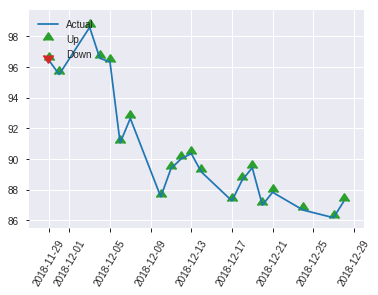


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25308992025816335
RMSE: 0.5030804312017745
LogLoss: 0.6993773630161187
Null degrees of freedom: 250
Residual degrees of freedom: 48
Null deviance: 348.2392766240658
Residual deviance: 351.0874362340916
AIC: 757.0874362340917
AUC: 0.49440559440559434
pr_auc: 0.4831327528245452
Gini: -0.01118881118881132
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43835007224138994: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    129  0.9923   (129.0/130.0)
1      0    121  0        (0.0/121.0)
Total  1    250  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.43835      0.652291   249
max f2                       0.43835      0.824251   249
max f0point5                 0.496338     0.544041   210
max accuracy                 0.564054     0.541833   45
max precision                0.624763     1          0
max recall                   0.43835      1          249
max specificity              0.624763     1          0
max absolute_mcc             0.615665     0.0928954  1
max min_per_class_accuracy   0.527134     0.479339   124
max mean_per_class_accuracy  0.564054     0.530515   45

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 52.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.611089           1.38292   1.38292            0.666667         0.618474  0.666667                    0.618474            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.603492           0         0.69146            0                0.60548   0.333333                    0.611977            0               0.0165289                  -100       -30.854
    3        0.0318725                   0.600504           1.03719   0.777893           0.5              0.601594  0.375                       0.609381            0.00826446      0.0247934                  3.71901    -22.2107
    4        0.0438247                   0.594293           0.69146   0.75432            0.333333         0.598217  0.363636                    0.606337            0.00826446      0.0330579                  -30.854    -24.568
    5        0.0517928                   0.592241           2.07438   0.957406           1                0.593555  0.461538                    0.60437             0.0165289       0.0495868                  107.438    -4.25938
    6        0.103586                    0.578206           1.43611   1.19676            0.692308         0.584793  0.576923                    0.594581            0.0743802       0.123967                   43.6109    19.6758
    7        0.151394                    0.570891           0.864325  1.09178            0.416667         0.575217  0.526316                    0.588466            0.0413223       0.165289                   -13.5675   9.1779
    8        0.203187                    0.561753           1.11697   1.0982             0.538462         0.565347  0.529412                    0.582573            0.0578512       0.22314                    11.6974    9.82013
    9        0.302789                    0.548626           0.829752  1.0099             0.4              0.554325  0.486842                    0.573281            0.0826446       0.305785                   -17.0248   0.989561
    10       0.40239                     0.536127           0.912727  0.985844           0.44             0.542227  0.475248                    0.565595            0.0909091       0.396694                   -8.72727   -1.4156
    11       0.501992                    0.527017           0.829752  0.954873           0.4              0.530368  0.460317                    0.558605            0.0826446       0.479339                   -17.0248   -4.51266
    12       0.601594                    0.517833           0.912727  0.947896           0.44             0.522774  0.456954                    0.552673            0.0909091       0.570248                   -8.72727   -5.21044
    13       0.701195                    0.509642           0.995702  0.954686           0.48             0.513957  0.460227                    0.547173            0.0991736       0.669421                   -0.429752  -4.53137
    14       0.800797                    0.500278           1.57653   1.03203            0.76             0.504506  0.497512                    0.541867            0.157025        0.826446                   57.6529    3.20299
    15       0.900398                    0.484066           0.829752  1.00965            0.4              0.493491  0.486726                    0.536515            0.0826446       0.909091                   -17.0248   0.965406
    16       1                           0.434285           0.912727  1                  0.44             0.468908  0.482072               

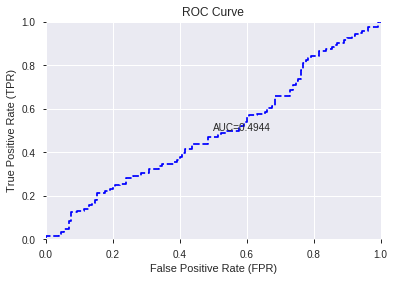

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


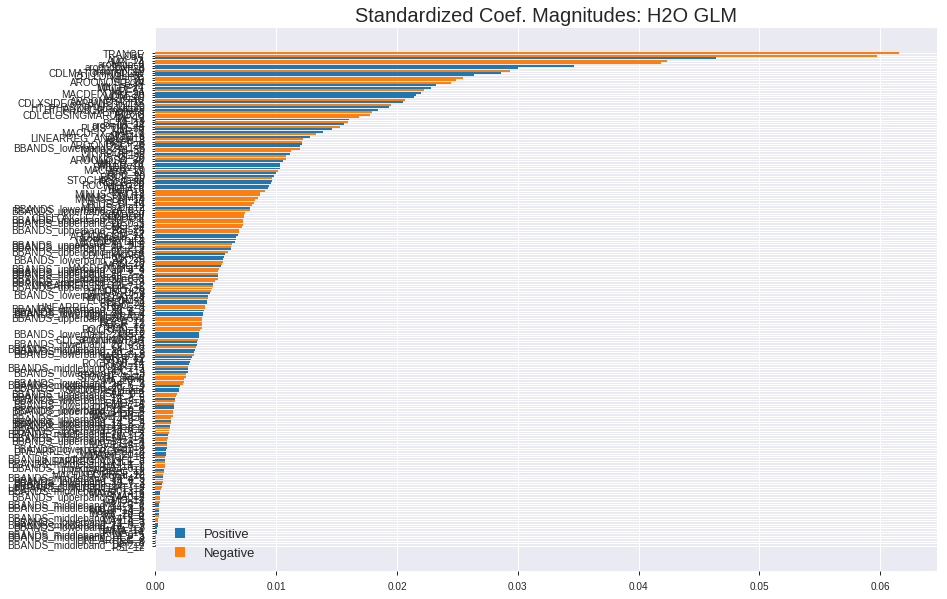

'log_likelihood'
--2019-08-25 15:33:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_153319_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_153319_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['TRANGE',
 'OBV',
 'ADX_12',
 'MFI_24',
 'aroonup_8',
 'aroondown_8',
 'DX_30',
 'aroonup_12',
 'CDLMATCHINGLOW',
 'CDLLONGLINE',
 'MFI_30',
 'AROONOSC_14',
 'BOP',
 'WILLR_24',
 'MACDEXT',
 'MFI_14',
 'MACDFIX_hist_20',
 'MOM_20',
 'ULTOSC',
 'AROONOSC_12',
 'CDLXSIDEGAP3METHODS',
 'PLUS_DI_20',
 'HT_PHASOR_quadrature',
 'HT_PHASOR_inphase',
 'ATR_8',
 'CDLCLOSINGMARUBOZU',
 'DX_12',
 'MFI_8',
 'BETA_12',
 'aroonup_24',
 'PLUS_DM_30',
 'VAR_8',
 'MACDFIX_hist_12',
 'MOM_8',
 'LINEARREG_ANGLE_12',
 'ROCR_8',
 'ROCP_8',
 'AROONOSC_20',
 'BBANDS_lowerband_24_1_5',
 'MINUS_DI_30',
 'ROCP_30',
 'CCI_8',
 'MINUS_DI_20',
 'AROONOSC_30',
 'WILLR_20',
 'WILLR_14',
 'STDDEV_8',
 'MACDFIX_20',
 'ATR_12',
 'ROC_20',
 'ROCP_20',
 'STOCHRSI_fastk',
 'ROCR_20',
 'ROCR100_20',
 'WILLR_8',
 'BETA_8',
 'MFI_12',
 'MINUS_DM_12',
 'MINUS_DM_8',
 'MINUS_DM_14',
 'CCI_20',
 'PLUS_DI_14',
 'MINUS_DI_12',
 'BBANDS_lowerband_24_0_4',
 'BBANDS_upperband_20_6_5',
 'CMO_30',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 '

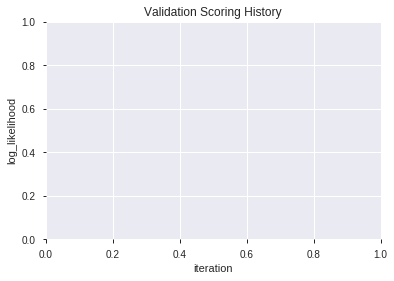

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_153333_model_1  0.522346  0.705233              0.496154  0.505721  0.255754
1               XGBoost_2_AutoML_20190825_153333  0.517038  0.709533              0.500000  0.507731  0.257791
2  XGBoost_grid_1_AutoML_20190825_153333_model_2  0.509345  0.699822              0.500000  0.503246  0.253257
3  XGBoost_grid_1_AutoML_20190825_153333_model_3  0.500254  0.701898              0.488748  0.504286  0.254304
4  XGBoost_grid_1_AutoML_20190825_153333_model_4  0.492816  0.699696              0.484901  0.503220  0.253231
5               XGBoost_3_AutoML_20190825_153333  0.488493  0.705629              0.500000  0.506004  0.256040
6  XGBoost_grid_1_AutoML_20190825_153333_model_6  0.488303  0.707983              0.500000  0.507254  0.257307
7  XGBoost_grid_1_AutoML_20190825_153333_model_7  0.467196  0.731845              0.500000  0.517897  0.268218
8               XGBoost_1_AutoML_20190825_153333  0.462174  0.729655              0.496154  0.516934  0.267221
9  XGBoost_grid_1_AutoML_20190825_153333_model_5  0.448442  0.749978              0.500000  0.526198  0.276885

variable  relative_importance  scaled_importance  percentage
0                     TRANGE           153.963318           1.000000    0.035234
1                    BETA_12           129.376785           0.840309    0.029607
2       HT_PHASOR_quadrature           123.746323           0.803739    0.028319
3                 PLUS_DM_30           119.760132           0.777848    0.027406
4                     ADX_12           118.306610           0.768408    0.027074
..                       ...                  ...                ...         ...
135   LINEARREG_INTERCEPT_12             3.894105           0.025292    0.000891
136       LINEARREG_SLOPE_12             3.797921           0.024668    0.000869
137  BBANDS_lowerband_14_1_4             3.732885           0.024245    0.000854
138  BBANDS_lowerband_14_7_3             3.081108           0.020012    0.000705
139  BBANDS_upperband_14_0_5             1.215076           0.007892    0.000278

[140 rows x 4 columns]

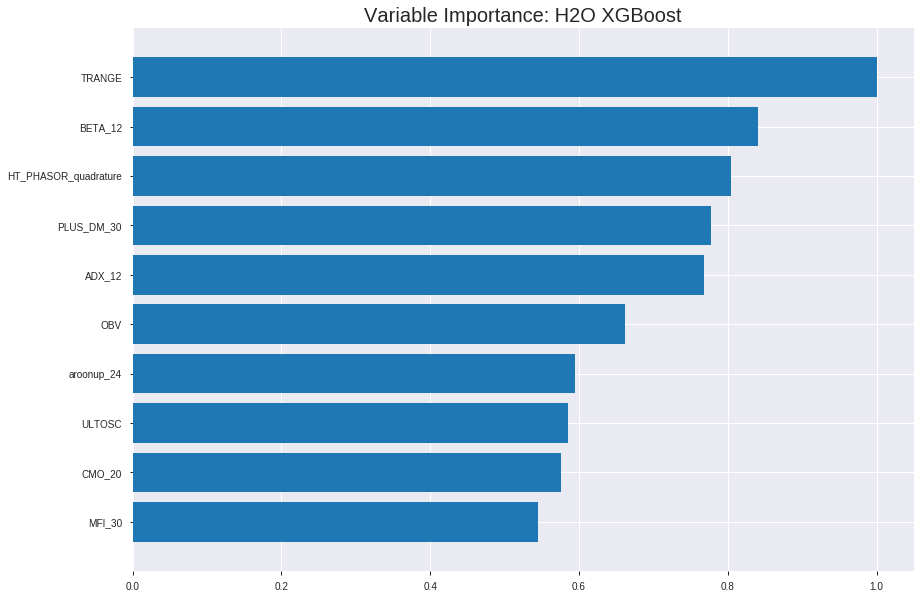

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_153333_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19078654332882203
RMSE: 0.4367911896190467
LogLoss: 0.5717272194993636
Mean Per-Class Error: 0.14603056814039472
AUC: 0.9274709680779045
pr_auc: 0.9296172567639381
Gini: 0.854941936155809
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4985608637332916: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      700  165  0.1908   (165.0/865.0)
1      99   789  0.1115   (99.0/888.0)
Total  799  954  0.1506   (264.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498561     0.856678  204
max f2                       0.45345      0.898642  253
max f0point5                 0.539846     0.868056  155
max accuracy                 0.509208     0.853965  192
max precision                0.827099     1         0
max recall                   0.378145     1         324
max specificity              0.827099     1         0
max absolute_mcc             0.509208     0.707904  192
max min_per_class_accuracy   0.509208     0.853604  192
max mean_per_class_accuracy  0.509208     0.853969  192

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.713597           1.9741     1.9741             1                0.740431  1                           0.740431            0.0202703       0.0202703                  97.4099   97.4099
    2        0.0205362                   0.696067           1.9741     1.9741             1                0.704432  1                           0.722432            0.0202703       0.0405405                  97.4099   97.4099
    3        0.0302339                   0.682252           1.9741     1.9741             1                0.689611  1                           0.711904            0.0191441       0.0596847                  97.4099   97.4099
    4        0.040502                    0.671106           1.9741     1.9741             1                0.677011  1                           0.703058            0.0202703       0.079955                   97.4099   97.4099
    5        0.0501997                   0.66302            1.9741     1.9741             1                0.666824  1                           0.696058            0.0191441       0.0990991                  97.4099   97.4099
    6        0.100399                    0.630373           1.92923    1.95167            0.977273         0.645235  0.988636                    0.670647            0.0968468       0.195946                   92.9233   95.1666
    7        0.150029                    0.61116            1.90603    1.93657            0.965517         0.620132  0.980989                    0.653936            0.0945946       0.290541                   90.6027   93.6569
    8        0.200228                    0.590197           1.92923    1.93473            0.977273         0.601887  0.980057                    0.640887            0.0968468       0.387387                   92.9233   93.473
    9        0.300057                    0.557585           1.83873    1.90279            0.931429         0.573741  0.963878                    0.618548            0.183559        0.570946                   83.8732   90.2791
    10       0.399886                    0.533202           1.44391    1.78824            0.731429         0.544215  0.905849                    0.599991            0.144144        0.71509                    44.3912   78.8235
    11       0.500285                    0.509852           1.31233    1.69273            0.664773         0.521399  0.857469                    0.584219            0.131757        0.846847                   31.2327   69.2728
    12       0.600114                    0.482135           0.721956   1.53124            0.365714         0.496663  0.775665                    0.569654            0.0720721       0.918919                   -27.8044  53.124
    13       0.699943                    0.453883           0.473784   1.38042            0.24             0.468533  0.699267                    0.555232            0.0472973       0.966216                   -52.6216  38.0421
    14       0.799772                    0.425369           0.236892   1.23768            0.12             0.439982  0.626961                    0.540846            0.0236486       0.989865                   -76.3108  23.7684
    15       0.899601                    0.379067           0.0902445  1.11035            0.0457143        0.405056  0.56246                     0.525777            0.00900901      0.998874                   -90.9755  11.0353
    16       1                           0.195276           0.0112165  1                  0.00568182       0.329032  0.50656                     0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2486482527117348
RMSE: 0.49864642053436503
LogLoss: 0.6905416753745062
Mean Per-Class Error: 0.4417782976541469
AUC: 0.5414850660171773
pr_auc: 0.5635491854897017
Gini: 0.08297013203435455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3453335762023926: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    231  0.9957   (231.0/232.0)
1      0    269  0        (0.0/269.0)
Total  1    500  0.4611   (231.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345334     0.69961   398
max f2                       0.345334     0.853426  398
max f0point5                 0.4755       0.610772  297
max accuracy                 0.477021     0.576846  294
max precision                0.701345     1         0
max recall                   0.345334     1         398
max specificity              0.701345     1         0
max absolute_mcc             0.4755       0.135441  297
max min_per_class_accuracy   0.523985     0.534483  199
max mean_per_class_accuracy  0.477021     0.558222  294

Gains/Lift Table: Avg response rate: 53.69 %, avg score: 52.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.672535           0.931227  0.931227           0.5              0.680608  0.5                         0.680608            0.0111524       0.0111524                  -6.87732  -6.87732
    2        0.0219561                   0.656781           1.11747   1.01588            0.6              0.662771  0.545455                    0.6725              0.0111524       0.0223048                  11.7472   1.58837
    3        0.0319361                   0.644082           0.744981  0.931227           0.4              0.649223  0.5                         0.665226            0.00743494      0.0297398                  -25.5019  -6.87732
    4        0.0419162                   0.635549           1.86245   1.15295            1                0.640224  0.619048                    0.659273            0.0185874       0.0483271                  86.2454   15.2947
    5        0.0518962                   0.62892            0.744981  1.07449            0.4              0.631372  0.576923                    0.653908            0.00743494      0.0557621                  -25.5019  7.44924
    6        0.101796                    0.607122           1.11747   1.09556            0.6              0.61618   0.588235                    0.635414            0.0557621       0.111524                   11.7472   9.55609
    7        0.153693                    0.593501           1.28939   1.16101            0.692308         0.599886  0.623377                    0.623417            0.0669145       0.178439                   28.9391   16.101
    8        0.201597                    0.585657           0.853625  1.08797            0.458333         0.589195  0.584158                    0.615285            0.0408922       0.219331                   -14.6375  8.79679
    9        0.301397                    0.563715           0.968476  1.0484             0.52             0.573056  0.562914                    0.601302            0.0966543       0.315985                   -3.15242  4.8401
    10       0.401198                    0.544691           0.893978  1.00999            0.48             0.553929  0.542289                    0.589518            0.0892193       0.405204                   -10.6022  0.998724
    11       0.500998                    0.524306           1.26647   1.06108            0.68             0.534541  0.569721                    0.578566            0.126394        0.531599                   26.6468   6.10791
    12       0.600798                    0.50722            1.00572   1.05188            0.54             0.515344  0.564784                    0.568064            0.100372        0.63197                    0.572491  5.18841
    13       0.700599                    0.489366           1.08022   1.05592            0.58             0.49864   0.566952                    0.558175            0.107807        0.739777                   8.0223    5.59209
    14       0.800399                    0.468874           1.04297   1.05431            0.56             0.478819  0.566085                    0.54828             0.104089        0.843866                   4.2974    5.43066
    15       0.9002                      0.43942            0.744981  1.02001            0.4              0.455391  0.547672                    0.537982            0.0743494       0.918216                   -25.5019  2.00134
    16       1                           0.320083           0.81948   1                  0.44             0.405646  0.536926                    0.524775        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:33:38  0.015 sec   0                  0.5              0.693147            0.5             0                  1                0.49344                          0.5                0.693147              0.5               0                    1                  0.463074
    2019-08-25 15:33:39  0.151 sec   5                  0.491716         0.676668            0.731557        0.738448           1.86443          0.359384                         0.498922           0.690995              0.552477          0.55478              0.827757           0.463074
    2019-08-25 15:33:39  0.206 sec   10                 0.484527         0.662484            0.767365        0.770916           1.86443          0.313748                         0.499303           0.691756              0.540331          0.544021             0.620818           0.459082
    2019-08-25 15:33:39  0.270 sec   15                 0.479618         0.652817            0.79056         0.796943           1.9741           0.294923                         0.49879            0.690733              0.545868          0.554478             0.931227           0.457086
    2019-08-25 15:33:39  0.328 sec   20                 0.473751         0.641396            0.821388        0.825735           1.9741           0.277239                         0.497766           0.68868               0.556203          0.573299             1.55204            0.45509
    2019-08-25 15:33:39  0.400 sec   25                 0.465534         0.625615            0.856342        0.861421           1.9741           0.232744                         0.497291           0.68771               0.554024          0.574021             0.931227           0.45509
    2019-08-25 15:33:39  0.458 sec   30                 0.461554         0.617972            0.868812        0.873245           1.9741           0.220194                         0.497249           0.687658              0.557901          0.576754             0.931227           0.457086
    2019-08-25 15:33:39  0.520 sec   35                 0.455944         0.607345            0.884529        0.88822            1.9741           0.212208                         0.497455           0.688089              0.555402          0.573257             0.931227           0.45509
    2019-08-25 15:33:39  0.583 sec   40                 0.45085          0.597752            0.896713        0.900067           1.9741           0.196805                         0.498225           0.689645              0.546589          0.566238             1.24164            0.45509
    2019-08-25 15:33:39  0.655 sec   45                 0.443499         0.584126            0.916646        0.91889            1.9741           0.169424                         0.498129           0.689426              0.544642          0.574637             1.86245            0.459082
    2019-08-25 15:33:39  0.739 sec   50                 0.436791         0.571727            0.927471        0.929617           1.9741           0.150599                         0.498646           0.690542              0.541485          0.563549             0.931227           0.461078

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
TRANGE                   153.96331787109375     1.0                   0.035233632164283615
BETA_12                  129.3767852783203      0.8403091532922239    0.029607143611378832
HT_PHASOR_quadrature     123.74632263183594     0.8037389966838914    0.0283186441652506
PLUS_DM_30               119.7601318359375      0.7778484738566561    0.027406427007414802
ADX_12                   118.30661010742188     0.7684077723401261    0.02707379680280859
---                      ---                    ---                   ---
LINEARREG_INTERCEPT_12   3.8941049575805664     0.02529242037275994   0.0008911438359582569
LINEARREG_SLOPE_12       3.7979211807250977     0.024667701587886788  0.000869132724085918
BBANDS_lowerband_14_1_4  3.7328848838806152     0.024245287354783977  0.0008542495363758156
BBANDS_lowerband_14_7_3  3.0811080932617188     0.02001196217297282   0.0007050941140880823
BBANDS_upperband_14_0_5  1.2150764465332031     0.007891986632494692  0.00027806335405476136


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.6522911051212937)

('auc', 0.5223458359821996)

('logloss', 0.7052331777730454)

('mean_per_class_error', 0.45219326128417037)

('rmse', 0.505720949934355)

('mse', 0.25575367920250636)

xgboost prediction progress: |████████████████████████████████████████████| 100%


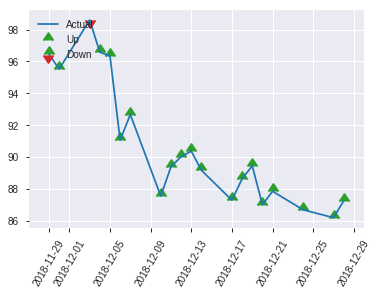


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25575367920250636
RMSE: 0.505720949934355
LogLoss: 0.7052331777730454
Mean Per-Class Error: 0.45219326128417037
AUC: 0.5223458359821996
pr_auc: 0.488748659964734
Gini: 0.04469167196439927
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32193154096603394: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    129  0.9923   (129.0/130.0)
1      0    121  0        (0.0/121.0)
Total  1    250  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321932     0.652291  248
max f2                       0.321932     0.824251  248
max f0point5                 0.509911     0.542741  152
max accuracy                 0.521833     0.545817  135
max precision                0.617461     0.56      24
max recall                   0.321932     1         248
max specificity              0.689832     0.992308  0
max absolute_mcc             0.679907     0.10611   2
max min_per_class_accuracy   0.527994     0.53719   123
max mean_per_class_accuracy  0.520016     0.547807  137

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 52.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.679534           0         0                  0                0.686339  0                           0.686339            0               0                          -100       -100
    2        0.0239044                   0.674936           1.38292   0.69146            0.666667         0.676713  0.333333                    0.681526            0.0165289       0.0165289                  38.292     -30.854
    3        0.0318725                   0.655515           1.03719   0.777893           0.5              0.659457  0.375                       0.676009            0.00826446      0.0247934                  3.71901    -22.2107
    4        0.0438247                   0.652047           0.69146   0.75432            0.333333         0.652917  0.363636                    0.669711            0.00826446      0.0330579                  -30.854    -24.568
    5        0.0517928                   0.633715           2.07438   0.957406           1                0.638173  0.461538                    0.664859            0.0165289       0.0495868                  107.438    -4.25938
    6        0.103586                    0.616106           1.27654   1.11697            0.615385         0.622285  0.538462                    0.643572            0.0661157       0.115702                   27.6542    11.6974
    7        0.151394                    0.600002           0.69146   0.982601           0.333333         0.607721  0.473684                    0.632251            0.0330579       0.14876                    -30.854    -1.73989
    8        0.203187                    0.584213           0.957406  0.976179           0.461538         0.590628  0.470588                    0.621641            0.0495868       0.198347                   -4.25938   -2.38211
    9        0.302789                    0.566014           0.995702  0.982601           0.48             0.572745  0.473684                    0.605557            0.0991736       0.297521                   -0.429752  -1.73989
    10       0.40239                     0.544124           1.3276    1.068              0.64             0.552567  0.514851                    0.59244             0.132231        0.429752                   32.7603    6.79977
    11       0.501992                    0.527812           1.07868   1.07012            0.52             0.535078  0.515873                    0.581059            0.107438        0.53719                    7.86777    7.01168
    12       0.601594                    0.513551           1.07868   1.07153            0.52             0.51973   0.516556                    0.570905            0.107438        0.644628                   7.86777    7.15341
    13       0.701195                    0.491394           0.746777  1.0254             0.36             0.503022  0.494318                    0.561263            0.0743802       0.719008                   -25.3223   2.54038
    14       0.800797                    0.469727           0.829752  1.00107            0.4              0.479157  0.482587                    0.551051            0.0826446       0.801653                   -17.0248   0.106903
    15       0.900398                    0.434349           0.912727  0.991297           0.44             0.451641  0.477876                    0.540054            0.0909091       0.892562                   -8.72727   -0.870328
    16       1                           0.320441           1.07868   1                  0.52             0.387696  0.482072               

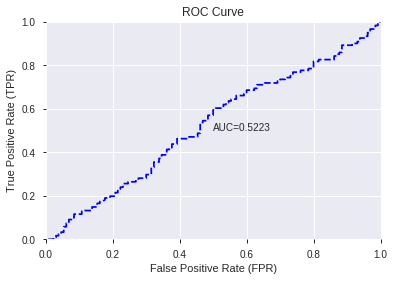

This function is available for GLM models only


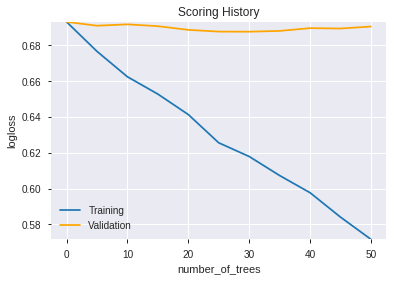

--2019-08-25 15:33:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_153333_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_153333_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b594',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['TRANGE',
 'BETA_12',
 'HT_PHASOR_quadrature',
 'PLUS_DM_30',
 'ADX_12',
 'OBV',
 'aroonup_24',
 'ULTOSC',
 'CMO_20',
 'MFI_30',
 'ROC_14',
 'BOP',
 'MFI_14',
 'MACDFIX_20',
 'MACDEXT',
 'MFI_24',
 'WILLR_14',
 'WILLR_20',
 'DX_30',
 'MFI_12',
 'STOCHRSI_fastd',
 'AROONOSC_14',
 'BBANDS_upperband_20_6_5',
 'BBANDS_upperband_20_5_5',
 'LINEARREG_ANGLE_12',
 'MACDFIX_hist_20',
 'CORREL_12',
 'MACDEXT_hist',
 'ATR_8',
 'STDDEV_8',
 'BBANDS_upperband_14_3_4',
 'BBANDS_upperband_20_5_3',
 'CCI_24',
 'MOM_12',
 'PLUS_DI_8',
 'ATR_12',
 'PLUS_DI_12',
 'MACDFIX_signal_20',
 'BBANDS_upperband_20_0_5',
 'LINEARREG_ANGLE_8',
 'CCI_14',
 'WILLR_24',
 'BETA_8',
 'BBANDS_upperband_20_3_5',
 'ROC_12',
 'ROCR_14',
 'MOM_20',
 'PLUS_DM_8',
 'MINUS_DI_20',
 'MFI_8',
 'NATR_12',
 'HT_PHASOR_inphase',
 'MINUS_DI_30',
 'MINUS_DM_14',
 'CCI_8',
 'BBANDS_lowerband_20_0_4',
 'DX_12',
 'TSF_8',
 'CORREL_8',
 'DX_20',
 'CMO_24',
 'RSI_8',
 'CMO_12',
 'MACDFIX_hist_8',
 'BBANDS_upperband_14_2_5',
 'MINUS_DI_12'

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.586
GLM             0.558
XGBoost         0.574
dtype: float64

DeepLearning    GLM  XGBoost
All          0.562  0.558    0.554
DLF          0.586  0.542    0.574
Fwe          0.546  0.558    0.554
RFE          0.562  0.542    0.546
XGBF         0.562  0.542    0.574





F1


DeepLearning    0.669
GLM             0.652
XGBoost         0.654
dtype: float64

DeepLearning    GLM  XGBoost
All          0.669  0.652    0.652
DLF          0.651  0.651    0.654
Fwe          0.665  0.652    0.652
RFE          0.652  0.652    0.652
XGBF         0.656  0.651    0.654





auc


DeepLearning    0.569
GLM             0.516
XGBoost         0.535
dtype: float64

DeepLearning    GLM  XGBoost
All          0.537  0.516    0.535
DLF          0.569  0.515    0.528
Fwe          0.535  0.516    0.535
RFE          0.526  0.494    0.522
XGBF         0.553  0.515    0.528





logloss


DeepLearning    0.966
GLM             0.699
XGBoost         0.705
dtype: float64

DeepLearning    GLM  XGBoost
All          0.966  0.692    0.698
DLF          0.939  0.693    0.693
Fwe          0.898  0.692    0.698
RFE          0.752  0.699    0.705
XGBF         0.704  0.693    0.693





mean_per_class_error


DeepLearning    0.448
GLM             0.469
XGBoost         0.452
dtype: float64

DeepLearning    GLM  XGBoost
All          0.426  0.452    0.451
DLF          0.418  0.467    0.438
Fwe          0.441  0.452    0.451
RFE          0.448  0.469    0.452
XGBF         0.435  0.467    0.438





rmse


DeepLearning    0.580
GLM             0.503
XGBoost         0.506
dtype: float64

DeepLearning    GLM  XGBoost
All          0.580  0.500    0.502
DLF          0.543  0.500    0.500
Fwe          0.563  0.500    0.502
RFE          0.522  0.503    0.506
XGBF         0.505  0.500    0.500





mse


DeepLearning    0.337
GLM             0.253
XGBoost         0.256
dtype: float64

DeepLearning    GLM  XGBoost
All          0.337  0.250    0.252
DLF          0.295  0.250    0.250
Fwe          0.317  0.250    0.252
RFE          0.272  0.253    0.256
XGBF         0.255  0.250    0.250

{'F1':       DeepLearning    GLM  XGBoost
 All          0.669    NaN      NaN
 DLF          0.651    NaN      NaN
 DLF            NaN  0.651      NaN
 DLF            NaN    NaN    0.654
 All            NaN  0.652      NaN
 All            NaN    NaN    0.652
 XGBF         0.656    NaN      NaN
 XGBF           NaN  0.651      NaN
 XGBF           NaN    NaN    0.654
 Fwe          0.665    NaN      NaN
 Fwe            NaN  0.652      NaN
 Fwe            NaN    NaN    0.652
 RFE          0.652    NaN      NaN
 RFE            NaN  0.652      NaN
 RFE            NaN    NaN    0.652,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.562    NaN      NaN
 DLF          0.586    NaN      NaN
 DLF            NaN  0.542      NaN
 DLF            NaN    NaN    0.574
 All            NaN  0.558      NaN
 All            NaN    NaN    0.554
 XGBF         0.562    NaN      NaN
 XGBF           NaN  0.542      NaN
 XGBF           NaN    NaN    0.574
 Fwe          0.546    NaN      NaN
 Fwe     